# VQVAE FOR OASIS BRAIN DATA

This notebook contains training of models and shows the results with visualisations

I initially didn't realise the driver file could be a ipynb file so I started with a python driver file. I mostly used this notebook to load the data, test the models were working as i made them, run initial training loops, and evaluate the models and make visualisations. I then copied things that worked into the data_loader.py and driver.py files. I did use the driver.py file for training the models overnight but all images used in the readme were  initially generated here.

The code here is a bit messy and the code in the .py files is mostly cleaner but I wanted to include this just in case 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

import numpy as np
import tensorflow as tf

 
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pathlib
import math

In [855]:
import importlib
import data_loaders, model
importlib.reload(data_loaders)
importlib.reload(model)
from model import VQVAE, PixelCNN
from data_loaders import * 


# data loaders

In [876]:
class OASISSeq(tf.keras.utils.Sequence):
    """
    Sequence to load OASIS dataset

    Based on this: https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
    and my own Demo 2 part 3 code
    """

    def __init__(self, x_set, y_set, batch_size, downsample=None):
        """
        Initialises a data loader for a set of data
        x_set, y_set: set of file paths for x and y files
        batch_size: number of images in each batch
        """
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.x_img_size=256
        self.y_img_size=256
        self.downsample = downsample

    def __len__(self):
        """ Returns length of batch set"""
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        """ Returns one batch of data, X and y as a tuple """
        # select set of file names that corrospond to index idx
        X_train_files = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        y_train_files = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        # open each file and load them into the list as an image
        X_train = []
        y_train = []
        for file in X_train_files:
            img = mpimg.imread(file)
         
            X_train.append(img)
        for file in y_train_files:
            img = mpimg.imread(file)
            
            y_train.append(img)
       
            
        # change label names from floats to ints
        labels_o = np.unique(y_train)

        # add an extra dimention 
        X_train = np.array(X_train).reshape(-1, self.x_img_size, self.y_img_size, 1)
        y_train = np.array(y_train).reshape(-1, self.x_img_size, self.y_img_size, 1)
        
        # rename labels from floats to integers
        y_train[np.where(y_train==labels_o[0])] = 0
        y_train[np.where(y_train==labels_o[-1])] = 3
        y_train[np.where(y_train==labels_o[1])] = 1
        y_train[np.where(y_train==labels_o[2])] = 2 
        
        # remove extra dimention in y now that labels are correct and cast as int
        y_train = np.array(y_train).reshape(-1, self.x_img_size, self.y_img_size).astype(np.int32)
        # print(y_train.dtype)
        # should i return tensors or numpy arrays
        if self.downsample:
#             print("downsampling")
            X_train = tf.image.resize(X_train, [self.downsample, self.downsample])
        return tf.constant(X_train), tf.constant(X_train)#, tf.constant(y_train)


In [877]:
data_dir = pathlib.Path("./keras_png_slices_data/keras_png_slices_data")
X_train_files = list(data_dir.glob('./keras_png_slices_train/*'))
y_train_files = list(data_dir.glob('./keras_png_slices_seg_train/*'))

X_test_files = list(data_dir.glob('./keras_png_slices_test/*'))
y_test_files = list(data_dir.glob('./keras_png_slices_seg_test/*'))

X_valid_files = list(data_dir.glob('./keras_png_slices_validate/*'))
y_valid_files = list(data_dir.glob('./keras_png_slices_seg_validate/*'))

train_seq = OASISSeq(sorted(X_train_files),sorted( y_train_files), 64, downsample=128)
valid_seq = OASISSeq(sorted(X_valid_files),sorted( y_valid_files), 64, downsample=128)
test_seq = OASISSeq(sorted(X_test_files),sorted( y_test_files), 32, downsample=128)
X_train, _ = train_seq.__getitem__(1)
# # print(X_train.__len__())
# print(tf.image.ssim(X_train[0], X_train[0], 3))
# print(tf.image.ssim(X_train[0], X_train[1], 3))


In [871]:
len(train_seq)

151

In [872]:
train_seq.batch_size

64

In [873]:
64*151

9664

In [31]:
train_seq = OASISSeq(sorted(X_train_files),sorted( y_train_files), 64, downsample=128)
X_train = train_seq.__getitem__(1)

In [8]:
X_train.shape, np.max(X_train), np.min(X_train), X_train.dtype

(TensorShape([64, 128, 128, 1]), 0.9852941, 0.0, tf.float32)

In [856]:
width, height = 256, 256
train_seq, valid_seq, test_seq = load_oasis_data("./keras_png_slices_data/keras_png_slices_data", batch_size=128)

In [857]:
X_train,_ = train_seq.__getitem__(1)
X_train.shape

TensorShape([128, 256, 256, 1])

# vqvae model

In [952]:
model = VQVAE()
model.build(input_shape=[1, width, height, 1])
print(model.summary())


Model: "vqvae_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vq_36 (VQ)                   multiple                  1024      
_________________________________________________________________
encoder (Encoder)            multiple                  11904     
_________________________________________________________________
decoder (Decoder)            multiple                  20625     
Total params: 33,553
Trainable params: 33,553
Non-trainable params: 0
_________________________________________________________________
None


In [953]:
model  = VQVAE()

## training

In [806]:
lr = 2*10**(-4)
batch_size = 128
# optimiser = 
# criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimiser = tf.keras.optimizers.Adam(learning_rate=lr)
loss_hist = []
import time


In [122]:
loss_hist = []
folder = "./saves/oasis/"
model_name = "fixed_model"

In [ ]:
# EPOCHS = 180
idx = 0
for epoch in range(EPOCHS):
    start = time.time()
    for sample, target in train_seq:
        idx+=1
        with tf.GradientTape() as tape:
            internal_loss, out = model(sample, training=True) 
#             print(sample.shape, out.shape, internal_loss.shape)
            image_dif = 1- tf.image.ssim(sample, out, 3)
            loss = internal_loss + image_dif 
#             loss, out = model(sample, training=True) 
            
#             loss = tf.nn.sparse_softmax_cross_entropy_with_logits(target,out)

        # step of optamisiser
        grads = tape.gradient(loss, model.trainable_weights)
        optimiser.apply_gradients((zip(grads, model.trainable_weights)))
        
        loss_hist += [np.mean(loss)]
        if (idx%100 == 0):    
            print('Run {}: \n\ttrain loss: {}'.format(idx, np.mean(loss)))

        if (idx%300 == 0):
            folder = "./saves/extra_conv/"
            time_now = time.time()
            model_name = "model_1_{}".format(time_now)
            model.save_weights(folder+model_name+"model_weights")
            np.save("./saves/initial/losses/loss_{}".format(time_now), loss_hist, allow_pickle=True) 
        
    print("Epoch time {}".format(start_time - time.time()))



In [115]:
for i in train_seq:
    print(i.dtype, i.shape)
    break

<dtype: 'float32'> (64, 128, 128, 1)


In [354]:
EPOCHS = 180
for epoch in range(EPOCHS):
    print("\nStart epoch", epoch)
    start_time = time.time()
    idx = 0
    for sample, target in train_seq:
        with tf.GradientTape() as tape:
            internal_loss, out = model(sample, training=True) 
            image_dif = 1- tf.image.ssim(sample, out, 3)
            loss = np.sum(internal_loss) + image_dif 
        
        # step of optamisiser
        grads = tape.gradient(loss, model.trainable_weights)
        optimiser.apply_gradients((zip(grads, model.trainable_weights)))
        # save for looking at later
        loss_hist += [loss]
    
        # Logging.
        if idx %30  == 0:

            print("EPOCH {} step {}".format(epoch, step))
            print("loss: {}, recon loss: {}, vqvae loss:{}. ssim: {}".format(
                loss, internal_loss[0], internal_loss[1], (1-imagae_diff)
            ))
        if (idx%30 == 0):
            time_now = time.time()
            details_1 = "E{}S{}".format(epoch, step)
            details_2 = "_{}_{}_".format(losses["ssim"].numpy(), time_now) 
            model.save_weights(folder+model_name+details_1+details_2+"model_weights")
#             np.save("./saves/oasis/losses/loss_{}".format(time_now), loss_hist, allow_pickle=True) 
        idx+=1
                               
    print("Epoch time {}".format(start_time - time.time()))


Start epoch 0
EPOCH 0 step 0
loss: 5.21363639831543, recon loss: 0.09575111418962479, vqvae loss:5.1178812980651855. ssim: 0.8947151303291321
EPOCH 0 step 30
loss: 5.185115814208984, recon loss: 0.09546253085136414, vqvae loss:5.089649200439453. ssim: 0.8949797749519348
EPOCH 0 step 60
loss: 5.156982898712158, recon loss: 0.09519094228744507, vqvae loss:5.061787128448486. ssim: 0.8952352404594421
EPOCH 0 step 90
loss: 5.129114151000977, recon loss: 0.09492162615060806, vqvae loss:5.034186840057373. ssim: 0.8954771161079407
EPOCH 0 step 120
loss: 5.101547718048096, recon loss: 0.09465210884809494, vqvae loss:5.006889820098877. ssim: 0.8957163691520691
EPOCH 0 step 150
loss: 5.074312210083008, recon loss: 0.09439196437597275, vqvae loss:4.979913234710693. ssim: 0.8959586024284363
Epoch time -127.28573870658875

Start epoch 1
EPOCH 1 step 0
loss: 5.0734076499938965, recon loss: 0.09438246488571167, vqvae loss:4.979018688201904. ssim: 0.8959680199623108
EPOCH 1 step 30
loss: 5.04642677307

EPOCH 10 step 0
loss: 4.088469982147217, recon loss: 0.08408914506435394, vqvae loss:4.004378318786621. ssim: 0.9058443903923035
EPOCH 10 step 30
loss: 4.071078777313232, recon loss: 0.08389109373092651, vqvae loss:3.98718523979187. ssim: 0.9060419797897339
EPOCH 10 step 60
loss: 4.053876876831055, recon loss: 0.08370113372802734, vqvae loss:3.9701740741729736. ssim: 0.9062376618385315
EPOCH 10 step 90
loss: 4.036795139312744, recon loss: 0.08351045101881027, vqvae loss:3.9532828330993652. ssim: 0.9064275026321411
EPOCH 10 step 120
loss: 4.019862174987793, recon loss: 0.08332181721925735, vqvae loss:3.9365389347076416. ssim: 0.9066132307052612
EPOCH 10 step 150
loss: 4.003093242645264, recon loss: 0.08314018696546555, vqvae loss:3.9199507236480713. ssim: 0.90679532289505
Epoch time -157.71287846565247

Start epoch 11
EPOCH 11 step 0
loss: 4.002536296844482, recon loss: 0.08313345164060593, vqvae loss:3.9193999767303467. ssim: 0.9068024158477783
EPOCH 11 step 30
loss: 3.9858827590942383

EPOCH 20 step 0
loss: 3.3684418201446533, recon loss: 0.07583300024271011, vqvae loss:3.2926061153411865. ssim: 0.9142656326293945
EPOCH 20 step 30
loss: 3.356743335723877, recon loss: 0.07568947970867157, vqvae loss:3.2810513973236084. ssim: 0.914412796497345
EPOCH 20 step 60
loss: 3.345155954360962, recon loss: 0.07555290311574936, vqvae loss:3.2696003913879395. ssim: 0.9145573377609253
EPOCH 20 step 90
loss: 3.3336336612701416, recon loss: 0.07541654258966446, vqvae loss:3.2582132816314697. ssim: 0.9146984815597534
EPOCH 20 step 120
loss: 3.3221945762634277, recon loss: 0.07528110593557358, vqvae loss:3.2469093799591064. ssim: 0.9148380756378174
EPOCH 20 step 150
loss: 3.3108482360839844, recon loss: 0.07515028119087219, vqvae loss:3.2356936931610107. ssim: 0.9149749875068665
Epoch time -141.4154417514801

Start epoch 21
EPOCH 21 step 0
loss: 3.3104710578918457, recon loss: 0.0751454085111618, vqvae loss:3.235321521759033. ssim: 0.9149802923202515
EPOCH 21 step 30
loss: 3.2991831302

EPOCH 30 step 0
loss: 2.868457317352295, recon loss: 0.06977228075265884, vqvae loss:2.7986764907836914. ssim: 0.92061448097229
EPOCH 30 step 30
loss: 2.8600552082061768, recon loss: 0.06966345012187958, vqvae loss:2.7903835773468018. ssim: 0.9207271933555603
EPOCH 30 step 60
loss: 2.8517251014709473, recon loss: 0.06956002861261368, vqvae loss:2.7821574211120605. ssim: 0.9208375215530396
EPOCH 30 step 90
loss: 2.8434336185455322, recon loss: 0.06945715099573135, vqvae loss:2.77396821975708. ssim: 0.9209453463554382
EPOCH 30 step 120
loss: 2.8351938724517822, recon loss: 0.06935480237007141, vqvae loss:2.7658307552337646. ssim: 0.9210526943206787
EPOCH 30 step 150
loss: 2.827012062072754, recon loss: 0.0692562535405159, vqvae loss:2.7577476501464844. ssim: 0.921157717704773
Epoch time -154.71959853172302

Start epoch 31
EPOCH 31 step 0
loss: 2.826740026473999, recon loss: 0.06925258040428162, vqvae loss:2.757479190826416. ssim: 0.9211617112159729
EPOCH 31 step 30
loss: 2.81858897209167

Epoch time -136.81405663490295

Start epoch 40
EPOCH 40 step 0
loss: 2.501136064529419, recon loss: 0.06512490659952164, vqvae loss:2.435997724533081. ssim: 0.9255234599113464
EPOCH 40 step 30
loss: 2.494811773300171, recon loss: 0.06504002213478088, vqvae loss:2.429758310317993. ssim: 0.925612211227417
EPOCH 40 step 60
loss: 2.4885377883911133, recon loss: 0.06495896726846695, vqvae loss:2.423565626144409. ssim: 0.9256995320320129
EPOCH 40 step 90
loss: 2.482285499572754, recon loss: 0.0648779571056366, vqvae loss:2.4173946380615234. ssim: 0.9257850050926208
EPOCH 40 step 120
loss: 2.4760687351226807, recon loss: 0.0647972822189331, vqvae loss:2.4112586975097656. ssim: 0.925869345664978
EPOCH 40 step 150
loss: 2.4698917865753174, recon loss: 0.0647198036313057, vqvae loss:2.4051599502563477. ssim: 0.9259521961212158
Epoch time -141.49555039405823

Start epoch 41
EPOCH 41 step 0
loss: 2.469686269760132, recon loss: 0.0647168681025505, vqvae loss:2.4049570560455322. ssim: 0.925955414772

EPOCH 50 step 0
loss: 2.2198245525360107, recon loss: 0.06142175942659378, vqvae loss:2.1583938598632812. ssim: 0.9294459819793701
EPOCH 50 step 30
loss: 2.2148940563201904, recon loss: 0.06135236471891403, vqvae loss:2.1535332202911377. ssim: 0.9295188784599304
EPOCH 50 step 60
loss: 2.2100017070770264, recon loss: 0.061286598443984985, vqvae loss:2.1487069129943848. ssim: 0.9295908808708191
EPOCH 50 step 90
loss: 2.205125570297241, recon loss: 0.0612231083214283, vqvae loss:2.1438934803009033. ssim: 0.9296583533287048
EPOCH 50 step 120
loss: 2.200272798538208, recon loss: 0.061158642172813416, vqvae loss:2.1391055583953857. ssim: 0.9297254085540771
EPOCH 50 step 150
loss: 2.195448637008667, recon loss: 0.0610959492623806, vqvae loss:2.1343443393707275. ssim: 0.9297922849655151
Epoch time -134.46263432502747

Start epoch 51
EPOCH 51 step 0
loss: 2.1952879428863525, recon loss: 0.061093561351299286, vqvae loss:2.134186029434204. ssim: 0.9297949075698853
EPOCH 51 step 30
loss: 2.1904716

EPOCH 60 step 0
loss: 1.9977483749389648, recon loss: 0.05842050164937973, vqvae loss:1.9393188953399658. ssim: 0.9326398372650146
EPOCH 60 step 30
loss: 1.9938007593154907, recon loss: 0.0583631806075573, vqvae loss:1.9354289770126343. ssim: 0.9327002763748169
EPOCH 60 step 60
loss: 1.9898837804794312, recon loss: 0.058309417217969894, vqvae loss:1.9315656423568726. ssim: 0.9327594041824341
EPOCH 60 step 90
loss: 1.9859758615493774, recon loss: 0.05825715512037277, vqvae loss:1.9277098178863525. ssim: 0.932814359664917
EPOCH 60 step 120
loss: 1.982088565826416, recon loss: 0.058205243200063705, vqvae loss:1.9238744974136353. ssim: 0.9328691959381104
EPOCH 60 step 150
loss: 1.9782212972640991, recon loss: 0.058154091238975525, vqvae loss:1.9200586080551147. ssim: 0.9329237341880798
Epoch time -132.2773244380951

Start epoch 61
EPOCH 61 step 0
loss: 1.9780921936035156, recon loss: 0.05815208703279495, vqvae loss:1.9199315309524536. ssim: 0.9329259395599365
EPOCH 61 step 30
loss: 1.97422

EPOCH 69 step 150
loss: 1.8181732892990112, recon loss: 0.05594416707754135, vqvae loss:1.7622231245040894. ssim: 0.9352768659591675
Epoch time -130.46873307228088

Start epoch 70
EPOCH 70 step 0
loss: 1.8180655241012573, recon loss: 0.05594245344400406, vqvae loss:1.7621171474456787. ssim: 0.9352787137031555
EPOCH 70 step 30
loss: 1.8148337602615356, recon loss: 0.05589435249567032, vqvae loss:1.7589329481124878. ssim: 0.935329258441925
EPOCH 70 step 60
loss: 1.811626672744751, recon loss: 0.05584929138422012, vqvae loss:1.7557709217071533. ssim: 0.9353792071342468
EPOCH 70 step 90
loss: 1.8084238767623901, recon loss: 0.055805426090955734, vqvae loss:1.7526121139526367. ssim: 0.9354252219200134
EPOCH 70 step 120
loss: 1.8052395582199097, recon loss: 0.05576196685433388, vqvae loss:1.7494715452194214. ssim: 0.93547123670578
EPOCH 70 step 150
loss: 1.8020707368850708, recon loss: 0.055719044059515, vqvae loss:1.7463454008102417. ssim: 0.9355167150497437
Epoch time -134.30968308448792



EPOCH 79 step 120
loss: 1.6724305152893066, recon loss: 0.05388288572430611, vqvae loss:1.6185439825057983. ssim: 0.9374806880950928
EPOCH 79 step 150
loss: 1.6697393655776978, recon loss: 0.05384588986635208, vqvae loss:1.6158896684646606. ssim: 0.9375199675559998
Epoch time -129.1123025417328

Start epoch 80
EPOCH 80 step 0
loss: 1.6696494817733765, recon loss: 0.05384441092610359, vqvae loss:1.615801215171814. ssim: 0.9375216364860535
EPOCH 80 step 30
loss: 1.6669538021087646, recon loss: 0.05380311235785484, vqvae loss:1.6131469011306763. ssim: 0.9375651478767395
EPOCH 80 step 60
loss: 1.6642788648605347, recon loss: 0.05376452952623367, vqvae loss:1.6105101108551025. ssim: 0.9376080632209778
EPOCH 80 step 90
loss: 1.6616053581237793, recon loss: 0.05372650548815727, vqvae loss:1.6078746318817139. ssim: 0.9376481175422668
EPOCH 80 step 120
loss: 1.6589475870132446, recon loss: 0.05368942394852638, vqvae loss:1.605254054069519. ssim: 0.937687873840332
EPOCH 80 step 150
loss: 1.65630

EPOCH 89 step 90
loss: 1.5495392084121704, recon loss: 0.05209411680698395, vqvae loss:1.4974408149719238. ssim: 0.939404308795929
EPOCH 89 step 120
loss: 1.5472493171691895, recon loss: 0.052061520516872406, vqvae loss:1.4951834678649902. ssim: 0.9394400119781494
EPOCH 89 step 150
loss: 1.5449702739715576, recon loss: 0.05202934145927429, vqvae loss:1.4929364919662476. ssim: 0.9394739866256714
Epoch time -131.51882147789001

Start epoch 90
EPOCH 90 step 0
loss: 1.5448942184448242, recon loss: 0.052028026431798935, vqvae loss:1.4928616285324097. ssim: 0.939475417137146
EPOCH 90 step 30
loss: 1.5426095724105835, recon loss: 0.051991939544677734, vqvae loss:1.4906129837036133. ssim: 0.9395134449005127
EPOCH 90 step 60
loss: 1.5403422117233276, recon loss: 0.051958292722702026, vqvae loss:1.488378643989563. ssim: 0.9395511746406555
EPOCH 90 step 90
loss: 1.5380747318267822, recon loss: 0.05192482843995094, vqvae loss:1.4861445426940918. ssim: 0.9395864009857178
EPOCH 90 step 120
loss: 1.5

EPOCH 99 step 60
loss: 1.4444724321365356, recon loss: 0.05052252858877182, vqvae loss:1.3939411640167236. ssim: 0.9410961270332336
EPOCH 99 step 90
loss: 1.442496657371521, recon loss: 0.05049293488264084, vqvae loss:1.3919947147369385. ssim: 0.9411274790763855
EPOCH 99 step 120
loss: 1.4405322074890137, recon loss: 0.05046382546424866, vqvae loss:1.390058994293213. ssim: 0.9411593675613403
EPOCH 99 step 150
loss: 1.4385758638381958, recon loss: 0.050435375422239304, vqvae loss:1.3881312608718872. ssim: 0.9411893486976624
Epoch time -130.45535945892334

Start epoch 100
EPOCH 100 step 0
loss: 1.4385104179382324, recon loss: 0.050434213131666183, vqvae loss:1.3880671262741089. ssim: 0.9411907196044922
EPOCH 100 step 30
loss: 1.4365485906600952, recon loss: 0.05040236562490463, vqvae loss:1.3861374855041504. ssim: 0.9412249326705933
EPOCH 100 step 60
loss: 1.4346020221710205, recon loss: 0.05037259683012962, vqvae loss:1.3842203617095947. ssim: 0.9412581324577332
EPOCH 100 step 90
loss: 

EPOCH 109 step 30
loss: 1.3536282777786255, recon loss: 0.04913167282938957, vqvae loss:1.3044886589050293. ssim: 0.942599356174469
EPOCH 109 step 60
loss: 1.3519155979156494, recon loss: 0.04910483583807945, vqvae loss:1.3028030395507812. ssim: 0.9426297545433044
EPOCH 109 step 90
loss: 1.3502025604248047, recon loss: 0.049078524112701416, vqvae loss:1.3011163473129272. ssim: 0.9426575303077698
EPOCH 109 step 120
loss: 1.3484989404678345, recon loss: 0.049052491784095764, vqvae loss:1.299438714981079. ssim: 0.9426859021186829
EPOCH 109 step 150
loss: 1.3468029499053955, recon loss: 0.0490274615585804, vqvae loss:1.2977676391601562. ssim: 0.9427124857902527
Epoch time -129.5979642868042

Start epoch 110
EPOCH 110 step 0
loss: 1.3467462062835693, recon loss: 0.04902642220258713, vqvae loss:1.297711968421936. ssim: 0.9427135586738586
EPOCH 110 step 30
loss: 1.3450438976287842, recon loss: 0.048998042941093445, vqvae loss:1.2960377931594849. ssim: 0.9427439570426941
EPOCH 110 step 60
loss

EPOCH 119 step 0
loss: 1.2743076086044312, recon loss: 0.04789230599999428, vqvae loss:1.2264052629470825. ssim: 0.9439391493797302
EPOCH 119 step 30
loss: 1.272797703742981, recon loss: 0.047866784036159515, vqvae loss:1.2249207496643066. ssim: 0.943966269493103
EPOCH 119 step 60
loss: 1.2713003158569336, recon loss: 0.04784289374947548, vqvae loss:1.2234469652175903. ssim: 0.9439931511878967
EPOCH 119 step 90
loss: 1.2698014974594116, recon loss: 0.04781932383775711, vqvae loss:1.2219716310501099. ssim: 0.9440182447433472
EPOCH 119 step 120
loss: 1.2683110237121582, recon loss: 0.04779624566435814, vqvae loss:1.2205036878585815. ssim: 0.9440432190895081
EPOCH 119 step 150
loss: 1.2668267488479614, recon loss: 0.04777427762746811, vqvae loss:1.2190415859222412. ssim: 0.9440665245056152
Epoch time -128.36062049865723

Start epoch 120
EPOCH 120 step 0
loss: 1.2667771577835083, recon loss: 0.04777335375547409, vqvae loss:1.2189927101135254. ssim: 0.9440674781799316
EPOCH 120 step 30
loss

EPOCH 128 step 150
loss: 1.2031643390655518, recon loss: 0.046758364886045456, vqvae loss:1.1563888788223267. ssim: 0.94516521692276
Epoch time -132.7048511505127

Start epoch 129
EPOCH 129 step 0
loss: 1.2031199932098389, recon loss: 0.0467575266957283, vqvae loss:1.1563453674316406. ssim: 0.9451660513877869
EPOCH 129 step 30
loss: 1.2017881870269775, recon loss: 0.04673459008336067, vqvae loss:1.155036211013794. ssim: 0.9451906085014343
EPOCH 129 step 60
loss: 1.2004672288894653, recon loss: 0.0467132069170475, vqvae loss:1.1537364721298218. ssim: 0.9452146887779236
EPOCH 129 step 90
loss: 1.1991443634033203, recon loss: 0.04669209197163582, vqvae loss:1.1524348258972168. ssim: 0.9452371001243591
EPOCH 129 step 120
loss: 1.1978285312652588, recon loss: 0.04667128995060921, vqvae loss:1.1511399745941162. ssim: 0.9452597498893738
EPOCH 129 step 150
loss: 1.196518063545227, recon loss: 0.04665125906467438, vqvae loss:1.1498494148254395. ssim: 0.9452810883522034
Epoch time -133.121906995

EPOCH 138 step 120
loss: 1.1413110494613647, recon loss: 0.04575344920158386, vqvae loss:1.0955396890640259. ssim: 0.9462560415267944
EPOCH 138 step 150
loss: 1.1401326656341553, recon loss: 0.04573531076312065, vqvae loss:1.0943795442581177. ssim: 0.9462750554084778
Epoch time -145.27821016311646

Start epoch 139
EPOCH 139 step 0
loss: 1.140093207359314, recon loss: 0.045734550803899765, vqvae loss:1.0943409204483032. ssim: 0.9462758302688599
EPOCH 139 step 30
loss: 1.1389093399047852, recon loss: 0.04571383073925972, vqvae loss:1.093177318572998. ssim: 0.9462983012199402
EPOCH 139 step 60
loss: 1.1377354860305786, recon loss: 0.04569461941719055, vqvae loss:1.0920226573944092. ssim: 0.9463196992874146
EPOCH 139 step 90
loss: 1.1365591287612915, recon loss: 0.045675359666347504, vqvae loss:1.0908657312393188. ssim: 0.9463402032852173
EPOCH 139 step 120
loss: 1.1353895664215088, recon loss: 0.045656368136405945, vqvae loss:1.0897151231765747. ssim: 0.9463610649108887
EPOCH 139 step 150

EPOCH 148 step 90
loss: 1.0860483646392822, recon loss: 0.0448421873152256, vqvae loss:1.0411860942840576. ssim: 0.9472336769104004
EPOCH 148 step 120
loss: 1.08499014377594, recon loss: 0.04482468590140343, vqvae loss:1.0401455163955688. ssim: 0.9472523927688599
EPOCH 148 step 150
loss: 1.0839362144470215, recon loss: 0.0448082834482193, vqvae loss:1.0391080379486084. ssim: 0.9472687244415283
Epoch time -148.01634550094604

Start epoch 149
EPOCH 149 step 0
loss: 1.0839009284973145, recon loss: 0.04480759799480438, vqvae loss:1.0390734672546387. ssim: 0.9472694396972656
EPOCH 149 step 30
loss: 1.0828421115875244, recon loss: 0.044788848608732224, vqvae loss:1.038033127784729. ssim: 0.9472894072532654
EPOCH 149 step 60
loss: 1.081791877746582, recon loss: 0.04477144405245781, vqvae loss:1.0370005369186401. ssim: 0.9473088979721069
EPOCH 149 step 90
loss: 1.0807393789291382, recon loss: 0.04475411772727966, vqvae loss:1.0359652042388916. ssim: 0.9473275542259216
EPOCH 149 step 120
loss: 

EPOCH 158 step 60
loss: 1.0363866090774536, recon loss: 0.04401575028896332, vqvae loss:0.9923533201217651. ssim: 0.9481199979782104
EPOCH 158 step 90
loss: 1.0354293584823608, recon loss: 0.043999794870615005, vqvae loss:0.9914121031761169. ssim: 0.9481372237205505
EPOCH 158 step 120
loss: 1.034477949142456, recon loss: 0.04398409649729729, vqvae loss:0.9904763698577881. ssim: 0.9481541514396667
EPOCH 158 step 150
loss: 1.0335301160812378, recon loss: 0.04396916553378105, vqvae loss:0.9895435571670532. ssim: 0.9481695890426636
Epoch time -131.64694952964783

Start epoch 159
EPOCH 159 step 0
loss: 1.0334984064102173, recon loss: 0.04396853595972061, vqvae loss:0.9895123839378357. ssim: 0.9481703042984009
EPOCH 159 step 30
loss: 1.032545566558838, recon loss: 0.04395142197608948, vqvae loss:0.9885767102241516. ssim: 0.9481886625289917
EPOCH 159 step 60
loss: 1.031600832939148, recon loss: 0.0439356192946434, vqvae loss:0.987648069858551. ssim: 0.9482061862945557
EPOCH 159 step 90
loss: 

EPOCH 168 step 30
loss: 0.9915103912353516, recon loss: 0.04326072707772255, vqvae loss:0.9482342004776001. ssim: 0.9489306807518005
EPOCH 168 step 60
loss: 0.9906476140022278, recon loss: 0.04324616119265556, vqvae loss:0.9473860263824463. ssim: 0.948947012424469
EPOCH 168 step 90
loss: 0.9897820949554443, recon loss: 0.04323164001107216, vqvae loss:0.9465351104736328. ssim: 0.9489625692367554
EPOCH 168 step 120
loss: 0.9889217019081116, recon loss: 0.04321727529168129, vqvae loss:0.9456892013549805. ssim: 0.948978066444397
EPOCH 168 step 150
loss: 0.9880648851394653, recon loss: 0.04320365935564041, vqvae loss:0.9448456168174744. ssim: 0.9489920735359192
Epoch time -134.6711299419403

Start epoch 169
EPOCH 169 step 0
loss: 0.9880361557006836, recon loss: 0.04320308193564415, vqvae loss:0.9448174834251404. ssim: 0.9489926695823669
EPOCH 169 step 30
loss: 0.9871740341186523, recon loss: 0.04318738356232643, vqvae loss:0.9439711570739746. ssim: 0.9490095376968384
EPOCH 169 step 60
loss:

EPOCH 178 step 0
loss: 0.9507478475570679, recon loss: 0.0425678975880146, vqvae loss:0.9081637859344482. ssim: 0.9496753811836243
EPOCH 178 step 30
loss: 0.9499563574790955, recon loss: 0.04255332797765732, vqvae loss:0.9073870778083801. ssim: 0.949691116809845
EPOCH 178 step 60
loss: 0.9491721391677856, recon loss: 0.04253992438316345, vqvae loss:0.9066160917282104. ssim: 0.9497060179710388
EPOCH 178 step 90
loss: 0.9483852386474609, recon loss: 0.0425264798104763, vqvae loss:0.9058424830436707. ssim: 0.9497202634811401
EPOCH 178 step 120
loss: 0.9476029872894287, recon loss: 0.04251325502991676, vqvae loss:0.905073344707489. ssim: 0.949734628200531
EPOCH 178 step 150
loss: 0.9468238353729248, recon loss: 0.04250072315335274, vqvae loss:0.9043067693710327. ssim: 0.9497475624084473
Epoch time -133.32045245170593

Start epoch 179
EPOCH 179 step 0
loss: 0.9467977285385132, recon loss: 0.04250018671154976, vqvae loss:0.9042811989784241. ssim: 0.949748158454895
EPOCH 179 step 30
loss: 0.9

In [369]:
np.save("./saves/oasis/losses/loss_{}.npy".format(time_now), loss_hist[::2], allow_pickle=True) 

In [366]:
s_h = []
for i, s in enumerate(loss_hist]):
    s_h += [s["loss"]]

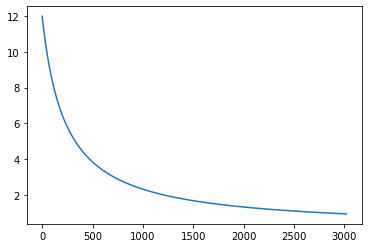

In [367]:
plt.plot(s_h)

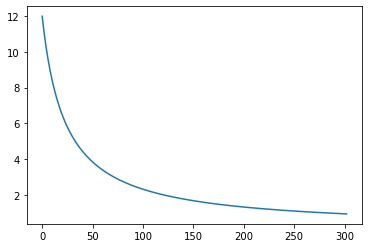

In [365]:
plt.plot(s_h)

In [957]:
model=VQVAE()

In [958]:
model.load_weights("./saves/oasis/fixed_modelE179S150_0.9498197436332703_1635636863.749701_model_weights")

In [902]:
ssims = []
for x, y, in test_seq:

    reconstructions_test = model.predict(x)
    ssims += [np.mean(tf.image.ssim(x, reconstructions_test, 3))]
    

In [903]:
np.mean(ssims)

0.96314466

In [509]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]


Input shape of the PixelCNN: (32, 32)


## Plotting

0.96734715 0.66986257
0.96734715 0.66986257
0.96734715 0.66986257
0.967347 0.66986257
0.96734715 0.66986257
0.96734715 0.66986257


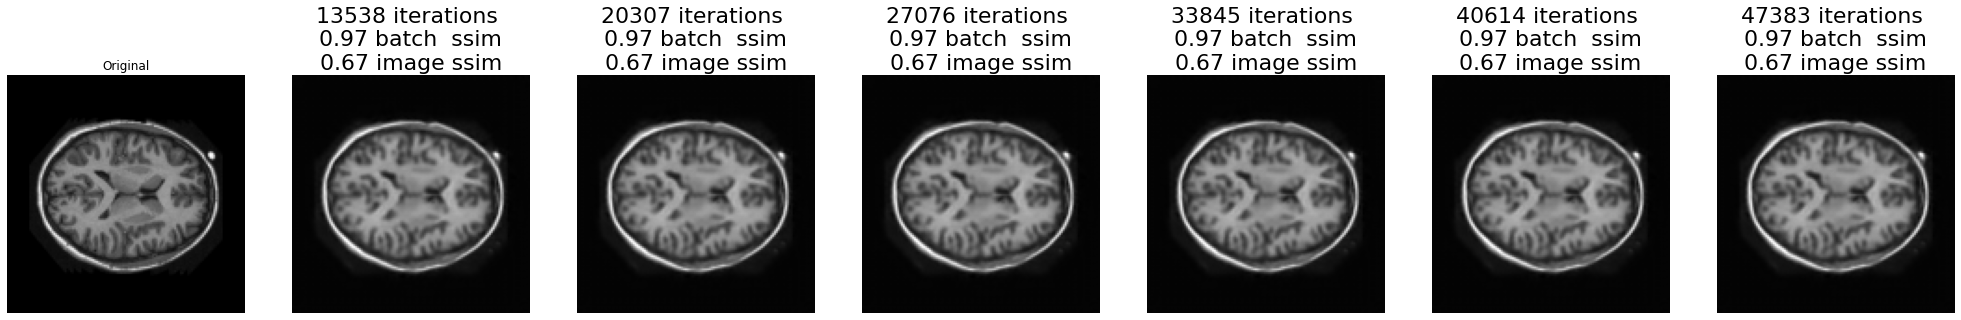

In [908]:
# valid_seq = OASISSeq(sorted(X_valid_files),sorted( y_valid_files), 20)
X_test, y_test = test_seq.__getitem__(1)

plt.figure(figsize=(5*8,5))
n = 8
idx = 8
plt.subplot(1, n, 1)
plt.axis('off') 
plt.imshow(X_test[idx],  cmap='gray')
plt.title("Original")

# model_test = VQVAE()
for i in range(n-2):
    # model_test.build( input_shape=[10, 256, 256, 1])
    # print(model.summary())
#     model_test.load_weights("./saves/initial/"+saved_models[i])
    out1 = model(X_test)
    valid_ssim = (tf.image.ssim(X_test, out1, 3))
    avg_ssim = np.mean(valid_ssim)
    img_ssim = np.mean((tf.image.ssim(X_valid[idx:idx+1], out1[idx:idx+1], 3)))
    print(avg_ssim, img_ssim)
    plt.subplot(1, n, i+2)
    plt.imshow(out1[idx], cmap='gray')
    plt.axis('off') 
    plt.title("{} iterations \n{:.2f} batch  ssim\n{:.2f} image ssim".format(7*967*(i+2), avg_ssim, img_ssim), fontsize=22)
plt.savefig('figures/epoch_compare_recon_{}.png'.format(idx))

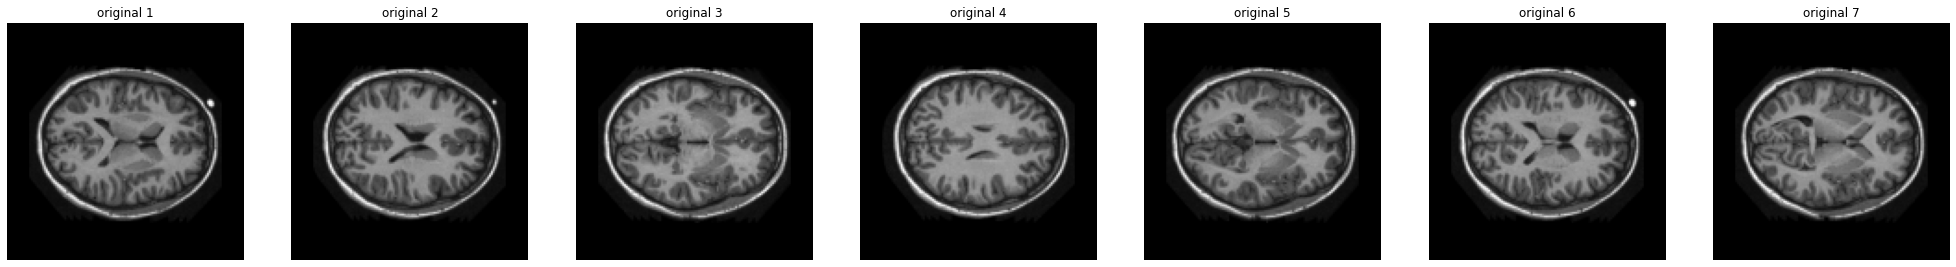

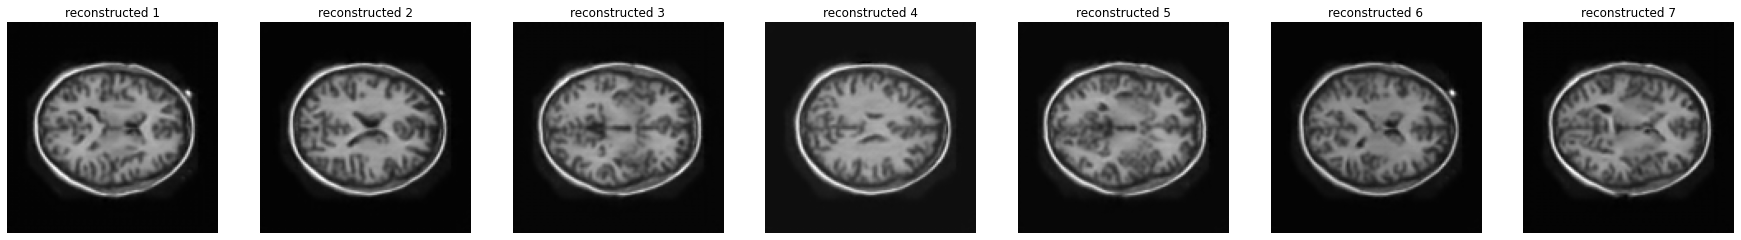

In [920]:
# valid_seq = OASISSeq(sorted(X_valid_files),sorted( y_valid_files), 20)
X_test, y_test = test_seq.__getitem__(1)



plt.figure(figsize=(5*9,5))
n = 9

idx = np.random.choice(len(X_test), 10)
# model_test = VQVAE()
for i in range(n-2):
    plt.subplot(1, n, i+1)
    plt.imshow(X_test[idx[i]], cmap='gray')
    plt.axis('off') 
    plt.title("original {}".format(i+1))
    
plt.figure(figsize=(5*8,5))    
for i in range(n-2):
    x = X_test[idx[i]:idx[i]+1]
    rec = model.predict(x)
    plt.subplot(1, n, i+1)
    plt.imshow(rec[0], cmap='gray')
    plt.axis('off') 
    plt.title("reconstructed {}".format(i+1))

In [979]:
los = np.load("./saves/oasis/losses/loss_1635636863.749701.npy", allow_pickle=True)

In [989]:
ssim_ = []
losses_ = []
for i, l in enumerate(los):
    losses_ += [l['loss'].numpy()]
    ssim_ += [l['ssim'].numpy()]

Text(0, 0.5, 'ssim')

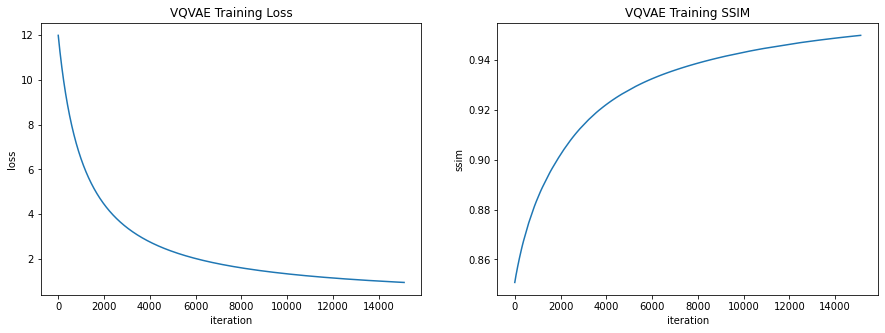

In [1028]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(losses_, label="loss")
plt.title("VQVAE Training Loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.subplot(1,2,2)
plt.plot(np.array(ssim_))
plt.title("VQVAE Training SSIM")
plt.xlabel("iteration")
plt.ylabel("ssim")

In [1033]:
from numpy import genfromtxt
my_data = genfromtxt('./data.csv', delimiter=',')

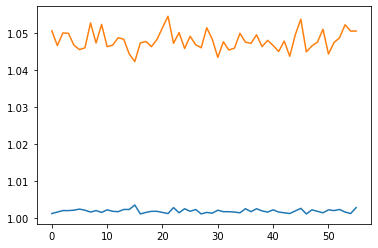

In [1039]:
plt.plot(my_data[:,0])
plt.plot(my_data[:,2])

In [1012]:
los = np.load("./saves/initial/losses/loss_1635519738.127423.npy", allow_pickle=True)

Text(0, 0.5, 'loss')

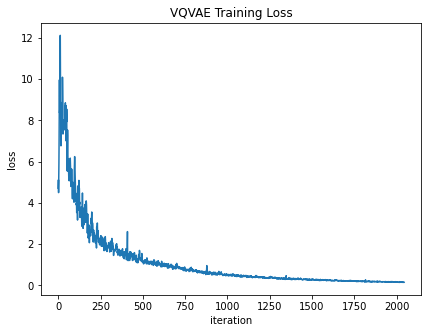

In [1032]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(los, label="loss")
plt.title("VQVAE Training Loss")
plt.xlabel("iteration")
plt.ylabel("loss")
# plt.subplot(1,2,2)
# plt.plot(np.array(ssim_))
# plt.title("VQVAE Training Loss")
# plt.xlabel("iteration")
# plt.ylabel("ssim")

Text(0, 0.5, 'ssim')

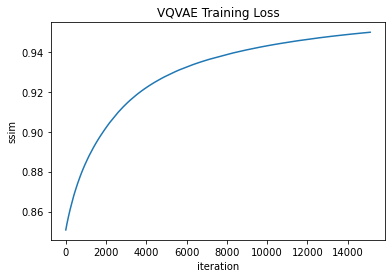

In [881]:
model = VQVAE()
model.build(input_shape=[1, width, height, 1])
print(model.summary())

Model: "vqvae_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  13936     
_________________________________________________________________
decoder (Decoder)            multiple                  22657     
_________________________________________________________________
vq_32 (VQ)                   multiple                  1024      
Total params: 37,617
Trainable params: 37,617
Non-trainable params: 0
_________________________________________________________________
None


In [859]:
valid_seq = OASISSeq(sorted(X_valid_files),sorted( y_valid_files), 20)
X_valid, y_valid = valid_seq.__getitem__(1)

In [933]:
folder="./saves/oasis/"
# get a list of saved models from file
saved_models_r = os.listdir(folder)
saved_models = sorted([".".join(saved_model.split(".")[0:-1]) for saved_model in saved_models_r])[187:]
saved_models = np.unique(saved_models)
# saved_models = saved_models[np.where(saved_models=='model_1_1635414388.8481214model_weights')[0][0]:]
saved_models = saved_models[::30]
saved_models = saved_models[2:]

0.9387247 0.935533
0.9563477 0.95651716
0.95670193 0.9576701
0.95696485 0.9575247
0.95629287 0.9568196
0.94075936 0.9392437


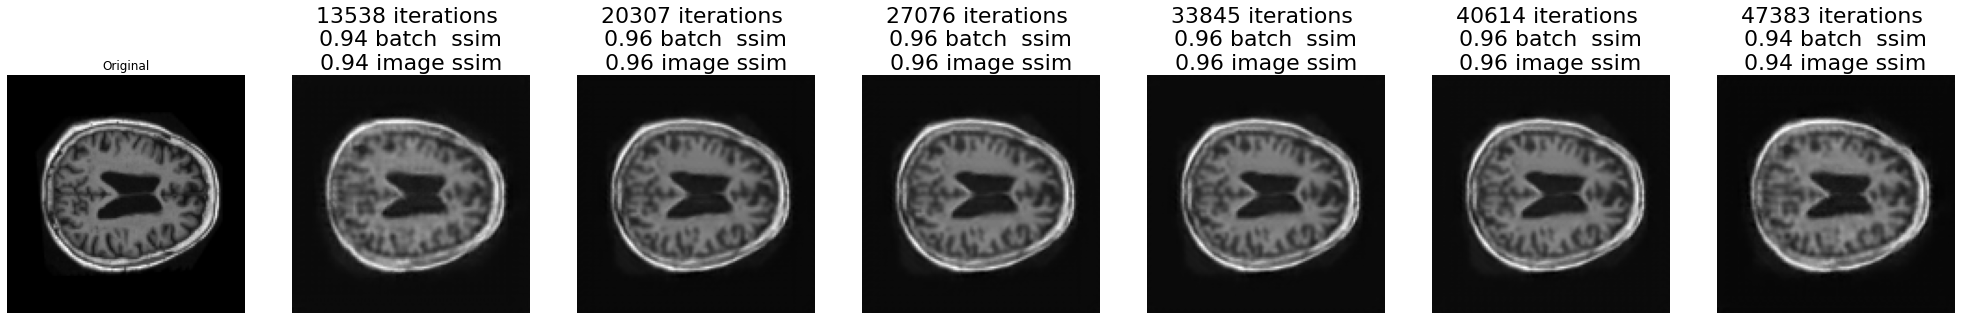

In [934]:
import os
plt.figure(figsize=(5*8,5))
n = 8
idx = 20
plt.subplot(1, n, 1)
plt.axis('off') 
plt.imshow(X_valid[idx],  cmap='gray')
plt.title("Original")

# model_test = VQVAE()
# folder="./saves/oasis/"
# # get a list of saved models from file
# saved_models_r = os.listdir(folder)
# saved_models = sorted([".".join(saved_model.split(".")[0:-1]) for saved_model in saved_models_r])[2:]
# saved_models = np.unique(saved_models)
# # saved_models = saved_models[np.where(saved_models=='model_1_1635414388.8481214model_weights')[0][0]:]
# saved_models = saved_models[::30]
# plot
for i in range(n-2):
    # model_test.build( input_shape=[10, 256, 256, 1])
    # print(model.summary())
    model.load_weights("./saves/oasis/"+saved_models[i])
    out1 = model(X_valid)
    valid_ssim = (tf.image.ssim(X_valid, out1, 3))
    avg_ssim = np.mean(valid_ssim)
    img_ssim = np.mean((tf.image.ssim(X_valid[idx:idx+1], out1[idx:idx+1], 3)))
    print(avg_ssim, img_ssim)
    plt.subplot(1, n, i+2)
    plt.imshow(out1[idx], cmap='gray')
    plt.axis('off') 
    plt.title("{} iterations \n{:.2f} batch  ssim\n{:.2f} image ssim".format(7*967*(i+2), avg_ssim, img_ssim), fontsize=22)
plt.savefig('figures/epoch_compare_recon_{}.png'.format(idx))

In [861]:
encoder = model.get_encoder()
decoder = model.get_decoder()
vq = model.get_vq()

# pixel model

In [862]:
pixel_cnn= PixelCNN()

# # train pixel cnn
pixel_cnn.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"])

# # runs=0
# folder = "./saves/oasis/pixelcnn/"
# model_name="pcnn"

In [946]:
pixel_cnn.load_weights("./saves/oasis/pixelcnn/pcnnR9E8_1635711787.0700958_model_weights")

# make data

In [547]:
train_seq_2 = OASISSeq(sorted(X_train_files),sorted( y_train_files), 256, downsample=128)
X_train_2, _ = train_seq_2.__getitem__(1)

In [572]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(X_train_2)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = make_indices(flat_enc_outputs, vq.emb)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")


Shape of the training data for PixelCNN: (256, 32, 32)


In [573]:
all_codebook_indices = codebook_indices
for i, X_data in enumerate(train_seq):
    encoded_outputs = encoder.predict(X_data)
    flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
    codebook_indices = make_indices(flat_enc_outputs, vq.emb)

    codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
    np.append(codebook_indices, all_codebook_indices, axis=0)
    if i>6:
        break
#     print("Saving")
#     np.save(save_folder+"cbindices_{}".format(i), codebook_indices)
    

Shape of the training data for PixelCNN: (60000, 7, 7)

In [376]:
save_folder = "./encoded_data/"

In [377]:
for i, X_data in enumerate(train_seq):
    print(i, x)
    break

0 KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='pixel_conv_layer_39/conv2d_308/Relu:0', description="created by layer 'pixel_conv_layer_39'")


In [566]:
for i, X_data in enumerate(train_seq):
    encoded_outputs = encoder.predict(X_data)
    flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
    codebook_indices = make_indices(flat_enc_outputs, vq.emb)

    codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
#     print("Saving")
    np.save(save_folder+"cbindices_{}".format(i), codebook_indices)
    

In [591]:
class CodeBookSeq(tf.keras.utils.Sequence):
    """
    Sequence to load OASIS dataset

    Based on this: https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
    and my own Demo 2 part 3 code
    """

    def __init__(self, x_set):
        """
        Initialises a data loader for a set of data
        x_set, y_set: set of file paths for x and y files
        batch_size: number of images in each batch
        """
        self.x = x_set# y_set
        self.batch_size = 1#batch_size
#         self.x_img_size=256
#         self.y_img_size=256
#         self.downsample = downsample

    def __len__(self):
        """ Returns length of batch set"""
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        """ Returns one batch of data, X and y as a tuple """
        # select set of file names that corrospond to index idx
        
        X_train_files = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         print(X_train_files)
        # open each file and load them into the list as an image
    
        X_train = np.load(X_train_files[0])
#         for file in X_train_files:
#             X_train.append(np.load(file))
       
            
#         # change label names from floats to ints
#         labels_o = np.unique(y_train)

#         # add an extra dimention 
#         X_train = np.array(X_train).reshape(-1, self.x_img_size, self.y_img_size, 1)
#         y_train = np.array(y_train).reshape(-1, self.x_img_size, self.y_img_size, 1)
        
#         # rename labels from floats to integers
#         y_train[np.where(y_train==labels_o[0])] = 0
#         y_train[np.where(y_train==labels_o[-1])] = 3
#         y_train[np.where(y_train==labels_o[1])] = 1
#         y_train[np.where(y_train==labels_o[2])] = 2 
        
#         # remove extra dimention in y now that labels are correct and cast as int
#         y_train = np.array(y_train).reshape(-1, self.x_img_size, self.y_img_size).astype(np.int32)
#         # print(y_train.dtype)
#         # should i return tensors or numpy arrays
#         if self.downsample:
# #             print("downsampling")
#             X_train = tf.image.resize(X_train, [self.downsample, self.downsample])
        return tf.constant(X_train), tf.constant(X_train)#, tf.constant(y_train)


In [592]:
list(data_dir.glob('./encoded_data/*'))

[WindowsPath('encoded_data/cbindices_0.npy'),
 WindowsPath('encoded_data/cbindices_1.npy'),
 WindowsPath('encoded_data/cbindices_10.npy'),
 WindowsPath('encoded_data/cbindices_100.npy'),
 WindowsPath('encoded_data/cbindices_101.npy'),
 WindowsPath('encoded_data/cbindices_102.npy'),
 WindowsPath('encoded_data/cbindices_103.npy'),
 WindowsPath('encoded_data/cbindices_104.npy'),
 WindowsPath('encoded_data/cbindices_105.npy'),
 WindowsPath('encoded_data/cbindices_106.npy'),
 WindowsPath('encoded_data/cbindices_107.npy'),
 WindowsPath('encoded_data/cbindices_108.npy'),
 WindowsPath('encoded_data/cbindices_109.npy'),
 WindowsPath('encoded_data/cbindices_11.npy'),
 WindowsPath('encoded_data/cbindices_110.npy'),
 WindowsPath('encoded_data/cbindices_111.npy'),
 WindowsPath('encoded_data/cbindices_112.npy'),
 WindowsPath('encoded_data/cbindices_113.npy'),
 WindowsPath('encoded_data/cbindices_114.npy'),
 WindowsPath('encoded_data/cbindices_115.npy'),
 WindowsPath('encoded_data/cbindices_116.npy')

In [594]:
data_dir = pathlib.Path("./")
codebook_files = list(data_dir.glob('./encoded_data/*'))


codebook_seq = CodeBookSeq(sorted(codebook_files))


# # print(X_train.__len__())
# print(tf.image.ssim(X_train[0], X_train[0], 3))
# print(tf.image.ssim(X_train[0], X_train[1], 3))


In [381]:
codebook_indices, _ = codebook_seq.__getitem__(0)

In [868]:
codebook_indices.shape

(64, 32, 32)

## training

In [869]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [620]:
runs=0

In [648]:
#DONOTEDUN
folder = "./saves/oasis/pixelcnn/"
model_name="pcnn"

runs+=1
num_hundreds = 15
import time
for i in range(num_hundreds):
    start = time.time()
    pixel_cnn.fit(
        codebook_seq,
    #     batch_size=20,
        epochs=500,
        validation_data=(codebook_indices, codebook_indices),
    )
    time_now = time.time()
    details_1 = "R{}E{}".format(runs, i)
    details_2 = "_{}_".format( time_now) 
    pixel_cnn.save_weights(folder+model_name+details_1+details_2+"model_weights")
    print("Epoch time", time.time()-start)

Epoch 1/500
151/151 [==============================] - 11s 71ms/step - loss: 1.0176 - accuracy: 0.6887 - val_loss: 1.0600 - val_accuracy: 0.6795
Epoch 2/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0179 - accuracy: 0.6886 - val_loss: 1.0593 - val_accuracy: 0.6783
Epoch 3/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0178 - accuracy: 0.6886 - val_loss: 1.0611 - val_accuracy: 0.6784
Epoch 4/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0176 - accuracy: 0.6887 - val_loss: 1.0582 - val_accuracy: 0.6786
Epoch 5/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0177 - accuracy: 0.6887 - val_loss: 1.0626 - val_accuracy: 0.6779
Epoch 6/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0187 - accuracy: 0.6884 - val_loss: 1.0583 - val_accuracy: 0.6790
Epoch 7/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0174 - accuracy: 0.6887 - val_loss: 1.0600 - val_accuracy

151/151 [==============================] - 5s 34ms/step - loss: 1.0173 - accuracy: 0.6888 - val_loss: 1.0601 - val_accuracy: 0.6786
Epoch 58/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0176 - accuracy: 0.6887 - val_loss: 1.0545 - val_accuracy: 0.6792
Epoch 59/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0173 - accuracy: 0.6887 - val_loss: 1.0633 - val_accuracy: 0.6779
Epoch 60/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0175 - accuracy: 0.6887 - val_loss: 1.0607 - val_accuracy: 0.6790
Epoch 61/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0176 - accuracy: 0.6888 - val_loss: 1.0627 - val_accuracy: 0.6782
Epoch 62/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0172 - accuracy: 0.6888 - val_loss: 1.0609 - val_accuracy: 0.6776
Epoch 63/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0173 - accuracy: 0.6887 - val_loss: 1.0662 - val_accuracy: 0.677

151/151 [==============================] - 5s 33ms/step - loss: 1.0167 - accuracy: 0.6889 - val_loss: 1.0651 - val_accuracy: 0.6777
Epoch 114/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0162 - accuracy: 0.6890 - val_loss: 1.0612 - val_accuracy: 0.6761
Epoch 115/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0161 - accuracy: 0.6891 - val_loss: 1.0591 - val_accuracy: 0.6775
Epoch 116/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0168 - accuracy: 0.6889 - val_loss: 1.0550 - val_accuracy: 0.6792
Epoch 117/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0164 - accuracy: 0.6890 - val_loss: 1.0571 - val_accuracy: 0.6790
Epoch 118/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0168 - accuracy: 0.6888 - val_loss: 1.0569 - val_accuracy: 0.6788
Epoch 119/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0174 - accuracy: 0.6887 - val_loss: 1.0549 - val_accuracy:

151/151 [==============================] - 5s 36ms/step - loss: 1.0160 - accuracy: 0.6891 - val_loss: 1.0540 - val_accuracy: 0.6801
Epoch 170/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0168 - accuracy: 0.6889 - val_loss: 1.0570 - val_accuracy: 0.6791
Epoch 171/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0155 - accuracy: 0.6893 - val_loss: 1.0592 - val_accuracy: 0.6784
Epoch 172/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0152 - accuracy: 0.6894 - val_loss: 1.0555 - val_accuracy: 0.6789
Epoch 173/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0162 - accuracy: 0.6891 - val_loss: 1.0571 - val_accuracy: 0.6790
Epoch 174/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0165 - accuracy: 0.6889 - val_loss: 1.0655 - val_accuracy: 0.6764
Epoch 175/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0162 - accuracy: 0.6891 - val_loss: 1.0591 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0164 - accuracy: 0.6890 - val_loss: 1.0570 - val_accuracy: 0.6788
Epoch 226/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0157 - accuracy: 0.6893 - val_loss: 1.0548 - val_accuracy: 0.6798
Epoch 227/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0149 - accuracy: 0.6894 - val_loss: 1.0566 - val_accuracy: 0.6776
Epoch 228/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0165 - accuracy: 0.6889 - val_loss: 1.0514 - val_accuracy: 0.6804
Epoch 229/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0154 - accuracy: 0.6893 - val_loss: 1.0534 - val_accuracy: 0.6791
Epoch 230/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0165 - accuracy: 0.6889 - val_loss: 1.0576 - val_accuracy: 0.6788
Epoch 231/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0164 - accuracy: 0.6890 - val_loss: 1.0596 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0146 - accuracy: 0.6895 - val_loss: 1.0584 - val_accuracy: 0.6774
Epoch 282/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0148 - accuracy: 0.6895 - val_loss: 1.0637 - val_accuracy: 0.6773
Epoch 283/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0156 - accuracy: 0.6893 - val_loss: 1.0569 - val_accuracy: 0.6793
Epoch 284/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0149 - accuracy: 0.6893 - val_loss: 1.0534 - val_accuracy: 0.6802
Epoch 285/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0159 - accuracy: 0.6892 - val_loss: 1.0536 - val_accuracy: 0.6806
Epoch 286/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0156 - accuracy: 0.6891 - val_loss: 1.0558 - val_accuracy: 0.6797
Epoch 287/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0153 - accuracy: 0.6893 - val_loss: 1.0583 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0155 - accuracy: 0.6892 - val_loss: 1.0534 - val_accuracy: 0.6802
Epoch 338/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0147 - accuracy: 0.6895 - val_loss: 1.0553 - val_accuracy: 0.6783
Epoch 339/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0152 - accuracy: 0.6894 - val_loss: 1.0603 - val_accuracy: 0.6789
Epoch 340/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0155 - accuracy: 0.6892 - val_loss: 1.0628 - val_accuracy: 0.6779
Epoch 341/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0149 - accuracy: 0.6894 - val_loss: 1.0584 - val_accuracy: 0.6783
Epoch 342/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0149 - accuracy: 0.6894 - val_loss: 1.0549 - val_accuracy: 0.6795
Epoch 343/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0142 - accuracy: 0.6897 - val_loss: 1.0552 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0140 - accuracy: 0.6897 - val_loss: 1.0602 - val_accuracy: 0.6780
Epoch 394/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0143 - accuracy: 0.6896 - val_loss: 1.0568 - val_accuracy: 0.6799
Epoch 395/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0147 - accuracy: 0.6894 - val_loss: 1.0566 - val_accuracy: 0.6793
Epoch 396/500
151/151 [==============================] - 6s 39ms/step - loss: 1.0139 - accuracy: 0.6897 - val_loss: 1.0556 - val_accuracy: 0.6798
Epoch 397/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0141 - accuracy: 0.6895 - val_loss: 1.0554 - val_accuracy: 0.6801
Epoch 398/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0145 - accuracy: 0.6896 - val_loss: 1.0591 - val_accuracy: 0.6793
Epoch 399/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0140 - accuracy: 0.6896 - val_loss: 1.0517 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0131 - accuracy: 0.6898 - val_loss: 1.0584 - val_accuracy: 0.6788
Epoch 450/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0148 - accuracy: 0.6895 - val_loss: 1.0617 - val_accuracy: 0.6778
Epoch 451/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0147 - accuracy: 0.6894 - val_loss: 1.0601 - val_accuracy: 0.6778
Epoch 452/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0135 - accuracy: 0.6899 - val_loss: 1.0584 - val_accuracy: 0.6786
Epoch 453/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0140 - accuracy: 0.6896 - val_loss: 1.0607 - val_accuracy: 0.6775
Epoch 454/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0135 - accuracy: 0.6897 - val_loss: 1.0607 - val_accuracy: 0.6774
Epoch 455/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0143 - accuracy: 0.6896 - val_loss: 1.0603 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0139 - accuracy: 0.6897 - val_loss: 1.0538 - val_accuracy: 0.6807
Epoch 6/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0134 - accuracy: 0.6898 - val_loss: 1.0555 - val_accuracy: 0.6790
Epoch 7/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0137 - accuracy: 0.6898 - val_loss: 1.0544 - val_accuracy: 0.6786
Epoch 8/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0132 - accuracy: 0.6899 - val_loss: 1.0531 - val_accuracy: 0.6808
Epoch 9/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0146 - accuracy: 0.6894 - val_loss: 1.0633 - val_accuracy: 0.6786
Epoch 10/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0135 - accuracy: 0.6899 - val_loss: 1.0577 - val_accuracy: 0.6783
Epoch 11/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0134 - accuracy: 0.6898 - val_loss: 1.0547 - val_accuracy: 0.6797
Ep

151/151 [==============================] - 5s 34ms/step - loss: 1.0128 - accuracy: 0.6899 - val_loss: 1.0563 - val_accuracy: 0.6791
Epoch 62/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0133 - accuracy: 0.6898 - val_loss: 1.0536 - val_accuracy: 0.6802
Epoch 63/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0131 - accuracy: 0.6898 - val_loss: 1.0531 - val_accuracy: 0.6804
Epoch 64/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0136 - accuracy: 0.6897 - val_loss: 1.0627 - val_accuracy: 0.6782
Epoch 65/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0123 - accuracy: 0.6901 - val_loss: 1.0588 - val_accuracy: 0.6787
Epoch 66/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0132 - accuracy: 0.6898 - val_loss: 1.0578 - val_accuracy: 0.6791
Epoch 67/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0138 - accuracy: 0.6898 - val_loss: 1.0635 - val_accuracy: 0.677

151/151 [==============================] - 5s 34ms/step - loss: 1.0134 - accuracy: 0.6898 - val_loss: 1.0619 - val_accuracy: 0.6773
Epoch 118/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0124 - accuracy: 0.6900 - val_loss: 1.0545 - val_accuracy: 0.6789
Epoch 119/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0126 - accuracy: 0.6901 - val_loss: 1.0582 - val_accuracy: 0.6789
Epoch 120/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0126 - accuracy: 0.6900 - val_loss: 1.0518 - val_accuracy: 0.6808
Epoch 121/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0132 - accuracy: 0.6899 - val_loss: 1.0515 - val_accuracy: 0.6799
Epoch 122/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0127 - accuracy: 0.6900 - val_loss: 1.0602 - val_accuracy: 0.6779
Epoch 123/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0135 - accuracy: 0.6898 - val_loss: 1.0561 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0123 - accuracy: 0.6901 - val_loss: 1.0574 - val_accuracy: 0.6778
Epoch 174/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0136 - accuracy: 0.6898 - val_loss: 1.0581 - val_accuracy: 0.6784
Epoch 175/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0126 - accuracy: 0.6900 - val_loss: 1.0563 - val_accuracy: 0.6789
Epoch 176/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0126 - accuracy: 0.6899 - val_loss: 1.0552 - val_accuracy: 0.6796
Epoch 177/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0124 - accuracy: 0.6900 - val_loss: 1.0581 - val_accuracy: 0.6785
Epoch 178/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0122 - accuracy: 0.6901 - val_loss: 1.0548 - val_accuracy: 0.6797
Epoch 179/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0131 - accuracy: 0.6899 - val_loss: 1.0519 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0118 - accuracy: 0.6901 - val_loss: 1.0568 - val_accuracy: 0.6797
Epoch 230/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0119 - accuracy: 0.6903 - val_loss: 1.0530 - val_accuracy: 0.6810
Epoch 231/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0118 - accuracy: 0.6902 - val_loss: 1.0549 - val_accuracy: 0.6803
Epoch 232/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0131 - accuracy: 0.6898 - val_loss: 1.0570 - val_accuracy: 0.6783
Epoch 233/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0124 - accuracy: 0.6901 - val_loss: 1.0554 - val_accuracy: 0.6792
Epoch 234/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0133 - accuracy: 0.6898 - val_loss: 1.0555 - val_accuracy: 0.6795
Epoch 235/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0123 - accuracy: 0.6901 - val_loss: 1.0550 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0124 - accuracy: 0.6901 - val_loss: 1.0545 - val_accuracy: 0.6793
Epoch 286/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0119 - accuracy: 0.6902 - val_loss: 1.0521 - val_accuracy: 0.6799
Epoch 287/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0121 - accuracy: 0.6902 - val_loss: 1.0503 - val_accuracy: 0.6796
Epoch 288/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0119 - accuracy: 0.6903 - val_loss: 1.0531 - val_accuracy: 0.6797
Epoch 289/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0122 - accuracy: 0.6901 - val_loss: 1.0567 - val_accuracy: 0.6788
Epoch 290/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0109 - accuracy: 0.6906 - val_loss: 1.0565 - val_accuracy: 0.6796
Epoch 291/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0115 - accuracy: 0.6903 - val_loss: 1.0575 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0129 - accuracy: 0.6900 - val_loss: 1.0564 - val_accuracy: 0.6796
Epoch 342/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0118 - accuracy: 0.6902 - val_loss: 1.0609 - val_accuracy: 0.6787
Epoch 343/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0117 - accuracy: 0.6903 - val_loss: 1.0632 - val_accuracy: 0.6769
Epoch 344/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0115 - accuracy: 0.6903 - val_loss: 1.0551 - val_accuracy: 0.6801
Epoch 345/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0115 - accuracy: 0.6903 - val_loss: 1.0539 - val_accuracy: 0.6802
Epoch 346/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0111 - accuracy: 0.6905 - val_loss: 1.0609 - val_accuracy: 0.6785
Epoch 347/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0124 - accuracy: 0.6901 - val_loss: 1.0538 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0107 - accuracy: 0.6905 - val_loss: 1.0571 - val_accuracy: 0.6785
Epoch 398/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0120 - accuracy: 0.6901 - val_loss: 1.0550 - val_accuracy: 0.6797
Epoch 399/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0113 - accuracy: 0.6904 - val_loss: 1.0533 - val_accuracy: 0.6804
Epoch 400/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0115 - accuracy: 0.6902 - val_loss: 1.0524 - val_accuracy: 0.6803
Epoch 401/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0120 - accuracy: 0.6902 - val_loss: 1.0544 - val_accuracy: 0.6799
Epoch 402/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0124 - accuracy: 0.6902 - val_loss: 1.0535 - val_accuracy: 0.6810
Epoch 403/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0114 - accuracy: 0.6904 - val_loss: 1.0554 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0116 - accuracy: 0.6902 - val_loss: 1.0520 - val_accuracy: 0.6812
Epoch 454/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0110 - accuracy: 0.6904 - val_loss: 1.0516 - val_accuracy: 0.6804
Epoch 455/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0105 - accuracy: 0.6907 - val_loss: 1.0524 - val_accuracy: 0.6806
Epoch 456/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0114 - accuracy: 0.6904 - val_loss: 1.0674 - val_accuracy: 0.6777
Epoch 457/500
151/151 [==============================] - 6s 41ms/step - loss: 1.0116 - accuracy: 0.6903 - val_loss: 1.0575 - val_accuracy: 0.6790
Epoch 458/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0104 - accuracy: 0.6906 - val_loss: 1.0508 - val_accuracy: 0.6813
Epoch 459/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0104 - accuracy: 0.6906 - val_loss: 1.0564 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0103 - accuracy: 0.6906 - val_loss: 1.0579 - val_accuracy: 0.6794
Epoch 10/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0114 - accuracy: 0.6903 - val_loss: 1.0554 - val_accuracy: 0.6795
Epoch 11/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0114 - accuracy: 0.6904 - val_loss: 1.0492 - val_accuracy: 0.6815
Epoch 12/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0108 - accuracy: 0.6905 - val_loss: 1.0542 - val_accuracy: 0.6794
Epoch 13/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0117 - accuracy: 0.6902 - val_loss: 1.0565 - val_accuracy: 0.6791
Epoch 14/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0106 - accuracy: 0.6905 - val_loss: 1.0518 - val_accuracy: 0.6808
Epoch 15/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0105 - accuracy: 0.6905 - val_loss: 1.0571 - val_accuracy: 0.678

151/151 [==============================] - 5s 34ms/step - loss: 1.0110 - accuracy: 0.6904 - val_loss: 1.0565 - val_accuracy: 0.6792
Epoch 66/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0102 - accuracy: 0.6907 - val_loss: 1.0530 - val_accuracy: 0.6796
Epoch 67/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0104 - accuracy: 0.6906 - val_loss: 1.0565 - val_accuracy: 0.6783
Epoch 68/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0103 - accuracy: 0.6907 - val_loss: 1.0557 - val_accuracy: 0.6788
Epoch 69/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0108 - accuracy: 0.6905 - val_loss: 1.0550 - val_accuracy: 0.6788
Epoch 70/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0109 - accuracy: 0.6905 - val_loss: 1.0516 - val_accuracy: 0.6799
Epoch 71/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0099 - accuracy: 0.6908 - val_loss: 1.0542 - val_accuracy: 0.679

151/151 [==============================] - 5s 34ms/step - loss: 1.0101 - accuracy: 0.6906 - val_loss: 1.0588 - val_accuracy: 0.6780
Epoch 122/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0100 - accuracy: 0.6908 - val_loss: 1.0554 - val_accuracy: 0.6812
Epoch 123/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0107 - accuracy: 0.6906 - val_loss: 1.0583 - val_accuracy: 0.6779
Epoch 124/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0104 - accuracy: 0.6906 - val_loss: 1.0482 - val_accuracy: 0.6806
Epoch 125/500
151/151 [==============================] - ETA: 0s - loss: 1.0097 - accuracy: 0.69 - 5s 34ms/step - loss: 1.0099 - accuracy: 0.6908 - val_loss: 1.0536 - val_accuracy: 0.6796
Epoch 126/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0100 - accuracy: 0.6908 - val_loss: 1.0569 - val_accuracy: 0.6788
Epoch 127/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0096 - accuracy:

Epoch 177/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0110 - accuracy: 0.6904 - val_loss: 1.0528 - val_accuracy: 0.6790
Epoch 178/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0096 - accuracy: 0.6908 - val_loss: 1.0577 - val_accuracy: 0.6787
Epoch 179/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0105 - accuracy: 0.6906 - val_loss: 1.0560 - val_accuracy: 0.6795
Epoch 180/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0095 - accuracy: 0.6909 - val_loss: 1.0559 - val_accuracy: 0.6799
Epoch 181/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0106 - accuracy: 0.6906 - val_loss: 1.0546 - val_accuracy: 0.6791
Epoch 182/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0100 - accuracy: 0.6907 - val_loss: 1.0549 - val_accuracy: 0.6784
Epoch 183/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0099 - accuracy: 0.6906 - val_loss: 1.0528 -

151/151 [==============================] - 5s 35ms/step - loss: 1.0099 - accuracy: 0.6907 - val_loss: 1.0558 - val_accuracy: 0.6798
Epoch 234/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0094 - accuracy: 0.6909 - val_loss: 1.0543 - val_accuracy: 0.6795
Epoch 235/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0099 - accuracy: 0.6908 - val_loss: 1.0507 - val_accuracy: 0.6812
Epoch 236/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0105 - accuracy: 0.6905 - val_loss: 1.0530 - val_accuracy: 0.6795
Epoch 237/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0098 - accuracy: 0.6908 - val_loss: 1.0528 - val_accuracy: 0.6795
Epoch 238/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0092 - accuracy: 0.6910 - val_loss: 1.0518 - val_accuracy: 0.6804
Epoch 239/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0093 - accuracy: 0.6909 - val_loss: 1.0565 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0095 - accuracy: 0.6908 - val_loss: 1.0562 - val_accuracy: 0.6800
Epoch 290/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0089 - accuracy: 0.6910 - val_loss: 1.0515 - val_accuracy: 0.6797
Epoch 291/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0097 - accuracy: 0.6909 - val_loss: 1.0514 - val_accuracy: 0.6798
Epoch 292/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0086 - accuracy: 0.6911 - val_loss: 1.0524 - val_accuracy: 0.6808
Epoch 293/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0104 - accuracy: 0.6906 - val_loss: 1.0541 - val_accuracy: 0.6795
Epoch 294/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0095 - accuracy: 0.6909 - val_loss: 1.0511 - val_accuracy: 0.6797
Epoch 295/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0093 - accuracy: 0.6909 - val_loss: 1.0503 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0093 - accuracy: 0.6910 - val_loss: 1.0519 - val_accuracy: 0.6797
Epoch 346/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0084 - accuracy: 0.6911 - val_loss: 1.0524 - val_accuracy: 0.6790
Epoch 347/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0095 - accuracy: 0.6908 - val_loss: 1.0501 - val_accuracy: 0.6812
Epoch 348/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0092 - accuracy: 0.6910 - val_loss: 1.0549 - val_accuracy: 0.6794
Epoch 349/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0096 - accuracy: 0.6909 - val_loss: 1.0568 - val_accuracy: 0.6797
Epoch 350/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0100 - accuracy: 0.6908 - val_loss: 1.0550 - val_accuracy: 0.6806
Epoch 351/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0087 - accuracy: 0.6911 - val_loss: 1.0537 - val_accuracy:

Epoch 401/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0087 - accuracy: 0.6912 - val_loss: 1.0554 - val_accuracy: 0.6791
Epoch 402/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0090 - accuracy: 0.6910 - val_loss: 1.0545 - val_accuracy: 0.6798
Epoch 403/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0088 - accuracy: 0.6911 - val_loss: 1.0574 - val_accuracy: 0.6793
Epoch 404/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0099 - accuracy: 0.6908 - val_loss: 1.0508 - val_accuracy: 0.6816
Epoch 405/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0085 - accuracy: 0.6911 - val_loss: 1.0543 - val_accuracy: 0.6788
Epoch 406/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0092 - accuracy: 0.6910 - val_loss: 1.0539 - val_accuracy: 0.6791
Epoch 407/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0090 - accuracy: 0.6910 - val_loss: 1.0552 -

151/151 [==============================] - 5s 34ms/step - loss: 1.0087 - accuracy: 0.6911 - val_loss: 1.0523 - val_accuracy: 0.6803
Epoch 458/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0088 - accuracy: 0.6913 - val_loss: 1.0595 - val_accuracy: 0.6775
Epoch 459/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0091 - accuracy: 0.6909 - val_loss: 1.0510 - val_accuracy: 0.6810
Epoch 460/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0098 - accuracy: 0.6909 - val_loss: 1.0513 - val_accuracy: 0.6808
Epoch 461/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0083 - accuracy: 0.6911 - val_loss: 1.0503 - val_accuracy: 0.6806
Epoch 462/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0087 - accuracy: 0.6912 - val_loss: 1.0499 - val_accuracy: 0.6804
Epoch 463/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0099 - accuracy: 0.6907 - val_loss: 1.0551 - val_accuracy:

Epoch 13/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0091 - accuracy: 0.6910 - val_loss: 1.0499 - val_accuracy: 0.6804
Epoch 14/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0083 - accuracy: 0.6913 - val_loss: 1.0499 - val_accuracy: 0.6810
Epoch 15/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0096 - accuracy: 0.6908 - val_loss: 1.0521 - val_accuracy: 0.6796
Epoch 16/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0081 - accuracy: 0.6913 - val_loss: 1.0533 - val_accuracy: 0.6792
Epoch 17/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0083 - accuracy: 0.6912 - val_loss: 1.0566 - val_accuracy: 0.6780
Epoch 18/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0090 - accuracy: 0.6911 - val_loss: 1.0590 - val_accuracy: 0.6782
Epoch 19/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0082 - accuracy: 0.6912 - val_loss: 1.0507 - val_ac

151/151 [==============================] - 5s 34ms/step - loss: 1.0084 - accuracy: 0.6913 - val_loss: 1.0560 - val_accuracy: 0.6801
Epoch 70/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0080 - accuracy: 0.6912 - val_loss: 1.0522 - val_accuracy: 0.6797
Epoch 71/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0083 - accuracy: 0.6912 - val_loss: 1.0557 - val_accuracy: 0.6795
Epoch 72/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0094 - accuracy: 0.6909 - val_loss: 1.0560 - val_accuracy: 0.6796
Epoch 73/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0079 - accuracy: 0.6913 - val_loss: 1.0576 - val_accuracy: 0.6796
Epoch 74/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0087 - accuracy: 0.6911 - val_loss: 1.0504 - val_accuracy: 0.6809
Epoch 75/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0081 - accuracy: 0.6913 - val_loss: 1.0524 - val_accuracy: 0.680

151/151 [==============================] - 5s 34ms/step - loss: 1.0081 - accuracy: 0.6913 - val_loss: 1.0459 - val_accuracy: 0.6823
Epoch 126/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0082 - accuracy: 0.6912 - val_loss: 1.0523 - val_accuracy: 0.6800
Epoch 127/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0079 - accuracy: 0.6914 - val_loss: 1.0526 - val_accuracy: 0.6796
Epoch 128/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0081 - accuracy: 0.6913 - val_loss: 1.0539 - val_accuracy: 0.6814
Epoch 129/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0076 - accuracy: 0.6914 - val_loss: 1.0512 - val_accuracy: 0.6808
Epoch 130/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0084 - accuracy: 0.6913 - val_loss: 1.0567 - val_accuracy: 0.6789
Epoch 131/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0077 - accuracy: 0.6914 - val_loss: 1.0557 - val_accuracy:

Epoch 181/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0079 - accuracy: 0.6914 - val_loss: 1.0531 - val_accuracy: 0.6799
Epoch 182/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0076 - accuracy: 0.6914 - val_loss: 1.0541 - val_accuracy: 0.6806
Epoch 183/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0084 - accuracy: 0.6912 - val_loss: 1.0527 - val_accuracy: 0.6791
Epoch 184/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0081 - accuracy: 0.6913 - val_loss: 1.0480 - val_accuracy: 0.6817
Epoch 185/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0082 - accuracy: 0.6913 - val_loss: 1.0487 - val_accuracy: 0.6821
Epoch 186/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0079 - accuracy: 0.6914 - val_loss: 1.0479 - val_accuracy: 0.6819
Epoch 187/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0075 - accuracy: 0.6915 - val_loss: 1.0538 -

151/151 [==============================] - 5s 33ms/step - loss: 1.0082 - accuracy: 0.6913 - val_loss: 1.0545 - val_accuracy: 0.6798
Epoch 238/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0082 - accuracy: 0.6913 - val_loss: 1.0582 - val_accuracy: 0.6794
Epoch 239/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0077 - accuracy: 0.6914 - val_loss: 1.0501 - val_accuracy: 0.6794
Epoch 240/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0078 - accuracy: 0.6914 - val_loss: 1.0538 - val_accuracy: 0.6816
Epoch 241/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0083 - accuracy: 0.6912 - val_loss: 1.0533 - val_accuracy: 0.6799
Epoch 242/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0081 - accuracy: 0.6913 - val_loss: 1.0512 - val_accuracy: 0.6805
Epoch 243/500
151/151 [==============================] - 6s 37ms/step - loss: 1.0087 - accuracy: 0.6911 - val_loss: 1.0546 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0081 - accuracy: 0.6913 - val_loss: 1.0515 - val_accuracy: 0.6798
Epoch 294/500
151/151 [==============================] - 7s 45ms/step - loss: 1.0079 - accuracy: 0.6914 - val_loss: 1.0546 - val_accuracy: 0.6796
Epoch 295/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0077 - accuracy: 0.6915 - val_loss: 1.0484 - val_accuracy: 0.6815
Epoch 296/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0071 - accuracy: 0.6916 - val_loss: 1.0533 - val_accuracy: 0.6801
Epoch 297/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0076 - accuracy: 0.6915 - val_loss: 1.0544 - val_accuracy: 0.6802
Epoch 298/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0087 - accuracy: 0.6912 - val_loss: 1.0560 - val_accuracy: 0.6807
Epoch 299/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0075 - accuracy: 0.6915 - val_loss: 1.0570 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0090 - accuracy: 0.6910 - val_loss: 1.0459 - val_accuracy: 0.6819
Epoch 350/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0071 - accuracy: 0.6916 - val_loss: 1.0477 - val_accuracy: 0.6817
Epoch 351/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0076 - accuracy: 0.6915 - val_loss: 1.0511 - val_accuracy: 0.6809
Epoch 352/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0082 - accuracy: 0.6913 - val_loss: 1.0534 - val_accuracy: 0.6806
Epoch 353/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0070 - accuracy: 0.6917 - val_loss: 1.0557 - val_accuracy: 0.6794
Epoch 354/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0067 - accuracy: 0.6918 - val_loss: 1.0527 - val_accuracy: 0.6807
Epoch 355/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0076 - accuracy: 0.6915 - val_loss: 1.0500 - val_accuracy:

151/151 [==============================] - 5s 35ms/step - loss: 1.0077 - accuracy: 0.6914 - val_loss: 1.0522 - val_accuracy: 0.6805
Epoch 406/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0074 - accuracy: 0.6915 - val_loss: 1.0532 - val_accuracy: 0.6802
Epoch 407/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0076 - accuracy: 0.6916 - val_loss: 1.0466 - val_accuracy: 0.6822
Epoch 408/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0076 - accuracy: 0.6915 - val_loss: 1.0548 - val_accuracy: 0.6797
Epoch 409/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0075 - accuracy: 0.6915 - val_loss: 1.0530 - val_accuracy: 0.6794
Epoch 410/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0074 - accuracy: 0.6915 - val_loss: 1.0544 - val_accuracy: 0.6790
Epoch 411/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0074 - accuracy: 0.6914 - val_loss: 1.0574 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0075 - accuracy: 0.6916 - val_loss: 1.0520 - val_accuracy: 0.6817
Epoch 462/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0070 - accuracy: 0.6916 - val_loss: 1.0535 - val_accuracy: 0.6801
Epoch 463/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0070 - accuracy: 0.6917 - val_loss: 1.0534 - val_accuracy: 0.6800
Epoch 464/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0072 - accuracy: 0.6916 - val_loss: 1.0495 - val_accuracy: 0.6814
Epoch 465/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0077 - accuracy: 0.6914 - val_loss: 1.0555 - val_accuracy: 0.6779
Epoch 466/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0075 - accuracy: 0.6915 - val_loss: 1.0505 - val_accuracy: 0.6808
Epoch 467/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0075 - accuracy: 0.6915 - val_loss: 1.0545 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0068 - accuracy: 0.6917 - val_loss: 1.0498 - val_accuracy: 0.6799
Epoch 18/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0065 - accuracy: 0.6919 - val_loss: 1.0581 - val_accuracy: 0.6790
Epoch 19/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0076 - accuracy: 0.6914 - val_loss: 1.0518 - val_accuracy: 0.6799
Epoch 20/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0071 - accuracy: 0.6917 - val_loss: 1.0516 - val_accuracy: 0.6810
Epoch 21/500
151/151 [==============================] - 7s 46ms/step - loss: 1.0073 - accuracy: 0.6915 - val_loss: 1.0549 - val_accuracy: 0.6809
Epoch 22/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0070 - accuracy: 0.6915 - val_loss: 1.0480 - val_accuracy: 0.6816
Epoch 23/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0071 - accuracy: 0.6917 - val_loss: 1.0532 - val_accuracy: 0.679

151/151 [==============================] - 5s 33ms/step - loss: 1.0068 - accuracy: 0.6916 - val_loss: 1.0502 - val_accuracy: 0.6792
Epoch 74/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0068 - accuracy: 0.6917 - val_loss: 1.0443 - val_accuracy: 0.6826
Epoch 75/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0067 - accuracy: 0.6918 - val_loss: 1.0536 - val_accuracy: 0.6801
Epoch 76/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0075 - accuracy: 0.6915 - val_loss: 1.0482 - val_accuracy: 0.6798
Epoch 77/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0065 - accuracy: 0.6919 - val_loss: 1.0509 - val_accuracy: 0.6801
Epoch 78/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0071 - accuracy: 0.6916 - val_loss: 1.0541 - val_accuracy: 0.6797
Epoch 79/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0070 - accuracy: 0.6917 - val_loss: 1.0554 - val_accuracy: 0.677

151/151 [==============================] - 5s 33ms/step - loss: 1.0070 - accuracy: 0.6917 - val_loss: 1.0550 - val_accuracy: 0.6793
Epoch 130/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0074 - accuracy: 0.6916 - val_loss: 1.0567 - val_accuracy: 0.6796
Epoch 131/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0067 - accuracy: 0.6917 - val_loss: 1.0532 - val_accuracy: 0.6794
Epoch 132/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0063 - accuracy: 0.6918 - val_loss: 1.0494 - val_accuracy: 0.6799
Epoch 133/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0072 - accuracy: 0.6916 - val_loss: 1.0553 - val_accuracy: 0.6795
Epoch 134/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0073 - accuracy: 0.6915 - val_loss: 1.0578 - val_accuracy: 0.6788
Epoch 135/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0066 - accuracy: 0.6918 - val_loss: 1.0518 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0062 - accuracy: 0.6920 - val_loss: 1.0488 - val_accuracy: 0.6808
Epoch 186/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0062 - accuracy: 0.6919 - val_loss: 1.0523 - val_accuracy: 0.6815
Epoch 187/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0059 - accuracy: 0.6919 - val_loss: 1.0511 - val_accuracy: 0.6812
Epoch 188/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0074 - accuracy: 0.6915 - val_loss: 1.0482 - val_accuracy: 0.6808
Epoch 189/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0063 - accuracy: 0.6918 - val_loss: 1.0524 - val_accuracy: 0.6810
Epoch 190/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0069 - accuracy: 0.6916 - val_loss: 1.0479 - val_accuracy: 0.6814
Epoch 191/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0066 - accuracy: 0.6917 - val_loss: 1.0510 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0064 - accuracy: 0.6918 - val_loss: 1.0509 - val_accuracy: 0.6802
Epoch 242/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0059 - accuracy: 0.6919 - val_loss: 1.0479 - val_accuracy: 0.6804
Epoch 243/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0064 - accuracy: 0.6919 - val_loss: 1.0529 - val_accuracy: 0.6798
Epoch 244/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0060 - accuracy: 0.6918 - val_loss: 1.0514 - val_accuracy: 0.6793
Epoch 245/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0074 - accuracy: 0.6915 - val_loss: 1.0523 - val_accuracy: 0.6791
Epoch 246/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0062 - accuracy: 0.6918 - val_loss: 1.0510 - val_accuracy: 0.6805
Epoch 247/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0070 - accuracy: 0.6916 - val_loss: 1.0531 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0069 - accuracy: 0.6917 - val_loss: 1.0478 - val_accuracy: 0.6812
Epoch 298/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0061 - accuracy: 0.6919 - val_loss: 1.0511 - val_accuracy: 0.6798
Epoch 299/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0069 - accuracy: 0.6917 - val_loss: 1.0503 - val_accuracy: 0.6818
Epoch 300/500
151/151 [==============================] - 7s 46ms/step - loss: 1.0065 - accuracy: 0.6919 - val_loss: 1.0509 - val_accuracy: 0.6807
Epoch 301/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0065 - accuracy: 0.6918 - val_loss: 1.0534 - val_accuracy: 0.6802
Epoch 302/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0057 - accuracy: 0.6920 - val_loss: 1.0484 - val_accuracy: 0.6804
Epoch 303/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0061 - accuracy: 0.6919 - val_loss: 1.0538 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0063 - accuracy: 0.6918 - val_loss: 1.0515 - val_accuracy: 0.6792
Epoch 354/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0063 - accuracy: 0.6919 - val_loss: 1.0559 - val_accuracy: 0.6784
Epoch 355/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0054 - accuracy: 0.6921 - val_loss: 1.0509 - val_accuracy: 0.6804
Epoch 356/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0056 - accuracy: 0.6920 - val_loss: 1.0512 - val_accuracy: 0.6799
Epoch 357/500
151/151 [==============================] - ETA: 0s - loss: 1.0062 - accuracy: 0.69 - 5s 34ms/step - loss: 1.0062 - accuracy: 0.6919 - val_loss: 1.0558 - val_accuracy: 0.6791
Epoch 358/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0064 - accuracy: 0.6918 - val_loss: 1.0531 - val_accuracy: 0.6796
Epoch 359/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0064 - accuracy:

Epoch 409/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0055 - accuracy: 0.6921 - val_loss: 1.0468 - val_accuracy: 0.6817
Epoch 410/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0070 - accuracy: 0.6918 - val_loss: 1.0567 - val_accuracy: 0.6785
Epoch 411/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0067 - accuracy: 0.6918 - val_loss: 1.0561 - val_accuracy: 0.6796
Epoch 412/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0061 - accuracy: 0.6919 - val_loss: 1.0477 - val_accuracy: 0.6813
Epoch 413/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0061 - accuracy: 0.6919 - val_loss: 1.0526 - val_accuracy: 0.6799
Epoch 414/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0059 - accuracy: 0.6920 - val_loss: 1.0489 - val_accuracy: 0.6806
Epoch 415/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0058 - accuracy: 0.6920 - val_loss: 1.0524 -

151/151 [==============================] - 5s 34ms/step - loss: 1.0055 - accuracy: 0.6921 - val_loss: 1.0521 - val_accuracy: 0.6787
Epoch 466/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0056 - accuracy: 0.6920 - val_loss: 1.0516 - val_accuracy: 0.6806
Epoch 467/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0071 - accuracy: 0.6915 - val_loss: 1.0545 - val_accuracy: 0.6796
Epoch 468/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0060 - accuracy: 0.6919 - val_loss: 1.0554 - val_accuracy: 0.6788
Epoch 469/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0059 - accuracy: 0.6920 - val_loss: 1.0541 - val_accuracy: 0.6792
Epoch 470/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0053 - accuracy: 0.6921 - val_loss: 1.0512 - val_accuracy: 0.6800
Epoch 471/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0058 - accuracy: 0.6919 - val_loss: 1.0535 - val_accuracy:

151/151 [==============================] - 5s 35ms/step - loss: 1.0072 - accuracy: 0.6917 - val_loss: 1.0526 - val_accuracy: 0.6808
Epoch 22/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0058 - accuracy: 0.6920 - val_loss: 1.0493 - val_accuracy: 0.6820
Epoch 23/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0053 - accuracy: 0.6921 - val_loss: 1.0492 - val_accuracy: 0.6809
Epoch 24/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0056 - accuracy: 0.6920 - val_loss: 1.0493 - val_accuracy: 0.6799
Epoch 25/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0053 - accuracy: 0.6921 - val_loss: 1.0503 - val_accuracy: 0.6806
Epoch 26/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0058 - accuracy: 0.6920 - val_loss: 1.0511 - val_accuracy: 0.6799
Epoch 27/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0059 - accuracy: 0.6919 - val_loss: 1.0554 - val_accuracy: 0.679

151/151 [==============================] - 5s 33ms/step - loss: 1.0058 - accuracy: 0.6920 - val_loss: 1.0494 - val_accuracy: 0.6813
Epoch 78/500
151/151 [==============================] - 6s 41ms/step - loss: 1.0057 - accuracy: 0.6921 - val_loss: 1.0459 - val_accuracy: 0.6824
Epoch 79/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0050 - accuracy: 0.6922 - val_loss: 1.0544 - val_accuracy: 0.6792
Epoch 80/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0056 - accuracy: 0.6921 - val_loss: 1.0495 - val_accuracy: 0.6808
Epoch 81/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0059 - accuracy: 0.6920 - val_loss: 1.0496 - val_accuracy: 0.6810
Epoch 82/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0054 - accuracy: 0.6921 - val_loss: 1.0496 - val_accuracy: 0.6801
Epoch 83/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0054 - accuracy: 0.6922 - val_loss: 1.0555 - val_accuracy: 0.679

151/151 [==============================] - 5s 34ms/step - loss: 1.0056 - accuracy: 0.6920 - val_loss: 1.0523 - val_accuracy: 0.6802
Epoch 134/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0056 - accuracy: 0.6921 - val_loss: 1.0614 - val_accuracy: 0.6786
Epoch 135/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0067 - accuracy: 0.6916 - val_loss: 1.0508 - val_accuracy: 0.6806
Epoch 136/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0057 - accuracy: 0.6920 - val_loss: 1.0497 - val_accuracy: 0.6807
Epoch 137/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0067 - accuracy: 0.6917 - val_loss: 1.0523 - val_accuracy: 0.6794
Epoch 138/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0055 - accuracy: 0.6921 - val_loss: 1.0551 - val_accuracy: 0.6793
Epoch 139/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0051 - accuracy: 0.6922 - val_loss: 1.0518 - val_accuracy:

Epoch 189/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0059 - accuracy: 0.6920 - val_loss: 1.0531 - val_accuracy: 0.6792
Epoch 190/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0052 - accuracy: 0.6922 - val_loss: 1.0513 - val_accuracy: 0.6796
Epoch 191/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0057 - accuracy: 0.6920 - val_loss: 1.0485 - val_accuracy: 0.6810
Epoch 192/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0050 - accuracy: 0.6923 - val_loss: 1.0506 - val_accuracy: 0.6809
Epoch 193/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0060 - accuracy: 0.6919 - val_loss: 1.0465 - val_accuracy: 0.6819
Epoch 194/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0054 - accuracy: 0.6921 - val_loss: 1.0461 - val_accuracy: 0.6814
Epoch 195/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0047 - accuracy: 0.6923 - val_loss: 1.0525 -

151/151 [==============================] - 5s 34ms/step - loss: 1.0071 - accuracy: 0.6917 - val_loss: 1.0508 - val_accuracy: 0.6799
Epoch 246/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0056 - accuracy: 0.6921 - val_loss: 1.0504 - val_accuracy: 0.6804
Epoch 247/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0047 - accuracy: 0.6923 - val_loss: 1.0484 - val_accuracy: 0.6805
Epoch 248/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0052 - accuracy: 0.6921 - val_loss: 1.0482 - val_accuracy: 0.6800
Epoch 249/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0050 - accuracy: 0.6922 - val_loss: 1.0458 - val_accuracy: 0.6819
Epoch 250/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0053 - accuracy: 0.6922 - val_loss: 1.0508 - val_accuracy: 0.6797
Epoch 251/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0055 - accuracy: 0.6919 - val_loss: 1.0570 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0053 - accuracy: 0.6922 - val_loss: 1.0549 - val_accuracy: 0.6798
Epoch 302/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0063 - accuracy: 0.6920 - val_loss: 1.0477 - val_accuracy: 0.6809
Epoch 303/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0057 - accuracy: 0.6920 - val_loss: 1.0492 - val_accuracy: 0.6812
Epoch 304/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0046 - accuracy: 0.6923 - val_loss: 1.0460 - val_accuracy: 0.6810
Epoch 305/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0048 - accuracy: 0.6923 - val_loss: 1.0487 - val_accuracy: 0.6805
Epoch 306/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0049 - accuracy: 0.6922 - val_loss: 1.0512 - val_accuracy: 0.6806
Epoch 307/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0050 - accuracy: 0.6922 - val_loss: 1.0521 - val_accuracy:

Epoch 357/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0048 - accuracy: 0.6923 - val_loss: 1.0534 - val_accuracy: 0.6803
Epoch 358/500
151/151 [==============================] - 6s 36ms/step - loss: 1.0050 - accuracy: 0.6922 - val_loss: 1.0518 - val_accuracy: 0.6803
Epoch 359/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0048 - accuracy: 0.6923 - val_loss: 1.0502 - val_accuracy: 0.6803
Epoch 360/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0051 - accuracy: 0.6922 - val_loss: 1.0479 - val_accuracy: 0.6805
Epoch 361/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0050 - accuracy: 0.6922 - val_loss: 1.0490 - val_accuracy: 0.6807
Epoch 362/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0053 - accuracy: 0.6922 - val_loss: 1.0437 - val_accuracy: 0.6818
Epoch 363/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0056 - accuracy: 0.6921 - val_loss: 1.0518 -

151/151 [==============================] - 5s 34ms/step - loss: 1.0047 - accuracy: 0.6923 - val_loss: 1.0490 - val_accuracy: 0.6797
Epoch 414/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0052 - accuracy: 0.6922 - val_loss: 1.0539 - val_accuracy: 0.6794
Epoch 415/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0054 - accuracy: 0.6921 - val_loss: 1.0455 - val_accuracy: 0.6822
Epoch 416/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0056 - accuracy: 0.6921 - val_loss: 1.0521 - val_accuracy: 0.6802
Epoch 417/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0053 - accuracy: 0.6921 - val_loss: 1.0504 - val_accuracy: 0.6814
Epoch 418/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0052 - accuracy: 0.6922 - val_loss: 1.0544 - val_accuracy: 0.6784
Epoch 419/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0054 - accuracy: 0.6921 - val_loss: 1.0495 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0050 - accuracy: 0.6923 - val_loss: 1.0509 - val_accuracy: 0.6797
Epoch 470/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0057 - accuracy: 0.6919 - val_loss: 1.0477 - val_accuracy: 0.6805
Epoch 471/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0058 - accuracy: 0.6921 - val_loss: 1.0487 - val_accuracy: 0.6818
Epoch 472/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0056 - accuracy: 0.6920 - val_loss: 1.0534 - val_accuracy: 0.6804
Epoch 473/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0053 - accuracy: 0.6921 - val_loss: 1.0494 - val_accuracy: 0.6815
Epoch 474/500
151/151 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.69 - 5s 34ms/step - loss: 1.0045 - accuracy: 0.6925 - val_loss: 1.0479 - val_accuracy: 0.6810
Epoch 475/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0052 - accuracy:

Epoch 25/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0044 - accuracy: 0.6923 - val_loss: 1.0476 - val_accuracy: 0.6820
Epoch 26/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0041 - accuracy: 0.6924 - val_loss: 1.0496 - val_accuracy: 0.6821
Epoch 27/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0048 - accuracy: 0.6922 - val_loss: 1.0521 - val_accuracy: 0.6794
Epoch 28/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0052 - accuracy: 0.6921 - val_loss: 1.0513 - val_accuracy: 0.6805
Epoch 29/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0047 - accuracy: 0.6923 - val_loss: 1.0540 - val_accuracy: 0.6792
Epoch 30/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0053 - accuracy: 0.6922 - val_loss: 1.0528 - val_accuracy: 0.6805
Epoch 31/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0050 - accuracy: 0.6922 - val_loss: 1.0560 - val_ac

151/151 [==============================] - 5s 34ms/step - loss: 1.0048 - accuracy: 0.6922 - val_loss: 1.0523 - val_accuracy: 0.6819
Epoch 82/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0050 - accuracy: 0.6923 - val_loss: 1.0452 - val_accuracy: 0.6837
Epoch 83/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0046 - accuracy: 0.6923 - val_loss: 1.0447 - val_accuracy: 0.6814
Epoch 84/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0053 - accuracy: 0.6922 - val_loss: 1.0481 - val_accuracy: 0.6810
Epoch 85/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0051 - accuracy: 0.6923 - val_loss: 1.0488 - val_accuracy: 0.6806
Epoch 86/500
151/151 [==============================] - 6s 39ms/step - loss: 1.0050 - accuracy: 0.6922 - val_loss: 1.0484 - val_accuracy: 0.6819
Epoch 87/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0043 - accuracy: 0.6924 - val_loss: 1.0496 - val_accuracy: 0.680

151/151 [==============================] - 6s 38ms/step - loss: 1.0042 - accuracy: 0.6924 - val_loss: 1.0460 - val_accuracy: 0.6826
Epoch 138/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0045 - accuracy: 0.6924 - val_loss: 1.0497 - val_accuracy: 0.6810
Epoch 139/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0048 - accuracy: 0.6923 - val_loss: 1.0490 - val_accuracy: 0.6810
Epoch 140/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0044 - accuracy: 0.6924 - val_loss: 1.0487 - val_accuracy: 0.6810
Epoch 141/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0044 - accuracy: 0.6923 - val_loss: 1.0456 - val_accuracy: 0.6818
Epoch 142/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0053 - accuracy: 0.6921 - val_loss: 1.0484 - val_accuracy: 0.6818
Epoch 143/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0056 - accuracy: 0.6921 - val_loss: 1.0469 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0049 - accuracy: 0.6922 - val_loss: 1.0482 - val_accuracy: 0.6819
Epoch 194/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0049 - accuracy: 0.6922 - val_loss: 1.0485 - val_accuracy: 0.6804
Epoch 195/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0049 - accuracy: 0.6921 - val_loss: 1.0453 - val_accuracy: 0.6819
Epoch 196/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0052 - accuracy: 0.6921 - val_loss: 1.0433 - val_accuracy: 0.6828
Epoch 197/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0041 - accuracy: 0.6925 - val_loss: 1.0483 - val_accuracy: 0.6816
Epoch 198/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0041 - accuracy: 0.6924 - val_loss: 1.0497 - val_accuracy: 0.6819
Epoch 199/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0057 - accuracy: 0.6920 - val_loss: 1.0493 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0043 - accuracy: 0.6924 - val_loss: 1.0482 - val_accuracy: 0.6820
Epoch 250/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0047 - accuracy: 0.6923 - val_loss: 1.0520 - val_accuracy: 0.6815
Epoch 251/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0043 - accuracy: 0.6924 - val_loss: 1.0538 - val_accuracy: 0.6807
Epoch 252/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0044 - accuracy: 0.6924 - val_loss: 1.0492 - val_accuracy: 0.6819
Epoch 253/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0040 - accuracy: 0.6925 - val_loss: 1.0514 - val_accuracy: 0.6811
Epoch 254/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0048 - accuracy: 0.6922 - val_loss: 1.0489 - val_accuracy: 0.6814
Epoch 255/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0049 - accuracy: 0.6922 - val_loss: 1.0518 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0042 - accuracy: 0.6924 - val_loss: 1.0500 - val_accuracy: 0.6811
Epoch 306/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0047 - accuracy: 0.6923 - val_loss: 1.0459 - val_accuracy: 0.6813
Epoch 307/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0047 - accuracy: 0.6923 - val_loss: 1.0476 - val_accuracy: 0.6812
Epoch 308/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0038 - accuracy: 0.6926 - val_loss: 1.0502 - val_accuracy: 0.6812
Epoch 309/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0036 - accuracy: 0.6926 - val_loss: 1.0485 - val_accuracy: 0.6812
Epoch 310/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0050 - accuracy: 0.6921 - val_loss: 1.0518 - val_accuracy: 0.6806
Epoch 311/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0047 - accuracy: 0.6923 - val_loss: 1.0480 - val_accuracy:

Epoch 361/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0053 - accuracy: 0.6921 - val_loss: 1.0535 - val_accuracy: 0.6814
Epoch 362/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0052 - accuracy: 0.6922 - val_loss: 1.0501 - val_accuracy: 0.6811
Epoch 363/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0043 - accuracy: 0.6924 - val_loss: 1.0563 - val_accuracy: 0.6778
Epoch 364/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0036 - accuracy: 0.6926 - val_loss: 1.0493 - val_accuracy: 0.6810
Epoch 365/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0043 - accuracy: 0.6924 - val_loss: 1.0489 - val_accuracy: 0.6801
Epoch 366/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0046 - accuracy: 0.6923 - val_loss: 1.0515 - val_accuracy: 0.6793
Epoch 367/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0038 - accuracy: 0.6925 - val_loss: 1.0517 -

151/151 [==============================] - 5s 33ms/step - loss: 1.0040 - accuracy: 0.6925 - val_loss: 1.0498 - val_accuracy: 0.6814
Epoch 418/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0048 - accuracy: 0.6923 - val_loss: 1.0488 - val_accuracy: 0.6807
Epoch 419/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0040 - accuracy: 0.6925 - val_loss: 1.0506 - val_accuracy: 0.6808
Epoch 420/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0039 - accuracy: 0.6925 - val_loss: 1.0513 - val_accuracy: 0.6820
Epoch 421/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0042 - accuracy: 0.6923 - val_loss: 1.0459 - val_accuracy: 0.6824
Epoch 422/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0039 - accuracy: 0.6925 - val_loss: 1.0475 - val_accuracy: 0.6811
Epoch 423/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0047 - accuracy: 0.6922 - val_loss: 1.0473 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0034 - accuracy: 0.6926 - val_loss: 1.0477 - val_accuracy: 0.6813
Epoch 474/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0042 - accuracy: 0.6924 - val_loss: 1.0509 - val_accuracy: 0.6813
Epoch 475/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0046 - accuracy: 0.6923 - val_loss: 1.0490 - val_accuracy: 0.6800
Epoch 476/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0045 - accuracy: 0.6924 - val_loss: 1.0490 - val_accuracy: 0.6810
Epoch 477/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0037 - accuracy: 0.6926 - val_loss: 1.0513 - val_accuracy: 0.6799
Epoch 478/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0041 - accuracy: 0.6925 - val_loss: 1.0532 - val_accuracy: 0.6786
Epoch 479/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0050 - accuracy: 0.6922 - val_loss: 1.0496 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0040 - accuracy: 0.6925 - val_loss: 1.0464 - val_accuracy: 0.6807
Epoch 30/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0042 - accuracy: 0.6924 - val_loss: 1.0524 - val_accuracy: 0.6810
Epoch 31/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0038 - accuracy: 0.6925 - val_loss: 1.0461 - val_accuracy: 0.6811
Epoch 32/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0042 - accuracy: 0.6924 - val_loss: 1.0501 - val_accuracy: 0.6824
Epoch 33/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0047 - accuracy: 0.6923 - val_loss: 1.0518 - val_accuracy: 0.6800
Epoch 34/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0040 - accuracy: 0.6925 - val_loss: 1.0530 - val_accuracy: 0.6782
Epoch 35/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0041 - accuracy: 0.6924 - val_loss: 1.0458 - val_accuracy: 0.682

151/151 [==============================] - 5s 35ms/step - loss: 1.0038 - accuracy: 0.6925 - val_loss: 1.0485 - val_accuracy: 0.6819
Epoch 86/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0037 - accuracy: 0.6926 - val_loss: 1.0563 - val_accuracy: 0.6806
Epoch 87/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0038 - accuracy: 0.6925 - val_loss: 1.0494 - val_accuracy: 0.6802
Epoch 88/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0044 - accuracy: 0.6923 - val_loss: 1.0514 - val_accuracy: 0.6814
Epoch 89/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0038 - accuracy: 0.6925 - val_loss: 1.0452 - val_accuracy: 0.6833
Epoch 90/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0045 - accuracy: 0.6924 - val_loss: 1.0513 - val_accuracy: 0.6797
Epoch 91/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0047 - accuracy: 0.6923 - val_loss: 1.0482 - val_accuracy: 0.681

151/151 [==============================] - 5s 34ms/step - loss: 1.0037 - accuracy: 0.6925 - val_loss: 1.0522 - val_accuracy: 0.6801
Epoch 142/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0039 - accuracy: 0.6925 - val_loss: 1.0479 - val_accuracy: 0.6802
Epoch 143/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0045 - accuracy: 0.6923 - val_loss: 1.0511 - val_accuracy: 0.6805
Epoch 144/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0039 - accuracy: 0.6925 - val_loss: 1.0502 - val_accuracy: 0.6823
Epoch 145/500
151/151 [==============================] - 7s 45ms/step - loss: 1.0043 - accuracy: 0.6924 - val_loss: 1.0468 - val_accuracy: 0.6816
Epoch 146/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0031 - accuracy: 0.6927 - val_loss: 1.0500 - val_accuracy: 0.6815
Epoch 147/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0040 - accuracy: 0.6924 - val_loss: 1.0531 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0035 - accuracy: 0.6926 - val_loss: 1.0465 - val_accuracy: 0.6807
Epoch 198/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0039 - accuracy: 0.6925 - val_loss: 1.0494 - val_accuracy: 0.6805
Epoch 199/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0040 - accuracy: 0.6924 - val_loss: 1.0451 - val_accuracy: 0.6810
Epoch 200/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0042 - accuracy: 0.6924 - val_loss: 1.0463 - val_accuracy: 0.6805
Epoch 201/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0043 - accuracy: 0.6923 - val_loss: 1.0449 - val_accuracy: 0.6817
Epoch 202/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0039 - accuracy: 0.6925 - val_loss: 1.0478 - val_accuracy: 0.6810
Epoch 203/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0036 - accuracy: 0.6926 - val_loss: 1.0484 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0049 - accuracy: 0.6922 - val_loss: 1.0481 - val_accuracy: 0.6803
Epoch 254/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0050 - accuracy: 0.6923 - val_loss: 1.0514 - val_accuracy: 0.6800
Epoch 255/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0038 - accuracy: 0.6926 - val_loss: 1.0496 - val_accuracy: 0.6792
Epoch 256/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0036 - accuracy: 0.6925 - val_loss: 1.0471 - val_accuracy: 0.6807
Epoch 257/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0041 - accuracy: 0.6925 - val_loss: 1.0546 - val_accuracy: 0.6791
Epoch 258/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0041 - accuracy: 0.6924 - val_loss: 1.0458 - val_accuracy: 0.6814
Epoch 259/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0038 - accuracy: 0.6925 - val_loss: 1.0503 - val_accuracy:

Epoch 309/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0030 - accuracy: 0.6928 - val_loss: 1.0495 - val_accuracy: 0.6802
Epoch 310/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0039 - accuracy: 0.6925 - val_loss: 1.0535 - val_accuracy: 0.6788
Epoch 311/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0043 - accuracy: 0.6925 - val_loss: 1.0483 - val_accuracy: 0.6813
Epoch 312/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0038 - accuracy: 0.6925 - val_loss: 1.0454 - val_accuracy: 0.6826
Epoch 313/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0039 - accuracy: 0.6925 - val_loss: 1.0498 - val_accuracy: 0.6808
Epoch 314/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0034 - accuracy: 0.6927 - val_loss: 1.0491 - val_accuracy: 0.6810
Epoch 315/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0034 - accuracy: 0.6926 - val_loss: 1.0527 -

Epoch 365/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0038 - accuracy: 0.6925 - val_loss: 1.0490 - val_accuracy: 0.6794
Epoch 366/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0040 - accuracy: 0.6925 - val_loss: 1.0493 - val_accuracy: 0.6812
Epoch 367/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0037 - accuracy: 0.6925 - val_loss: 1.0481 - val_accuracy: 0.6798
Epoch 368/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0041 - accuracy: 0.6925 - val_loss: 1.0476 - val_accuracy: 0.6826
Epoch 369/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0036 - accuracy: 0.6926 - val_loss: 1.0513 - val_accuracy: 0.6803
Epoch 370/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0043 - accuracy: 0.6924 - val_loss: 1.0481 - val_accuracy: 0.6812
Epoch 371/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0041 - accuracy: 0.6925 - val_loss: 1.0493 -

Epoch 421/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0035 - accuracy: 0.6927 - val_loss: 1.0532 - val_accuracy: 0.6800
Epoch 422/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0038 - accuracy: 0.6924 - val_loss: 1.0495 - val_accuracy: 0.6815
Epoch 423/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0037 - accuracy: 0.6926 - val_loss: 1.0486 - val_accuracy: 0.6818
Epoch 424/500
151/151 [==============================] - 6s 39ms/step - loss: 1.0036 - accuracy: 0.6926 - val_loss: 1.0479 - val_accuracy: 0.6816
Epoch 425/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0032 - accuracy: 0.6926 - val_loss: 1.0461 - val_accuracy: 0.6811
Epoch 426/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0034 - accuracy: 0.6927 - val_loss: 1.0465 - val_accuracy: 0.6818
Epoch 427/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0043 - accuracy: 0.6924 - val_loss: 1.0510 -

151/151 [==============================] - 5s 34ms/step - loss: 1.0033 - accuracy: 0.6927 - val_loss: 1.0512 - val_accuracy: 0.6804
Epoch 477/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0031 - accuracy: 0.6927 - val_loss: 1.0513 - val_accuracy: 0.6806
Epoch 478/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0031 - accuracy: 0.6927 - val_loss: 1.0534 - val_accuracy: 0.6796
Epoch 479/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0035 - accuracy: 0.6926 - val_loss: 1.0483 - val_accuracy: 0.6806
Epoch 480/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0033 - accuracy: 0.6926 - val_loss: 1.0444 - val_accuracy: 0.6822
Epoch 481/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0035 - accuracy: 0.6926 - val_loss: 1.0486 - val_accuracy: 0.6800
Epoch 482/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0040 - accuracy: 0.6925 - val_loss: 1.0521 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0041 - accuracy: 0.6926 - val_loss: 1.0469 - val_accuracy: 0.6816
Epoch 33/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0034 - accuracy: 0.6926 - val_loss: 1.0465 - val_accuracy: 0.6806
Epoch 34/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0029 - accuracy: 0.6928 - val_loss: 1.0544 - val_accuracy: 0.6790
Epoch 35/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0030 - accuracy: 0.6928 - val_loss: 1.0517 - val_accuracy: 0.6805
Epoch 36/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0035 - accuracy: 0.6927 - val_loss: 1.0443 - val_accuracy: 0.6823
Epoch 37/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0040 - accuracy: 0.6925 - val_loss: 1.0506 - val_accuracy: 0.6799
Epoch 38/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0032 - accuracy: 0.6927 - val_loss: 1.0521 - val_accuracy: 0.680

151/151 [==============================] - 5s 33ms/step - loss: 1.0032 - accuracy: 0.6928 - val_loss: 1.0492 - val_accuracy: 0.6801
Epoch 89/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0028 - accuracy: 0.6928 - val_loss: 1.0477 - val_accuracy: 0.6803
Epoch 90/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0031 - accuracy: 0.6928 - val_loss: 1.0434 - val_accuracy: 0.6819
Epoch 91/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0032 - accuracy: 0.6927 - val_loss: 1.0492 - val_accuracy: 0.6814
Epoch 92/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0027 - accuracy: 0.6929 - val_loss: 1.0484 - val_accuracy: 0.6811
Epoch 93/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0033 - accuracy: 0.6927 - val_loss: 1.0521 - val_accuracy: 0.6809
Epoch 94/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0049 - accuracy: 0.6923 - val_loss: 1.0495 - val_accuracy: 0.681

151/151 [==============================] - 5s 34ms/step - loss: 1.0025 - accuracy: 0.6929 - val_loss: 1.0447 - val_accuracy: 0.6805
Epoch 145/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0031 - accuracy: 0.6928 - val_loss: 1.0495 - val_accuracy: 0.6800
Epoch 146/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0030 - accuracy: 0.6929 - val_loss: 1.0500 - val_accuracy: 0.6809
Epoch 147/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0033 - accuracy: 0.6927 - val_loss: 1.0490 - val_accuracy: 0.6799
Epoch 148/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0037 - accuracy: 0.6925 - val_loss: 1.0459 - val_accuracy: 0.6817
Epoch 149/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0036 - accuracy: 0.6926 - val_loss: 1.0501 - val_accuracy: 0.6796
Epoch 150/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0035 - accuracy: 0.6927 - val_loss: 1.0461 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0037 - accuracy: 0.6926 - val_loss: 1.0519 - val_accuracy: 0.6799
Epoch 201/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0029 - accuracy: 0.6928 - val_loss: 1.0460 - val_accuracy: 0.6815
Epoch 202/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0029 - accuracy: 0.6928 - val_loss: 1.0483 - val_accuracy: 0.6800
Epoch 203/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0034 - accuracy: 0.6927 - val_loss: 1.0487 - val_accuracy: 0.6813
Epoch 204/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0027 - accuracy: 0.6929 - val_loss: 1.0470 - val_accuracy: 0.6819
Epoch 205/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0043 - accuracy: 0.6924 - val_loss: 1.0487 - val_accuracy: 0.6811
Epoch 206/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6928 - val_loss: 1.0477 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0026 - accuracy: 0.6929 - val_loss: 1.0450 - val_accuracy: 0.6824
Epoch 257/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0035 - accuracy: 0.6926 - val_loss: 1.0468 - val_accuracy: 0.6822
Epoch 258/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0031 - accuracy: 0.6927 - val_loss: 1.0504 - val_accuracy: 0.6812
Epoch 259/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0035 - accuracy: 0.6927 - val_loss: 1.0431 - val_accuracy: 0.6823
Epoch 260/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0034 - accuracy: 0.6927 - val_loss: 1.0538 - val_accuracy: 0.6801
Epoch 261/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0038 - accuracy: 0.6926 - val_loss: 1.0478 - val_accuracy: 0.6812
Epoch 262/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6928 - val_loss: 1.0473 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0036 - accuracy: 0.6927 - val_loss: 1.0576 - val_accuracy: 0.6786
Epoch 313/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0036 - accuracy: 0.6925 - val_loss: 1.0442 - val_accuracy: 0.6823
Epoch 314/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0027 - accuracy: 0.6929 - val_loss: 1.0478 - val_accuracy: 0.6802
Epoch 315/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0031 - accuracy: 0.6928 - val_loss: 1.0483 - val_accuracy: 0.6811
Epoch 316/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0031 - accuracy: 0.6927 - val_loss: 1.0588 - val_accuracy: 0.6792
Epoch 317/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0040 - accuracy: 0.6925 - val_loss: 1.0508 - val_accuracy: 0.6817
Epoch 318/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0028 - accuracy: 0.6929 - val_loss: 1.0492 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0028 - accuracy: 0.6928 - val_loss: 1.0471 - val_accuracy: 0.6819
Epoch 369/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0034 - accuracy: 0.6927 - val_loss: 1.0509 - val_accuracy: 0.6795
Epoch 370/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0037 - accuracy: 0.6926 - val_loss: 1.0489 - val_accuracy: 0.6796
Epoch 371/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0032 - accuracy: 0.6927 - val_loss: 1.0514 - val_accuracy: 0.6805
Epoch 372/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0029 - accuracy: 0.6929 - val_loss: 1.0490 - val_accuracy: 0.6814
Epoch 373/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0029 - accuracy: 0.6928 - val_loss: 1.0491 - val_accuracy: 0.6803
Epoch 374/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0026 - accuracy: 0.6929 - val_loss: 1.0477 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0026 - accuracy: 0.6929 - val_loss: 1.0475 - val_accuracy: 0.6810
Epoch 425/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0025 - accuracy: 0.6930 - val_loss: 1.0486 - val_accuracy: 0.6807
Epoch 426/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0033 - accuracy: 0.6927 - val_loss: 1.0440 - val_accuracy: 0.6808
Epoch 427/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0030 - accuracy: 0.6927 - val_loss: 1.0496 - val_accuracy: 0.6805
Epoch 428/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0040 - accuracy: 0.6924 - val_loss: 1.0473 - val_accuracy: 0.6813
Epoch 429/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0031 - accuracy: 0.6929 - val_loss: 1.0491 - val_accuracy: 0.6805
Epoch 430/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0032 - accuracy: 0.6928 - val_loss: 1.0444 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0032 - accuracy: 0.6928 - val_loss: 1.0463 - val_accuracy: 0.6818
Epoch 481/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0024 - accuracy: 0.6930 - val_loss: 1.0438 - val_accuracy: 0.6828
Epoch 482/500
151/151 [==============================] - 6s 36ms/step - loss: 1.0034 - accuracy: 0.6927 - val_loss: 1.0432 - val_accuracy: 0.6813
Epoch 483/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6930 - val_loss: 1.0462 - val_accuracy: 0.6820
Epoch 484/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6929 - val_loss: 1.0465 - val_accuracy: 0.6808
Epoch 485/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0037 - accuracy: 0.6926 - val_loss: 1.0487 - val_accuracy: 0.6810
Epoch 486/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0034 - accuracy: 0.6926 - val_loss: 1.0480 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0028 - accuracy: 0.6930 - val_loss: 1.0477 - val_accuracy: 0.6799
Epoch 37/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6929 - val_loss: 1.0483 - val_accuracy: 0.6811
Epoch 38/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0035 - accuracy: 0.6927 - val_loss: 1.0499 - val_accuracy: 0.6815
Epoch 39/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6928 - val_loss: 1.0456 - val_accuracy: 0.6817
Epoch 40/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0031 - accuracy: 0.6927 - val_loss: 1.0485 - val_accuracy: 0.6821
Epoch 41/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0022 - accuracy: 0.6931 - val_loss: 1.0497 - val_accuracy: 0.6797
Epoch 42/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6930 - val_loss: 1.0481 - val_accuracy: 0.681

151/151 [==============================] - 5s 33ms/step - loss: 1.0032 - accuracy: 0.6928 - val_loss: 1.0497 - val_accuracy: 0.6810
Epoch 93/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0031 - accuracy: 0.6928 - val_loss: 1.0454 - val_accuracy: 0.6812
Epoch 94/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6930 - val_loss: 1.0488 - val_accuracy: 0.6816
Epoch 95/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0031 - accuracy: 0.6928 - val_loss: 1.0460 - val_accuracy: 0.6811
Epoch 96/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0034 - accuracy: 0.6927 - val_loss: 1.0491 - val_accuracy: 0.6814
Epoch 97/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6929 - val_loss: 1.0467 - val_accuracy: 0.6809
Epoch 98/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0026 - accuracy: 0.6929 - val_loss: 1.0503 - val_accuracy: 0.680

151/151 [==============================] - 5s 34ms/step - loss: 1.0030 - accuracy: 0.6927 - val_loss: 1.0491 - val_accuracy: 0.6801
Epoch 149/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0030 - accuracy: 0.6928 - val_loss: 1.0488 - val_accuracy: 0.6805
Epoch 150/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6928 - val_loss: 1.0460 - val_accuracy: 0.6808
Epoch 151/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6929 - val_loss: 1.0473 - val_accuracy: 0.6809
Epoch 152/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0489 - val_accuracy: 0.6794
Epoch 153/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0030 - accuracy: 0.6928 - val_loss: 1.0451 - val_accuracy: 0.6810
Epoch 154/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0029 - accuracy: 0.6928 - val_loss: 1.0450 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0027 - accuracy: 0.6928 - val_loss: 1.0477 - val_accuracy: 0.6816
Epoch 205/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0034 - accuracy: 0.6926 - val_loss: 1.0488 - val_accuracy: 0.6809
Epoch 206/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0030 - accuracy: 0.6928 - val_loss: 1.0452 - val_accuracy: 0.6809
Epoch 207/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0030 - accuracy: 0.6928 - val_loss: 1.0431 - val_accuracy: 0.6829
Epoch 208/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0030 - accuracy: 0.6927 - val_loss: 1.0488 - val_accuracy: 0.6809
Epoch 209/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0030 - accuracy: 0.6928 - val_loss: 1.0493 - val_accuracy: 0.6796
Epoch 210/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6933 - val_loss: 1.0466 - val_accuracy:

Epoch 260/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0462 - val_accuracy: 0.6804
Epoch 261/500
151/151 [==============================] - 8s 51ms/step - loss: 1.0033 - accuracy: 0.6928 - val_loss: 1.0492 - val_accuracy: 0.6808
Epoch 262/500
151/151 [==============================] - 6s 39ms/step - loss: 1.0031 - accuracy: 0.6927 - val_loss: 1.0454 - val_accuracy: 0.6824
Epoch 263/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0025 - accuracy: 0.6930 - val_loss: 1.0474 - val_accuracy: 0.6807
Epoch 264/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0034 - accuracy: 0.6927 - val_loss: 1.0488 - val_accuracy: 0.6810
Epoch 265/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0023 - accuracy: 0.6930 - val_loss: 1.0516 - val_accuracy: 0.6790
Epoch 266/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6928 - val_loss: 1.0474 -

Epoch 316/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0032 - accuracy: 0.6928 - val_loss: 1.0494 - val_accuracy: 0.6803
Epoch 317/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6931 - val_loss: 1.0483 - val_accuracy: 0.6802
Epoch 318/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6930 - val_loss: 1.0520 - val_accuracy: 0.6801
Epoch 319/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0025 - accuracy: 0.6930 - val_loss: 1.0488 - val_accuracy: 0.6812
Epoch 320/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0031 - accuracy: 0.6928 - val_loss: 1.0450 - val_accuracy: 0.6817
Epoch 321/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0027 - accuracy: 0.6929 - val_loss: 1.0473 - val_accuracy: 0.6821
Epoch 322/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0035 - accuracy: 0.6928 - val_loss: 1.0499 -

151/151 [==============================] - 5s 34ms/step - loss: 1.0024 - accuracy: 0.6930 - val_loss: 1.0499 - val_accuracy: 0.6807
Epoch 373/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0033 - accuracy: 0.6928 - val_loss: 1.0531 - val_accuracy: 0.6789
Epoch 374/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0022 - accuracy: 0.6931 - val_loss: 1.0562 - val_accuracy: 0.6795
Epoch 375/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0031 - accuracy: 0.6929 - val_loss: 1.0519 - val_accuracy: 0.6789
Epoch 376/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6930 - val_loss: 1.0442 - val_accuracy: 0.6820
Epoch 377/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6929 - val_loss: 1.0531 - val_accuracy: 0.6800
Epoch 378/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0026 - accuracy: 0.6928 - val_loss: 1.0419 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0030 - accuracy: 0.6929 - val_loss: 1.0506 - val_accuracy: 0.6808
Epoch 429/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0032 - accuracy: 0.6928 - val_loss: 1.0492 - val_accuracy: 0.6801
Epoch 430/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0020 - accuracy: 0.6931 - val_loss: 1.0488 - val_accuracy: 0.6810
Epoch 431/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0495 - val_accuracy: 0.6806
Epoch 432/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0026 - accuracy: 0.6930 - val_loss: 1.0458 - val_accuracy: 0.6810
Epoch 433/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6931 - val_loss: 1.0558 - val_accuracy: 0.6795
Epoch 434/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0026 - accuracy: 0.6929 - val_loss: 1.0489 - val_accuracy:

151/151 [==============================] - 5s 36ms/step - loss: 1.0028 - accuracy: 0.6928 - val_loss: 1.0473 - val_accuracy: 0.6805
Epoch 485/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0034 - accuracy: 0.6926 - val_loss: 1.0453 - val_accuracy: 0.6816
Epoch 486/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0026 - accuracy: 0.6930 - val_loss: 1.0482 - val_accuracy: 0.6812
Epoch 487/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0020 - accuracy: 0.6932 - val_loss: 1.0463 - val_accuracy: 0.6812
Epoch 488/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6929 - val_loss: 1.0438 - val_accuracy: 0.6825
Epoch 489/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0022 - accuracy: 0.6931 - val_loss: 1.0491 - val_accuracy: 0.6792
Epoch 490/500
151/151 [==============================] - 6s 36ms/step - loss: 1.0024 - accuracy: 0.6931 - val_loss: 1.0467 - val_accuracy:

151/151 [==============================] - 8s 53ms/step - loss: 1.0035 - accuracy: 0.6927 - val_loss: 1.0473 - val_accuracy: 0.6811
Epoch 41/500
151/151 [==============================] - 6s 39ms/step - loss: 1.0023 - accuracy: 0.6931 - val_loss: 1.0451 - val_accuracy: 0.6816
Epoch 42/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0524 - val_accuracy: 0.6801
Epoch 43/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6928 - val_loss: 1.0489 - val_accuracy: 0.6799
Epoch 44/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0025 - accuracy: 0.6930 - val_loss: 1.0443 - val_accuracy: 0.6826
Epoch 45/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6932 - val_loss: 1.0435 - val_accuracy: 0.6819
Epoch 46/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0454 - val_accuracy: 0.680

151/151 [==============================] - 5s 33ms/step - loss: 1.0033 - accuracy: 0.6928 - val_loss: 1.0502 - val_accuracy: 0.6810
Epoch 97/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0027 - accuracy: 0.6930 - val_loss: 1.0457 - val_accuracy: 0.6814
Epoch 98/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0027 - accuracy: 0.6929 - val_loss: 1.0469 - val_accuracy: 0.6818
Epoch 99/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0029 - accuracy: 0.6929 - val_loss: 1.0542 - val_accuracy: 0.6799
Epoch 100/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0027 - accuracy: 0.6929 - val_loss: 1.0471 - val_accuracy: 0.6815
Epoch 101/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0024 - accuracy: 0.6930 - val_loss: 1.0504 - val_accuracy: 0.6799
Epoch 102/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0474 - val_accuracy: 0.

151/151 [==============================] - 5s 34ms/step - loss: 1.0024 - accuracy: 0.6930 - val_loss: 1.0490 - val_accuracy: 0.6806
Epoch 153/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0026 - accuracy: 0.6929 - val_loss: 1.0422 - val_accuracy: 0.6832
Epoch 154/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0020 - accuracy: 0.6931 - val_loss: 1.0470 - val_accuracy: 0.6817
Epoch 155/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0532 - val_accuracy: 0.6795
Epoch 156/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0024 - accuracy: 0.6930 - val_loss: 1.0526 - val_accuracy: 0.6790
Epoch 157/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0022 - accuracy: 0.6931 - val_loss: 1.0507 - val_accuracy: 0.6801
Epoch 158/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0029 - accuracy: 0.6928 - val_loss: 1.0459 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0024 - accuracy: 0.6930 - val_loss: 1.0460 - val_accuracy: 0.6802
Epoch 209/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0025 - accuracy: 0.6930 - val_loss: 1.0472 - val_accuracy: 0.6810
Epoch 210/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6930 - val_loss: 1.0483 - val_accuracy: 0.6815
Epoch 211/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6930 - val_loss: 1.0481 - val_accuracy: 0.6812
Epoch 212/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0023 - accuracy: 0.6930 - val_loss: 1.0467 - val_accuracy: 0.6819
Epoch 213/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0034 - accuracy: 0.6928 - val_loss: 1.0497 - val_accuracy: 0.6801
Epoch 214/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0022 - accuracy: 0.6929 - val_loss: 1.0494 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0023 - accuracy: 0.6930 - val_loss: 1.0488 - val_accuracy: 0.6801
Epoch 265/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6933 - val_loss: 1.0453 - val_accuracy: 0.6828
Epoch 266/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0028 - accuracy: 0.6929 - val_loss: 1.0446 - val_accuracy: 0.6816
Epoch 267/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0504 - val_accuracy: 0.6815
Epoch 268/500
151/151 [==============================] - 6s 41ms/step - loss: 1.0024 - accuracy: 0.6931 - val_loss: 1.0458 - val_accuracy: 0.6818
Epoch 269/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0018 - accuracy: 0.6932 - val_loss: 1.0465 - val_accuracy: 0.6815
Epoch 270/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0453 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0019 - accuracy: 0.6932 - val_loss: 1.0470 - val_accuracy: 0.6816
Epoch 321/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0018 - accuracy: 0.6932 - val_loss: 1.0488 - val_accuracy: 0.6804
Epoch 322/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0025 - accuracy: 0.6930 - val_loss: 1.0523 - val_accuracy: 0.6797
Epoch 323/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0041 - accuracy: 0.6926 - val_loss: 1.0470 - val_accuracy: 0.6817
Epoch 324/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0022 - accuracy: 0.6931 - val_loss: 1.0543 - val_accuracy: 0.6794
Epoch 325/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0020 - accuracy: 0.6932 - val_loss: 1.0471 - val_accuracy: 0.6813
Epoch 326/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0025 - accuracy: 0.6929 - val_loss: 1.0498 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0456 - val_accuracy: 0.6807
Epoch 376/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0475 - val_accuracy: 0.6799
Epoch 377/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0457 - val_accuracy: 0.6819
Epoch 378/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0013 - accuracy: 0.6934 - val_loss: 1.0500 - val_accuracy: 0.6816
Epoch 379/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0025 - accuracy: 0.6930 - val_loss: 1.0491 - val_accuracy: 0.6797
Epoch 380/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0028 - accuracy: 0.6930 - val_loss: 1.0462 - val_accuracy: 0.6806
Epoch 381/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0020 - accuracy: 0.6932 - val_loss: 1.0447 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0482 - val_accuracy: 0.6810
Epoch 432/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0516 - val_accuracy: 0.6799
Epoch 433/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0017 - accuracy: 0.6931 - val_loss: 1.0467 - val_accuracy: 0.6830
Epoch 434/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0023 - accuracy: 0.6930 - val_loss: 1.0458 - val_accuracy: 0.6815
Epoch 435/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0018 - accuracy: 0.6931 - val_loss: 1.0468 - val_accuracy: 0.6816
Epoch 436/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0023 - accuracy: 0.6931 - val_loss: 1.0460 - val_accuracy: 0.6812
Epoch 437/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0028 - accuracy: 0.6929 - val_loss: 1.0480 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6931 - val_loss: 1.0496 - val_accuracy: 0.6799
Epoch 488/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0024 - accuracy: 0.6930 - val_loss: 1.0466 - val_accuracy: 0.6818
Epoch 489/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6931 - val_loss: 1.0454 - val_accuracy: 0.6814
Epoch 490/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0020 - accuracy: 0.6931 - val_loss: 1.0484 - val_accuracy: 0.6805
Epoch 491/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0027 - accuracy: 0.6930 - val_loss: 1.0420 - val_accuracy: 0.6823
Epoch 492/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0020 - accuracy: 0.6931 - val_loss: 1.0493 - val_accuracy: 0.6806
Epoch 493/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6933 - val_loss: 1.0499 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0023 - accuracy: 0.6930 - val_loss: 1.0501 - val_accuracy: 0.6790
Epoch 44/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0026 - accuracy: 0.6929 - val_loss: 1.0479 - val_accuracy: 0.6803
Epoch 45/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0020 - accuracy: 0.6932 - val_loss: 1.0467 - val_accuracy: 0.6815
Epoch 46/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0020 - accuracy: 0.6931 - val_loss: 1.0458 - val_accuracy: 0.6803
Epoch 47/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0024 - accuracy: 0.6930 - val_loss: 1.0427 - val_accuracy: 0.6831
Epoch 48/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0465 - val_accuracy: 0.6815
Epoch 49/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0459 - val_accuracy: 0.681

KeyboardInterrupt: 

In [660]:
k = []

In [664]:
folder = "./saves/oasis/pixelcnn/"
model_name="pcnn"

runs+=1
num_hundreds = 20
import time
for i in range(num_hundreds):
    start = time.time()
    k += [pixel_cnn.fit(
        codebook_seq,
    #     batch_size=20,
        epochs=500,
        validation_data=(codebook_indices, codebook_indices),
    )]
    time_now = time.time()
    details_1 = "R{}E{}".format(runs, i)
    details_2 = "_{}_".format( time_now) 
    pixel_cnn.save_weights(folder+model_name+details_1+details_2+"model_weights")
    print("Epoch time", time.time()-start)

Epoch 1/500
151/151 [==============================] - 11s 73ms/step - loss: 1.0013 - accuracy: 0.6933 - val_loss: 1.0506 - val_accuracy: 0.6804
Epoch 2/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0017 - accuracy: 0.6931 - val_loss: 1.0466 - val_accuracy: 0.6817
Epoch 3/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0500 - val_accuracy: 0.6814
Epoch 4/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0499 - val_accuracy: 0.6811
Epoch 5/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0022 - accuracy: 0.6930 - val_loss: 1.0467 - val_accuracy: 0.6812
Epoch 6/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0025 - accuracy: 0.6930 - val_loss: 1.0455 - val_accuracy: 0.6797
Epoch 7/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0022 - accuracy: 0.6931 - val_loss: 1.0460 - val_accuracy

151/151 [==============================] - 5s 34ms/step - loss: 1.0020 - accuracy: 0.6931 - val_loss: 1.0496 - val_accuracy: 0.6812
Epoch 58/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0022 - accuracy: 0.6931 - val_loss: 1.0465 - val_accuracy: 0.6817
Epoch 59/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0465 - val_accuracy: 0.6805
Epoch 60/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0022 - accuracy: 0.6931 - val_loss: 1.0456 - val_accuracy: 0.6808
Epoch 61/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0493 - val_accuracy: 0.6802
Epoch 62/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0500 - val_accuracy: 0.6807
Epoch 63/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0019 - accuracy: 0.6933 - val_loss: 1.0439 - val_accuracy: 0.681

151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0504 - val_accuracy: 0.6790
Epoch 114/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6932 - val_loss: 1.0477 - val_accuracy: 0.6818
Epoch 115/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0503 - val_accuracy: 0.6798
Epoch 116/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6931 - val_loss: 1.0498 - val_accuracy: 0.6802
Epoch 117/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0495 - val_accuracy: 0.6795
Epoch 118/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0022 - accuracy: 0.6930 - val_loss: 1.0468 - val_accuracy: 0.6808
Epoch 119/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0024 - accuracy: 0.6930 - val_loss: 1.0492 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0020 - accuracy: 0.6932 - val_loss: 1.0442 - val_accuracy: 0.6814
Epoch 170/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0017 - accuracy: 0.6933 - val_loss: 1.0474 - val_accuracy: 0.6804
Epoch 171/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0018 - accuracy: 0.6932 - val_loss: 1.0521 - val_accuracy: 0.6794
Epoch 172/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0444 - val_accuracy: 0.6814
Epoch 173/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0484 - val_accuracy: 0.6803
Epoch 174/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0019 - accuracy: 0.6931 - val_loss: 1.0474 - val_accuracy: 0.6814
Epoch 175/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0026 - accuracy: 0.6930 - val_loss: 1.0469 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0020 - accuracy: 0.6930 - val_loss: 1.0449 - val_accuracy: 0.6823
Epoch 226/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0015 - accuracy: 0.6933 - val_loss: 1.0442 - val_accuracy: 0.6829
Epoch 227/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0019 - accuracy: 0.6932 - val_loss: 1.0466 - val_accuracy: 0.6814
Epoch 228/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0024 - accuracy: 0.6930 - val_loss: 1.0482 - val_accuracy: 0.6803
Epoch 229/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0019 - accuracy: 0.6932 - val_loss: 1.0506 - val_accuracy: 0.6803
Epoch 230/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0023 - accuracy: 0.6930 - val_loss: 1.0480 - val_accuracy: 0.6812
Epoch 231/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0018 - accuracy: 0.6931 - val_loss: 1.0442 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0466 - val_accuracy: 0.6811
Epoch 282/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0015 - accuracy: 0.6933 - val_loss: 1.0479 - val_accuracy: 0.6815
Epoch 283/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0454 - val_accuracy: 0.6810
Epoch 284/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6933 - val_loss: 1.0451 - val_accuracy: 0.6824
Epoch 285/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0019 - accuracy: 0.6932 - val_loss: 1.0506 - val_accuracy: 0.6810
Epoch 286/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0425 - val_accuracy: 0.6823
Epoch 287/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0487 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6933 - val_loss: 1.0476 - val_accuracy: 0.6812
Epoch 338/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0463 - val_accuracy: 0.6807
Epoch 339/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0456 - val_accuracy: 0.6815
Epoch 340/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0018 - accuracy: 0.6932 - val_loss: 1.0486 - val_accuracy: 0.6815
Epoch 341/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0455 - val_accuracy: 0.6813
Epoch 342/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0018 - accuracy: 0.6933 - val_loss: 1.0514 - val_accuracy: 0.6802
Epoch 343/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0020 - accuracy: 0.6930 - val_loss: 1.0455 - val_accuracy:

151/151 [==============================] - 5s 35ms/step - loss: 1.0018 - accuracy: 0.6932 - val_loss: 1.0510 - val_accuracy: 0.6813
Epoch 394/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0504 - val_accuracy: 0.6803
Epoch 395/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0490 - val_accuracy: 0.6807
Epoch 396/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0037 - accuracy: 0.6926 - val_loss: 1.0588 - val_accuracy: 0.6797
Epoch 397/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0022 - accuracy: 0.6931 - val_loss: 1.0476 - val_accuracy: 0.6810
Epoch 398/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0463 - val_accuracy: 0.6824
Epoch 399/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0014 - accuracy: 0.6934 - val_loss: 1.0501 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0012 - accuracy: 0.6934 - val_loss: 1.0444 - val_accuracy: 0.6823
Epoch 450/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0024 - accuracy: 0.6931 - val_loss: 1.0444 - val_accuracy: 0.6815
Epoch 451/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0014 - accuracy: 0.6932 - val_loss: 1.0467 - val_accuracy: 0.6821
Epoch 452/500
151/151 [==============================] - 7s 44ms/step - loss: 1.0012 - accuracy: 0.6934 - val_loss: 1.0493 - val_accuracy: 0.6821
Epoch 453/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0015 - accuracy: 0.6933 - val_loss: 1.0478 - val_accuracy: 0.6814
Epoch 454/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6933 - val_loss: 1.0492 - val_accuracy: 0.6798
Epoch 455/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6932 - val_loss: 1.0469 - val_accuracy:

Epoch 5/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6931 - val_loss: 1.0509 - val_accuracy: 0.6791
Epoch 6/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0012 - accuracy: 0.6934 - val_loss: 1.0491 - val_accuracy: 0.6799
Epoch 7/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0019 - accuracy: 0.6931 - val_loss: 1.0513 - val_accuracy: 0.6800
Epoch 8/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0019 - accuracy: 0.6932 - val_loss: 1.0477 - val_accuracy: 0.6803
Epoch 9/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0018 - accuracy: 0.6933 - val_loss: 1.0460 - val_accuracy: 0.6819
Epoch 10/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0455 - val_accuracy: 0.6811
Epoch 11/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0015 - accuracy: 0.6932 - val_loss: 1.0484 - val_accurac

151/151 [==============================] - 5s 34ms/step - loss: 1.0018 - accuracy: 0.6933 - val_loss: 1.0457 - val_accuracy: 0.6815
Epoch 62/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0437 - val_accuracy: 0.6815
Epoch 63/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6933 - val_loss: 1.0484 - val_accuracy: 0.6815
Epoch 64/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6934 - val_loss: 1.0456 - val_accuracy: 0.6814
Epoch 65/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0013 - accuracy: 0.6933 - val_loss: 1.0436 - val_accuracy: 0.6821
Epoch 66/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0018 - accuracy: 0.6931 - val_loss: 1.0448 - val_accuracy: 0.6830
Epoch 67/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0483 - val_accuracy: 0.680

151/151 [==============================] - 5s 34ms/step - loss: 1.0015 - accuracy: 0.6932 - val_loss: 1.0427 - val_accuracy: 0.6832
Epoch 118/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0015 - accuracy: 0.6934 - val_loss: 1.0479 - val_accuracy: 0.6812
Epoch 119/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6933 - val_loss: 1.0498 - val_accuracy: 0.6812
Epoch 120/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0440 - val_accuracy: 0.6811
Epoch 121/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0012 - accuracy: 0.6932 - val_loss: 1.0481 - val_accuracy: 0.6816
Epoch 122/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0472 - val_accuracy: 0.6808
Epoch 123/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0019 - accuracy: 0.6931 - val_loss: 1.0503 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6935 - val_loss: 1.0436 - val_accuracy: 0.6819
Epoch 174/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0021 - accuracy: 0.6930 - val_loss: 1.0483 - val_accuracy: 0.6802
Epoch 175/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0472 - val_accuracy: 0.6806
Epoch 176/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0447 - val_accuracy: 0.6824
Epoch 177/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0489 - val_accuracy: 0.6816
Epoch 178/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0442 - val_accuracy: 0.6813
Epoch 179/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0018 - accuracy: 0.6932 - val_loss: 1.0467 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0466 - val_accuracy: 0.6808
Epoch 230/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0012 - accuracy: 0.6933 - val_loss: 1.0418 - val_accuracy: 0.6823
Epoch 231/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0015 - accuracy: 0.6934 - val_loss: 1.0457 - val_accuracy: 0.6807
Epoch 232/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0453 - val_accuracy: 0.6827
Epoch 233/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0022 - accuracy: 0.6931 - val_loss: 1.0473 - val_accuracy: 0.6819
Epoch 234/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0478 - val_accuracy: 0.6811
Epoch 235/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0018 - accuracy: 0.6932 - val_loss: 1.0475 - val_accuracy:

151/151 [==============================] - 5s 36ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0453 - val_accuracy: 0.6811
Epoch 286/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0480 - val_accuracy: 0.6817
Epoch 287/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6933 - val_loss: 1.0516 - val_accuracy: 0.6802
Epoch 288/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0447 - val_accuracy: 0.6818
Epoch 289/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0481 - val_accuracy: 0.6808
Epoch 290/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0481 - val_accuracy: 0.6811
Epoch 291/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0015 - accuracy: 0.6932 - val_loss: 1.0501 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6933 - val_loss: 1.0486 - val_accuracy: 0.6809
Epoch 342/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0444 - val_accuracy: 0.6821
Epoch 343/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0009 - accuracy: 0.6934 - val_loss: 1.0456 - val_accuracy: 0.6819
Epoch 344/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0010 - accuracy: 0.6933 - val_loss: 1.0466 - val_accuracy: 0.6818
Epoch 345/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0019 - accuracy: 0.6933 - val_loss: 1.0445 - val_accuracy: 0.6826
Epoch 346/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0438 - val_accuracy: 0.6818
Epoch 347/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0027 - accuracy: 0.6929 - val_loss: 1.0536 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0025 - accuracy: 0.6930 - val_loss: 1.0448 - val_accuracy: 0.6815
Epoch 398/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0009 - accuracy: 0.6934 - val_loss: 1.0432 - val_accuracy: 0.6834
Epoch 399/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6932 - val_loss: 1.0462 - val_accuracy: 0.6799
Epoch 400/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0432 - val_accuracy: 0.6833
Epoch 401/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0012 - accuracy: 0.6934 - val_loss: 1.0499 - val_accuracy: 0.6815
Epoch 402/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0505 - val_accuracy: 0.6802
Epoch 403/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0018 - accuracy: 0.6932 - val_loss: 1.0442 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0494 - val_accuracy: 0.6798
Epoch 454/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0015 - accuracy: 0.6933 - val_loss: 1.0493 - val_accuracy: 0.6797
Epoch 455/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6933 - val_loss: 1.0552 - val_accuracy: 0.6799
Epoch 456/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6931 - val_loss: 1.0530 - val_accuracy: 0.6784
Epoch 457/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0019 - accuracy: 0.6932 - val_loss: 1.0512 - val_accuracy: 0.6794
Epoch 458/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0013 - accuracy: 0.6933 - val_loss: 1.0433 - val_accuracy: 0.6826
Epoch 459/500
151/151 [==============================] - 6s 41ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0471 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0508 - val_accuracy: 0.6793
Epoch 10/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0012 - accuracy: 0.6934 - val_loss: 1.0451 - val_accuracy: 0.6811
Epoch 11/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0470 - val_accuracy: 0.6809
Epoch 12/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0012 - accuracy: 0.6935 - val_loss: 1.0447 - val_accuracy: 0.6824
Epoch 13/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0472 - val_accuracy: 0.6813
Epoch 14/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0013 - accuracy: 0.6933 - val_loss: 1.0434 - val_accuracy: 0.6824
Epoch 15/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0015 - accuracy: 0.6935 - val_loss: 1.0512 - val_accuracy: 0.680

151/151 [==============================] - 5s 33ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0476 - val_accuracy: 0.6805
Epoch 66/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0010 - accuracy: 0.6936 - val_loss: 1.0419 - val_accuracy: 0.6820
Epoch 67/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0008 - accuracy: 0.6934 - val_loss: 1.0513 - val_accuracy: 0.6793
Epoch 68/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0015 - accuracy: 0.6932 - val_loss: 1.0470 - val_accuracy: 0.6815
Epoch 69/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0010 - accuracy: 0.6935 - val_loss: 1.0484 - val_accuracy: 0.6809
Epoch 70/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6936 - val_loss: 1.0436 - val_accuracy: 0.6816
Epoch 71/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0012 - accuracy: 0.6934 - val_loss: 1.0452 - val_accuracy: 0.681

151/151 [==============================] - 5s 33ms/step - loss: 1.0017 - accuracy: 0.6931 - val_loss: 1.0438 - val_accuracy: 0.6814
Epoch 122/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6934 - val_loss: 1.0463 - val_accuracy: 0.6810
Epoch 123/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0458 - val_accuracy: 0.6812
Epoch 124/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0016 - accuracy: 0.6932 - val_loss: 1.0443 - val_accuracy: 0.6817
Epoch 125/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0456 - val_accuracy: 0.6821
Epoch 126/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6936 - val_loss: 1.0432 - val_accuracy: 0.6813
Epoch 127/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0015 - accuracy: 0.6933 - val_loss: 1.0532 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0012 - accuracy: 0.6934 - val_loss: 1.0501 - val_accuracy: 0.6808
Epoch 178/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0013 - accuracy: 0.6933 - val_loss: 1.0460 - val_accuracy: 0.6810
Epoch 179/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0489 - val_accuracy: 0.6812
Epoch 180/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0012 - accuracy: 0.6933 - val_loss: 1.0488 - val_accuracy: 0.6801
Epoch 181/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0013 - accuracy: 0.6933 - val_loss: 1.0483 - val_accuracy: 0.6803
Epoch 182/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6932 - val_loss: 1.0465 - val_accuracy: 0.6804
Epoch 183/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0013 - accuracy: 0.6933 - val_loss: 1.0435 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0478 - val_accuracy: 0.6792
Epoch 234/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0011 - accuracy: 0.6935 - val_loss: 1.0484 - val_accuracy: 0.6807
Epoch 235/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0006 - accuracy: 0.6937 - val_loss: 1.0466 - val_accuracy: 0.6810
Epoch 236/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0463 - val_accuracy: 0.6813
Epoch 237/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0467 - val_accuracy: 0.6809
Epoch 238/500
151/151 [==============================] - 6s 39ms/step - loss: 1.0013 - accuracy: 0.6934 - val_loss: 1.0449 - val_accuracy: 0.6821
Epoch 239/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6936 - val_loss: 1.0493 - val_accuracy:

151/151 [==============================] - 6s 39ms/step - loss: 1.0026 - accuracy: 0.6930 - val_loss: 1.0477 - val_accuracy: 0.6804
Epoch 290/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6933 - val_loss: 1.0479 - val_accuracy: 0.6804
Epoch 291/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0481 - val_accuracy: 0.6794
Epoch 292/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6933 - val_loss: 1.0480 - val_accuracy: 0.6807
Epoch 293/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6935 - val_loss: 1.0487 - val_accuracy: 0.6796
Epoch 294/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0015 - accuracy: 0.6933 - val_loss: 1.0472 - val_accuracy: 0.6805
Epoch 295/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0447 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0021 - accuracy: 0.6930 - val_loss: 1.0477 - val_accuracy: 0.6808
Epoch 346/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6933 - val_loss: 1.0455 - val_accuracy: 0.6820
Epoch 347/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0451 - val_accuracy: 0.6819
Epoch 348/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0497 - val_accuracy: 0.6819
Epoch 349/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0015 - accuracy: 0.6933 - val_loss: 1.0468 - val_accuracy: 0.6814
Epoch 350/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0019 - accuracy: 0.6933 - val_loss: 1.0494 - val_accuracy: 0.6798
Epoch 351/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0426 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6935 - val_loss: 1.0481 - val_accuracy: 0.6815
Epoch 402/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6935 - val_loss: 1.0434 - val_accuracy: 0.6807
Epoch 403/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6935 - val_loss: 1.0432 - val_accuracy: 0.6808
Epoch 404/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6935 - val_loss: 1.0445 - val_accuracy: 0.6812
Epoch 405/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0463 - val_accuracy: 0.6804
Epoch 406/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0548 - val_accuracy: 0.6784
Epoch 407/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0481 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6933 - val_loss: 1.0494 - val_accuracy: 0.6785
Epoch 458/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0015 - accuracy: 0.6933 - val_loss: 1.0441 - val_accuracy: 0.6816
Epoch 459/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0484 - val_accuracy: 0.6817
Epoch 460/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0439 - val_accuracy: 0.6823
Epoch 461/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0009 - accuracy: 0.6934 - val_loss: 1.0460 - val_accuracy: 0.6798
Epoch 462/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0491 - val_accuracy: 0.6807
Epoch 463/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0513 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6938 - val_loss: 1.0474 - val_accuracy: 0.6802
Epoch 14/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0449 - val_accuracy: 0.6814
Epoch 15/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6933 - val_loss: 1.0479 - val_accuracy: 0.6814
Epoch 16/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0423 - val_accuracy: 0.6828
Epoch 17/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0012 - accuracy: 0.6933 - val_loss: 1.0446 - val_accuracy: 0.6821
Epoch 18/500
151/151 [==============================] - 6s 42ms/step - loss: 1.0015 - accuracy: 0.6934 - val_loss: 1.0492 - val_accuracy: 0.6801
Epoch 19/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6935 - val_loss: 1.0439 - val_accuracy: 0.681

151/151 [==============================] - 5s 33ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0455 - val_accuracy: 0.6807
Epoch 70/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0481 - val_accuracy: 0.6814
Epoch 71/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6931 - val_loss: 1.0427 - val_accuracy: 0.6829
Epoch 72/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0410 - val_accuracy: 0.6821
Epoch 73/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6936 - val_loss: 1.0442 - val_accuracy: 0.6820
Epoch 74/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6934 - val_loss: 1.0449 - val_accuracy: 0.6817
Epoch 75/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0463 - val_accuracy: 0.681

151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0451 - val_accuracy: 0.6817
Epoch 126/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0459 - val_accuracy: 0.6815
Epoch 127/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6935 - val_loss: 1.0439 - val_accuracy: 0.6818
Epoch 128/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6935 - val_loss: 1.0430 - val_accuracy: 0.6815
Epoch 129/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6935 - val_loss: 1.0447 - val_accuracy: 0.6808
Epoch 130/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0011 - accuracy: 0.6935 - val_loss: 1.0478 - val_accuracy: 0.6809
Epoch 131/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0472 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0515 - val_accuracy: 0.6796
Epoch 182/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0474 - val_accuracy: 0.6804
Epoch 183/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0012 - accuracy: 0.6934 - val_loss: 1.0459 - val_accuracy: 0.6816
Epoch 184/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0017 - accuracy: 0.6932 - val_loss: 1.0448 - val_accuracy: 0.6823
Epoch 185/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0009 - accuracy: 0.6934 - val_loss: 1.0499 - val_accuracy: 0.6801
Epoch 186/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0472 - val_accuracy: 0.6804
Epoch 187/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0456 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0462 - val_accuracy: 0.6817
Epoch 238/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0465 - val_accuracy: 0.6801
Epoch 239/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0460 - val_accuracy: 0.6812
Epoch 240/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0416 - val_accuracy: 0.6830
Epoch 241/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0009 - accuracy: 0.6934 - val_loss: 1.0474 - val_accuracy: 0.6816
Epoch 242/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0023 - accuracy: 0.6931 - val_loss: 1.0438 - val_accuracy: 0.6813
Epoch 243/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0015 - accuracy: 0.6934 - val_loss: 1.0465 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6937 - val_loss: 1.0449 - val_accuracy: 0.6829
Epoch 294/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6935 - val_loss: 1.0476 - val_accuracy: 0.6810
Epoch 295/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0507 - val_accuracy: 0.6803
Epoch 296/500
151/151 [==============================] - 6s 38ms/step - loss: 1.0012 - accuracy: 0.6934 - val_loss: 1.0453 - val_accuracy: 0.6803
Epoch 297/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0443 - val_accuracy: 0.6813
Epoch 298/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0436 - val_accuracy: 0.6815
Epoch 299/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0006 - accuracy: 0.6936 - val_loss: 1.0443 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0463 - val_accuracy: 0.6817
Epoch 350/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0018 - accuracy: 0.6931 - val_loss: 1.0510 - val_accuracy: 0.6807
Epoch 351/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0016 - accuracy: 0.6933 - val_loss: 1.0462 - val_accuracy: 0.6822
Epoch 352/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0509 - val_accuracy: 0.6798
Epoch 353/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6936 - val_loss: 1.0435 - val_accuracy: 0.6818
Epoch 354/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0445 - val_accuracy: 0.6819
Epoch 355/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0558 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0466 - val_accuracy: 0.6807
Epoch 406/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0008 - accuracy: 0.6934 - val_loss: 1.0454 - val_accuracy: 0.6810
Epoch 407/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0463 - val_accuracy: 0.6816
Epoch 408/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0423 - val_accuracy: 0.6818
Epoch 409/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0500 - val_accuracy: 0.6796
Epoch 410/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0493 - val_accuracy: 0.6796
Epoch 411/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0510 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0503 - val_accuracy: 0.6793
Epoch 462/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0496 - val_accuracy: 0.6813
Epoch 463/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0005 - accuracy: 0.6935 - val_loss: 1.0447 - val_accuracy: 0.6816
Epoch 464/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0492 - val_accuracy: 0.6801
Epoch 465/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0447 - val_accuracy: 0.6812
Epoch 466/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6934 - val_loss: 1.0461 - val_accuracy: 0.6817
Epoch 467/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6937 - val_loss: 1.0451 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0468 - val_accuracy: 0.6819
Epoch 18/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0476 - val_accuracy: 0.6822
Epoch 19/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0012 - accuracy: 0.6933 - val_loss: 1.0507 - val_accuracy: 0.6814
Epoch 20/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0444 - val_accuracy: 0.6814
Epoch 21/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0395 - val_accuracy: 0.6833
Epoch 22/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0451 - val_accuracy: 0.6811
Epoch 23/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0481 - val_accuracy: 0.680

151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0435 - val_accuracy: 0.6822
Epoch 74/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0459 - val_accuracy: 0.6814
Epoch 75/500
151/151 [==============================] - 6s 38ms/step - loss: 1.0007 - accuracy: 0.6936 - val_loss: 1.0460 - val_accuracy: 0.6825
Epoch 76/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0006 - accuracy: 0.6934 - val_loss: 1.0455 - val_accuracy: 0.6807
Epoch 77/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0484 - val_accuracy: 0.6802
Epoch 78/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0011 - accuracy: 0.6933 - val_loss: 1.0450 - val_accuracy: 0.6824
Epoch 79/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0437 - val_accuracy: 0.682

151/151 [==============================] - 5s 33ms/step - loss: 1.0010 - accuracy: 0.6935 - val_loss: 1.0483 - val_accuracy: 0.6818
Epoch 130/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0504 - val_accuracy: 0.6810
Epoch 131/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0443 - val_accuracy: 0.6822
Epoch 132/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0009 - accuracy: 0.6936 - val_loss: 1.0398 - val_accuracy: 0.6839
Epoch 133/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0468 - val_accuracy: 0.6824
Epoch 134/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0492 - val_accuracy: 0.6799
Epoch 135/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0412 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0013 - accuracy: 0.6934 - val_loss: 1.0458 - val_accuracy: 0.6814
Epoch 186/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6938 - val_loss: 1.0445 - val_accuracy: 0.6824
Epoch 187/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0460 - val_accuracy: 0.6811
Epoch 188/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0495 - val_accuracy: 0.6805
Epoch 189/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0006 - accuracy: 0.6936 - val_loss: 1.0458 - val_accuracy: 0.6820
Epoch 190/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0003 - accuracy: 0.6937 - val_loss: 1.0436 - val_accuracy: 0.6830
Epoch 191/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0464 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6938 - val_loss: 1.0457 - val_accuracy: 0.6826
Epoch 242/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9998 - accuracy: 0.6938 - val_loss: 1.0462 - val_accuracy: 0.6806
Epoch 243/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0007 - accuracy: 0.6936 - val_loss: 1.0453 - val_accuracy: 0.6817
Epoch 244/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0014 - accuracy: 0.6933 - val_loss: 1.0466 - val_accuracy: 0.6810
Epoch 245/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0415 - val_accuracy: 0.6823
Epoch 246/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0008 - accuracy: 0.6934 - val_loss: 1.0472 - val_accuracy: 0.6804
Epoch 247/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0477 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0001 - accuracy: 0.6936 - val_loss: 1.0462 - val_accuracy: 0.6814
Epoch 298/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6935 - val_loss: 1.0451 - val_accuracy: 0.6818
Epoch 299/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0006 - accuracy: 0.6935 - val_loss: 1.0446 - val_accuracy: 0.6829
Epoch 300/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0482 - val_accuracy: 0.6801
Epoch 301/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0491 - val_accuracy: 0.6796
Epoch 302/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9998 - accuracy: 0.6939 - val_loss: 1.0508 - val_accuracy: 0.6808
Epoch 303/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0509 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0473 - val_accuracy: 0.6819
Epoch 354/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0488 - val_accuracy: 0.6811
Epoch 355/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0467 - val_accuracy: 0.6809
Epoch 356/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0425 - val_accuracy: 0.6824
Epoch 357/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0489 - val_accuracy: 0.6810
Epoch 358/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6938 - val_loss: 1.0465 - val_accuracy: 0.6807
Epoch 359/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0004 - accuracy: 0.6937 - val_loss: 1.0480 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6937 - val_loss: 1.0419 - val_accuracy: 0.6826
Epoch 410/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0480 - val_accuracy: 0.6820
Epoch 411/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0413 - val_accuracy: 0.6834
Epoch 412/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0015 - accuracy: 0.6934 - val_loss: 1.0438 - val_accuracy: 0.6820
Epoch 413/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0451 - val_accuracy: 0.6825
Epoch 414/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0011 - accuracy: 0.6934 - val_loss: 1.0421 - val_accuracy: 0.6836
Epoch 415/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6938 - val_loss: 1.0434 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0015 - accuracy: 0.6934 - val_loss: 1.0446 - val_accuracy: 0.6827
Epoch 466/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0025 - accuracy: 0.6931 - val_loss: 1.0493 - val_accuracy: 0.6795
Epoch 467/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0003 - accuracy: 0.6938 - val_loss: 1.0455 - val_accuracy: 0.6828
Epoch 468/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0006 - accuracy: 0.6935 - val_loss: 1.0487 - val_accuracy: 0.6824
Epoch 469/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0012 - accuracy: 0.6934 - val_loss: 1.0480 - val_accuracy: 0.6814
Epoch 470/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0484 - val_accuracy: 0.6817
Epoch 471/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0010 - accuracy: 0.6934 - val_loss: 1.0487 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0420 - val_accuracy: 0.6824
Epoch 22/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6938 - val_loss: 1.0482 - val_accuracy: 0.6815
Epoch 23/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0006 - accuracy: 0.6936 - val_loss: 1.0437 - val_accuracy: 0.6823
Epoch 24/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0449 - val_accuracy: 0.6811
Epoch 25/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6938 - val_loss: 1.0449 - val_accuracy: 0.6810
Epoch 26/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0009 - accuracy: 0.6936 - val_loss: 1.0470 - val_accuracy: 0.6820
Epoch 27/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0001 - accuracy: 0.6938 - val_loss: 1.0451 - val_accuracy: 0.680

151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6935 - val_loss: 1.0481 - val_accuracy: 0.6815
Epoch 78/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0413 - val_accuracy: 0.6829
Epoch 79/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6938 - val_loss: 1.0484 - val_accuracy: 0.6805
Epoch 80/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0447 - val_accuracy: 0.6818
Epoch 81/500
151/151 [==============================] - ETA: 0s - loss: 1.0007 - accuracy: 0.69 - 5s 34ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0441 - val_accuracy: 0.6819
Epoch 82/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0504 - val_accuracy: 0.6810
Epoch 83/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0014 - accuracy: 0.693

151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0442 - val_accuracy: 0.6814
Epoch 134/500
151/151 [==============================] - 6s 39ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0471 - val_accuracy: 0.6814
Epoch 135/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0007 - accuracy: 0.6936 - val_loss: 1.0476 - val_accuracy: 0.6817
Epoch 136/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0009 - accuracy: 0.6935 - val_loss: 1.0442 - val_accuracy: 0.6822
Epoch 137/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0006 - accuracy: 0.6935 - val_loss: 1.0432 - val_accuracy: 0.6819
Epoch 138/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0447 - val_accuracy: 0.6818
Epoch 139/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6938 - val_loss: 1.0484 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0006 - accuracy: 0.6936 - val_loss: 1.0447 - val_accuracy: 0.6822
Epoch 189/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0006 - accuracy: 0.6935 - val_loss: 1.0461 - val_accuracy: 0.6825
Epoch 190/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0008 - accuracy: 0.6936 - val_loss: 1.0445 - val_accuracy: 0.6831
Epoch 191/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6936 - val_loss: 1.0474 - val_accuracy: 0.6807
Epoch 192/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0484 - val_accuracy: 0.6815
Epoch 193/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0013 - accuracy: 0.6933 - val_loss: 1.0446 - val_accuracy: 0.6816
Epoch 194/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0479 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0448 - val_accuracy: 0.6824
Epoch 245/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0006 - accuracy: 0.6936 - val_loss: 1.0477 - val_accuracy: 0.6816
Epoch 246/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0005 - accuracy: 0.6935 - val_loss: 1.0444 - val_accuracy: 0.6814
Epoch 247/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6938 - val_loss: 1.0504 - val_accuracy: 0.6805
Epoch 248/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0460 - val_accuracy: 0.6809
Epoch 249/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0486 - val_accuracy: 0.6797
Epoch 250/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0013 - accuracy: 0.6933 - val_loss: 1.0486 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6935 - val_loss: 1.0462 - val_accuracy: 0.6824
Epoch 301/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0443 - val_accuracy: 0.6820
Epoch 302/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0441 - val_accuracy: 0.6822
Epoch 303/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0500 - val_accuracy: 0.6812
Epoch 304/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0006 - accuracy: 0.6936 - val_loss: 1.0423 - val_accuracy: 0.6830
Epoch 305/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0431 - val_accuracy: 0.6819
Epoch 306/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0468 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0456 - val_accuracy: 0.6825
Epoch 357/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0454 - val_accuracy: 0.6813
Epoch 358/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0429 - val_accuracy: 0.6837
Epoch 359/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0006 - accuracy: 0.6935 - val_loss: 1.0437 - val_accuracy: 0.6819
Epoch 360/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6939 - val_loss: 1.0489 - val_accuracy: 0.6812
Epoch 361/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0006 - accuracy: 0.6935 - val_loss: 1.0451 - val_accuracy: 0.6813
Epoch 362/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0459 - val_accuracy:

151/151 [==============================] - 5s 35ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0480 - val_accuracy: 0.6818
Epoch 413/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9998 - accuracy: 0.6937 - val_loss: 1.0490 - val_accuracy: 0.6794
Epoch 414/500
151/151 [==============================] - 7s 47ms/step - loss: 1.0005 - accuracy: 0.6937 - val_loss: 1.0468 - val_accuracy: 0.6818
Epoch 415/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6936 - val_loss: 1.0469 - val_accuracy: 0.6812
Epoch 416/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0483 - val_accuracy: 0.6812
Epoch 417/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6938 - val_loss: 1.0482 - val_accuracy: 0.6799
Epoch 418/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6936 - val_loss: 1.0502 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0482 - val_accuracy: 0.6815
Epoch 469/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6935 - val_loss: 1.0430 - val_accuracy: 0.6821
Epoch 470/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9997 - accuracy: 0.6939 - val_loss: 1.0471 - val_accuracy: 0.6823
Epoch 471/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6935 - val_loss: 1.0454 - val_accuracy: 0.6815
Epoch 472/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0435 - val_accuracy: 0.6819
Epoch 473/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0436 - val_accuracy: 0.6824
Epoch 474/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0455 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0432 - val_accuracy: 0.6816
Epoch 25/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0003 - accuracy: 0.6937 - val_loss: 1.0481 - val_accuracy: 0.6815
Epoch 26/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0408 - val_accuracy: 0.6837
Epoch 27/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6938 - val_loss: 1.0505 - val_accuracy: 0.6802
Epoch 28/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6939 - val_loss: 1.0443 - val_accuracy: 0.6816
Epoch 29/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6935 - val_loss: 1.0478 - val_accuracy: 0.6810
Epoch 30/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0003 - accuracy: 0.6937 - val_loss: 1.0426 - val_accuracy: 0.682

151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6936 - val_loss: 1.0527 - val_accuracy: 0.6805
Epoch 81/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0529 - val_accuracy: 0.6799
Epoch 82/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0008 - accuracy: 0.6935 - val_loss: 1.0451 - val_accuracy: 0.6831
Epoch 83/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6939 - val_loss: 1.0479 - val_accuracy: 0.6815
Epoch 84/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6938 - val_loss: 1.0439 - val_accuracy: 0.6817
Epoch 85/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6938 - val_loss: 1.0404 - val_accuracy: 0.6826
Epoch 86/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6938 - val_loss: 1.0409 - val_accuracy: 0.683

151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0522 - val_accuracy: 0.6812
Epoch 137/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6939 - val_loss: 1.0482 - val_accuracy: 0.6801
Epoch 138/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0455 - val_accuracy: 0.6812
Epoch 139/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0524 - val_accuracy: 0.6804
Epoch 140/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0480 - val_accuracy: 0.6813
Epoch 141/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0483 - val_accuracy: 0.6804
Epoch 142/500
151/151 [==============================] - 5s 36ms/step - loss: 0.9998 - accuracy: 0.6937 - val_loss: 1.0411 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0002 - accuracy: 0.6938 - val_loss: 1.0462 - val_accuracy: 0.6802
Epoch 193/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6938 - val_loss: 1.0450 - val_accuracy: 0.6815
Epoch 194/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0489 - val_accuracy: 0.6812
Epoch 195/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0456 - val_accuracy: 0.6819
Epoch 196/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0457 - val_accuracy: 0.6804
Epoch 197/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6935 - val_loss: 1.0449 - val_accuracy: 0.6829
Epoch 198/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6937 - val_loss: 1.0481 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0457 - val_accuracy: 0.6817
Epoch 249/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0474 - val_accuracy: 0.6809
Epoch 250/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0000 - accuracy: 0.6936 - val_loss: 1.0459 - val_accuracy: 0.6808
Epoch 251/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0454 - val_accuracy: 0.6809
Epoch 252/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0470 - val_accuracy: 0.6822
Epoch 253/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0484 - val_accuracy: 0.6811
Epoch 254/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0436 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0503 - val_accuracy: 0.6808
Epoch 305/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0435 - val_accuracy: 0.6818
Epoch 306/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0449 - val_accuracy: 0.6810
Epoch 307/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0472 - val_accuracy: 0.6801
Epoch 308/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0451 - val_accuracy: 0.6818
Epoch 309/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0491 - val_accuracy: 0.6808
Epoch 310/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0434 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0491 - val_accuracy: 0.6806
Epoch 361/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0518 - val_accuracy: 0.6804
Epoch 362/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6939 - val_loss: 1.0463 - val_accuracy: 0.6812
Epoch 363/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0426 - val_accuracy: 0.6838
Epoch 364/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0004 - accuracy: 0.6935 - val_loss: 1.0445 - val_accuracy: 0.6822
Epoch 365/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0433 - val_accuracy: 0.6822
Epoch 366/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6938 - val_loss: 1.0497 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0005 - accuracy: 0.6935 - val_loss: 1.0436 - val_accuracy: 0.6818
Epoch 417/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0000 - accuracy: 0.6936 - val_loss: 1.0402 - val_accuracy: 0.6844
Epoch 418/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0508 - val_accuracy: 0.6809
Epoch 419/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9991 - accuracy: 0.6940 - val_loss: 1.0445 - val_accuracy: 0.6816
Epoch 420/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0465 - val_accuracy: 0.6814
Epoch 421/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6938 - val_loss: 1.0459 - val_accuracy: 0.6819
Epoch 422/500
151/151 [==============================] - 6s 37ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0479 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 0.9998 - accuracy: 0.6938 - val_loss: 1.0494 - val_accuracy: 0.6797
Epoch 473/500
151/151 [==============================] - 8s 48ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0470 - val_accuracy: 0.6819
Epoch 474/500
151/151 [==============================] - 5s 36ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0498 - val_accuracy: 0.6808
Epoch 475/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0425 - val_accuracy: 0.6827
Epoch 476/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0472 - val_accuracy: 0.6828
Epoch 477/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0461 - val_accuracy: 0.6823
Epoch 478/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0007 - accuracy: 0.6934 - val_loss: 1.0482 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0455 - val_accuracy: 0.6808
Epoch 29/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0444 - val_accuracy: 0.6822
Epoch 30/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0445 - val_accuracy: 0.6807
Epoch 31/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0447 - val_accuracy: 0.6809
Epoch 32/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9997 - accuracy: 0.6939 - val_loss: 1.0440 - val_accuracy: 0.6819
Epoch 33/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0462 - val_accuracy: 0.6816
Epoch 34/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9998 - accuracy: 0.6937 - val_loss: 1.0473 - val_accuracy: 0.681

151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0480 - val_accuracy: 0.6803
Epoch 85/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0000 - accuracy: 0.6936 - val_loss: 1.0428 - val_accuracy: 0.6831
Epoch 86/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9991 - accuracy: 0.6939 - val_loss: 1.0432 - val_accuracy: 0.6831
Epoch 87/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6937 - val_loss: 1.0483 - val_accuracy: 0.6813
Epoch 88/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0468 - val_accuracy: 0.6823
Epoch 89/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0004 - accuracy: 0.6935 - val_loss: 1.0506 - val_accuracy: 0.6806
Epoch 90/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0501 - val_accuracy: 0.680

151/151 [==============================] - 5s 33ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0450 - val_accuracy: 0.6814
Epoch 141/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0500 - val_accuracy: 0.6799
Epoch 142/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0001 - accuracy: 0.6937 - val_loss: 1.0459 - val_accuracy: 0.6821
Epoch 143/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0463 - val_accuracy: 0.6813
Epoch 144/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0504 - val_accuracy: 0.6798
Epoch 145/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9989 - accuracy: 0.6940 - val_loss: 1.0451 - val_accuracy: 0.6802
Epoch 146/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0457 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0473 - val_accuracy: 0.6808
Epoch 197/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0454 - val_accuracy: 0.6830
Epoch 198/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6937 - val_loss: 1.0475 - val_accuracy: 0.6812
Epoch 199/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0479 - val_accuracy: 0.6809
Epoch 200/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0459 - val_accuracy: 0.6814
Epoch 201/500
151/151 [==============================] - 6s 41ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0490 - val_accuracy: 0.6814
Epoch 202/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0005 - accuracy: 0.6936 - val_loss: 1.0479 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0465 - val_accuracy: 0.6812
Epoch 253/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0441 - val_accuracy: 0.6825
Epoch 254/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0489 - val_accuracy: 0.6810
Epoch 255/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6940 - val_loss: 1.0446 - val_accuracy: 0.6818
Epoch 256/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6939 - val_loss: 1.0449 - val_accuracy: 0.6820
Epoch 257/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0503 - val_accuracy: 0.6804
Epoch 258/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0008 - accuracy: 0.6934 - val_loss: 1.0443 - val_accuracy:

Epoch 308/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9992 - accuracy: 0.6939 - val_loss: 1.0485 - val_accuracy: 0.6808
Epoch 309/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0452 - val_accuracy: 0.6812
Epoch 310/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0009 - accuracy: 0.6934 - val_loss: 1.0471 - val_accuracy: 0.6811
Epoch 311/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9994 - accuracy: 0.6938 - val_loss: 1.0525 - val_accuracy: 0.6810
Epoch 312/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0006 - accuracy: 0.6935 - val_loss: 1.0471 - val_accuracy: 0.6805
Epoch 313/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0453 - val_accuracy: 0.6816
Epoch 314/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0449 -

151/151 [==============================] - 5s 34ms/step - loss: 0.9992 - accuracy: 0.6939 - val_loss: 1.0482 - val_accuracy: 0.6812
Epoch 365/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0003 - accuracy: 0.6937 - val_loss: 1.0498 - val_accuracy: 0.6817
Epoch 366/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6937 - val_loss: 1.0449 - val_accuracy: 0.6816
Epoch 367/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6938 - val_loss: 1.0433 - val_accuracy: 0.6815
Epoch 368/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9991 - accuracy: 0.6940 - val_loss: 1.0445 - val_accuracy: 0.6824
Epoch 369/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6936 - val_loss: 1.0467 - val_accuracy: 0.6821
Epoch 370/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6937 - val_loss: 1.0476 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0463 - val_accuracy: 0.6808
Epoch 421/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0427 - val_accuracy: 0.6838
Epoch 422/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6939 - val_loss: 1.0488 - val_accuracy: 0.6802
Epoch 423/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0463 - val_accuracy: 0.6819
Epoch 424/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0466 - val_accuracy: 0.6817
Epoch 425/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0446 - val_accuracy: 0.6813
Epoch 426/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9991 - accuracy: 0.6939 - val_loss: 1.0480 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0454 - val_accuracy: 0.6810
Epoch 477/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0482 - val_accuracy: 0.6804
Epoch 478/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6937 - val_loss: 1.0446 - val_accuracy: 0.6814
Epoch 479/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0456 - val_accuracy: 0.6815
Epoch 480/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0507 - val_accuracy: 0.6812
Epoch 481/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6937 - val_loss: 1.0448 - val_accuracy: 0.6817
Epoch 482/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0480 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0010 - accuracy: 0.6935 - val_loss: 1.0468 - val_accuracy: 0.6818
Epoch 33/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0474 - val_accuracy: 0.6813
Epoch 34/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9993 - accuracy: 0.6939 - val_loss: 1.0464 - val_accuracy: 0.6816
Epoch 35/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6936 - val_loss: 1.0479 - val_accuracy: 0.6806
Epoch 36/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6938 - val_loss: 1.0450 - val_accuracy: 0.6833
Epoch 37/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0446 - val_accuracy: 0.6819
Epoch 38/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6937 - val_loss: 1.0446 - val_accuracy: 0.681

151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0503 - val_accuracy: 0.6828
Epoch 89/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0475 - val_accuracy: 0.6802
Epoch 90/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9993 - accuracy: 0.6939 - val_loss: 1.0448 - val_accuracy: 0.6818
Epoch 91/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6938 - val_loss: 1.0456 - val_accuracy: 0.6818
Epoch 92/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9998 - accuracy: 0.6937 - val_loss: 1.0502 - val_accuracy: 0.6802
Epoch 93/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9991 - accuracy: 0.6940 - val_loss: 1.0477 - val_accuracy: 0.6810
Epoch 94/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6939 - val_loss: 1.0488 - val_accuracy: 0.680

151/151 [==============================] - 5s 33ms/step - loss: 1.0006 - accuracy: 0.6935 - val_loss: 1.0478 - val_accuracy: 0.6807
Epoch 145/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0462 - val_accuracy: 0.6814
Epoch 146/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0466 - val_accuracy: 0.6821
Epoch 147/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9990 - accuracy: 0.6940 - val_loss: 1.0474 - val_accuracy: 0.6827
Epoch 148/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0513 - val_accuracy: 0.6795
Epoch 149/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9989 - accuracy: 0.6941 - val_loss: 1.0469 - val_accuracy: 0.6824
Epoch 150/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6934 - val_loss: 1.0431 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0005 - accuracy: 0.6935 - val_loss: 1.0477 - val_accuracy: 0.6817
Epoch 201/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0489 - val_accuracy: 0.6800
Epoch 202/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0518 - val_accuracy: 0.6803
Epoch 203/500
151/151 [==============================] - 5s 35ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0463 - val_accuracy: 0.6826
Epoch 204/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0459 - val_accuracy: 0.6816
Epoch 205/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0457 - val_accuracy: 0.6815
Epoch 206/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0441 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0499 - val_accuracy: 0.6800
Epoch 257/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9992 - accuracy: 0.6939 - val_loss: 1.0473 - val_accuracy: 0.6815
Epoch 258/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6939 - val_loss: 1.0513 - val_accuracy: 0.6796
Epoch 259/500
151/151 [==============================] - 7s 44ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0455 - val_accuracy: 0.6824
Epoch 260/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0471 - val_accuracy: 0.6809
Epoch 261/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6935 - val_loss: 1.0439 - val_accuracy: 0.6825
Epoch 262/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0481 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0479 - val_accuracy: 0.6813
Epoch 313/500
151/151 [==============================] - 5s 35ms/step - loss: 1.0002 - accuracy: 0.6938 - val_loss: 1.0473 - val_accuracy: 0.6819
Epoch 314/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9992 - accuracy: 0.6939 - val_loss: 1.0464 - val_accuracy: 0.6814
Epoch 315/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6937 - val_loss: 1.0471 - val_accuracy: 0.6812
Epoch 316/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9990 - accuracy: 0.6941 - val_loss: 1.0450 - val_accuracy: 0.6826
Epoch 317/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9985 - accuracy: 0.6941 - val_loss: 1.0443 - val_accuracy: 0.6820
Epoch 318/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9998 - accuracy: 0.6938 - val_loss: 1.0477 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9992 - accuracy: 0.6940 - val_loss: 1.0495 - val_accuracy: 0.6812
Epoch 369/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9992 - accuracy: 0.6940 - val_loss: 1.0520 - val_accuracy: 0.6796
Epoch 370/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0452 - val_accuracy: 0.6814
Epoch 371/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0529 - val_accuracy: 0.6800
Epoch 372/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0470 - val_accuracy: 0.6808
Epoch 373/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9994 - accuracy: 0.6938 - val_loss: 1.0486 - val_accuracy: 0.6801
Epoch 374/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0457 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0511 - val_accuracy: 0.6797
Epoch 425/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0471 - val_accuracy: 0.6812
Epoch 426/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6938 - val_loss: 1.0543 - val_accuracy: 0.6793
Epoch 427/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6935 - val_loss: 1.0482 - val_accuracy: 0.6809
Epoch 428/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0004 - accuracy: 0.6936 - val_loss: 1.0461 - val_accuracy: 0.6818
Epoch 429/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0528 - val_accuracy: 0.6803
Epoch 430/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6939 - val_loss: 1.0534 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0477 - val_accuracy: 0.6803
Epoch 481/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9993 - accuracy: 0.6939 - val_loss: 1.0455 - val_accuracy: 0.6819
Epoch 482/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0438 - val_accuracy: 0.6836
Epoch 483/500
151/151 [==============================] - 5s 35ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0413 - val_accuracy: 0.6836
Epoch 484/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0431 - val_accuracy: 0.6820
Epoch 485/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0436 - val_accuracy: 0.6832
Epoch 486/500
151/151 [==============================] - 7s 46ms/step - loss: 1.0003 - accuracy: 0.6937 - val_loss: 1.0482 - val_accuracy:

151/151 [==============================] - 7s 46ms/step - loss: 0.9998 - accuracy: 0.6939 - val_loss: 1.0441 - val_accuracy: 0.6823
Epoch 37/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9991 - accuracy: 0.6939 - val_loss: 1.0418 - val_accuracy: 0.6818
Epoch 38/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9991 - accuracy: 0.6939 - val_loss: 1.0471 - val_accuracy: 0.6805
Epoch 39/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0472 - val_accuracy: 0.6819
Epoch 40/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6937 - val_loss: 1.0498 - val_accuracy: 0.6808
Epoch 41/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0459 - val_accuracy: 0.6809
Epoch 42/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0004 - accuracy: 0.6935 - val_loss: 1.0479 - val_accuracy: 0.680

151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0451 - val_accuracy: 0.6819
Epoch 93/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6939 - val_loss: 1.0444 - val_accuracy: 0.6805
Epoch 94/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0497 - val_accuracy: 0.6813
Epoch 95/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6936 - val_loss: 1.0460 - val_accuracy: 0.6811
Epoch 96/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9992 - accuracy: 0.6938 - val_loss: 1.0459 - val_accuracy: 0.6809
Epoch 97/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9994 - accuracy: 0.6938 - val_loss: 1.0476 - val_accuracy: 0.6812
Epoch 98/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9989 - accuracy: 0.6940 - val_loss: 1.0429 - val_accuracy: 0.682

151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6938 - val_loss: 1.0510 - val_accuracy: 0.6808
Epoch 149/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0007 - accuracy: 0.6936 - val_loss: 1.0450 - val_accuracy: 0.6815
Epoch 150/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 1.0505 - val_accuracy: 0.6804
Epoch 151/500
151/151 [==============================] - 5s 36ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0471 - val_accuracy: 0.6804
Epoch 152/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9990 - accuracy: 0.6940 - val_loss: 1.0451 - val_accuracy: 0.6821
Epoch 153/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9993 - accuracy: 0.6939 - val_loss: 1.0425 - val_accuracy: 0.6830
Epoch 154/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9993 - accuracy: 0.6940 - val_loss: 1.0458 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6935 - val_loss: 1.0487 - val_accuracy: 0.6799
Epoch 205/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6935 - val_loss: 1.0475 - val_accuracy: 0.6821
Epoch 206/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9993 - accuracy: 0.6938 - val_loss: 1.0413 - val_accuracy: 0.6830
Epoch 207/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9989 - accuracy: 0.6940 - val_loss: 1.0460 - val_accuracy: 0.6820
Epoch 208/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0438 - val_accuracy: 0.6829
Epoch 209/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9988 - accuracy: 0.6939 - val_loss: 1.0486 - val_accuracy: 0.6818
Epoch 210/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6938 - val_loss: 1.0466 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6938 - val_loss: 1.0478 - val_accuracy: 0.6803
Epoch 261/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0001 - accuracy: 0.6936 - val_loss: 1.0523 - val_accuracy: 0.6786
Epoch 262/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9991 - accuracy: 0.6940 - val_loss: 1.0464 - val_accuracy: 0.6805
Epoch 263/500
151/151 [==============================] - 6s 42ms/step - loss: 0.9991 - accuracy: 0.6939 - val_loss: 1.0466 - val_accuracy: 0.6810
Epoch 264/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0435 - val_accuracy: 0.6812
Epoch 265/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0007 - accuracy: 0.6935 - val_loss: 1.0503 - val_accuracy: 0.6806
Epoch 266/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9989 - accuracy: 0.6940 - val_loss: 1.0518 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9988 - accuracy: 0.6941 - val_loss: 1.0485 - val_accuracy: 0.6806
Epoch 317/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0002 - accuracy: 0.6936 - val_loss: 1.0522 - val_accuracy: 0.6803
Epoch 318/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0439 - val_accuracy: 0.6820
Epoch 319/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6936 - val_loss: 1.0498 - val_accuracy: 0.6803
Epoch 320/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0485 - val_accuracy: 0.6811
Epoch 321/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9991 - accuracy: 0.6939 - val_loss: 1.0483 - val_accuracy: 0.6799
Epoch 322/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6937 - val_loss: 1.0481 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6938 - val_loss: 1.0462 - val_accuracy: 0.6818
Epoch 373/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0001 - accuracy: 0.6936 - val_loss: 1.0412 - val_accuracy: 0.6830
Epoch 374/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9986 - accuracy: 0.6941 - val_loss: 1.0456 - val_accuracy: 0.6822
Epoch 375/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9992 - accuracy: 0.6939 - val_loss: 1.0466 - val_accuracy: 0.6819
Epoch 376/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0458 - val_accuracy: 0.6813
Epoch 377/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9993 - accuracy: 0.6939 - val_loss: 1.0436 - val_accuracy: 0.6819
Epoch 378/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9992 - accuracy: 0.6939 - val_loss: 1.0432 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0409 - val_accuracy: 0.6826
Epoch 429/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0498 - val_accuracy: 0.6796
Epoch 430/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9991 - accuracy: 0.6940 - val_loss: 1.0452 - val_accuracy: 0.6807
Epoch 431/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9998 - accuracy: 0.6937 - val_loss: 1.0422 - val_accuracy: 0.6839
Epoch 432/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9993 - accuracy: 0.6938 - val_loss: 1.0484 - val_accuracy: 0.6823
Epoch 433/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9999 - accuracy: 0.6937 - val_loss: 1.0450 - val_accuracy: 0.6829
Epoch 434/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9992 - accuracy: 0.6939 - val_loss: 1.0438 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 0.9997 - accuracy: 0.6937 - val_loss: 1.0436 - val_accuracy: 0.6832
Epoch 485/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9990 - accuracy: 0.6939 - val_loss: 1.0479 - val_accuracy: 0.6805
Epoch 486/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0485 - val_accuracy: 0.6821
Epoch 487/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0469 - val_accuracy: 0.6810
Epoch 488/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9994 - accuracy: 0.6938 - val_loss: 1.0487 - val_accuracy: 0.6810
Epoch 489/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0438 - val_accuracy: 0.6823
Epoch 490/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9990 - accuracy: 0.6940 - val_loss: 1.0492 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0489 - val_accuracy: 0.6811
Epoch 41/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6936 - val_loss: 1.0527 - val_accuracy: 0.6797
Epoch 42/500
151/151 [==============================] - 6s 38ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0497 - val_accuracy: 0.6806
Epoch 43/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0547 - val_accuracy: 0.6787
Epoch 44/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0004 - accuracy: 0.6935 - val_loss: 1.0486 - val_accuracy: 0.6802
Epoch 45/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9993 - accuracy: 0.6938 - val_loss: 1.0457 - val_accuracy: 0.6809
Epoch 46/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9990 - accuracy: 0.6940 - val_loss: 1.0452 - val_accuracy: 0.681

151/151 [==============================] - 5s 33ms/step - loss: 0.9987 - accuracy: 0.6940 - val_loss: 1.0462 - val_accuracy: 0.6806
Epoch 97/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9989 - accuracy: 0.6940 - val_loss: 1.0449 - val_accuracy: 0.6817
Epoch 98/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9988 - accuracy: 0.6941 - val_loss: 1.0449 - val_accuracy: 0.6821
Epoch 99/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9994 - accuracy: 0.6939 - val_loss: 1.0477 - val_accuracy: 0.6819
Epoch 100/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0516 - val_accuracy: 0.6782
Epoch 101/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6937 - val_loss: 1.0485 - val_accuracy: 0.6816
Epoch 102/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0514 - val_accuracy: 0.

151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6936 - val_loss: 1.0451 - val_accuracy: 0.6824
Epoch 153/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9993 - accuracy: 0.6939 - val_loss: 1.0444 - val_accuracy: 0.6822
Epoch 154/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9986 - accuracy: 0.6940 - val_loss: 1.0483 - val_accuracy: 0.6804
Epoch 155/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9993 - accuracy: 0.6939 - val_loss: 1.0435 - val_accuracy: 0.6814
Epoch 156/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0470 - val_accuracy: 0.6824
Epoch 157/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9992 - accuracy: 0.6938 - val_loss: 1.0430 - val_accuracy: 0.6824
Epoch 158/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9993 - accuracy: 0.6939 - val_loss: 1.0474 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 0.9988 - accuracy: 0.6940 - val_loss: 1.0423 - val_accuracy: 0.6834
Epoch 209/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9986 - accuracy: 0.6941 - val_loss: 1.0453 - val_accuracy: 0.6820
Epoch 210/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6939 - val_loss: 1.0451 - val_accuracy: 0.6824
Epoch 211/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9990 - accuracy: 0.6939 - val_loss: 1.0442 - val_accuracy: 0.6827
Epoch 212/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9991 - accuracy: 0.6939 - val_loss: 1.0438 - val_accuracy: 0.6815
Epoch 213/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0470 - val_accuracy: 0.6808
Epoch 214/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6938 - val_loss: 1.0465 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9986 - accuracy: 0.6941 - val_loss: 1.0452 - val_accuracy: 0.6823
Epoch 265/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9993 - accuracy: 0.6938 - val_loss: 1.0457 - val_accuracy: 0.6812
Epoch 266/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9991 - accuracy: 0.6939 - val_loss: 1.0468 - val_accuracy: 0.6815
Epoch 267/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9993 - accuracy: 0.6938 - val_loss: 1.0492 - val_accuracy: 0.6804
Epoch 268/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9989 - accuracy: 0.6940 - val_loss: 1.0441 - val_accuracy: 0.6830
Epoch 269/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9994 - accuracy: 0.6938 - val_loss: 1.0476 - val_accuracy: 0.6804
Epoch 270/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9992 - accuracy: 0.6939 - val_loss: 1.0478 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 0.9986 - accuracy: 0.6941 - val_loss: 1.0508 - val_accuracy: 0.6797
Epoch 321/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9992 - accuracy: 0.6939 - val_loss: 1.0503 - val_accuracy: 0.6796
Epoch 322/500
151/151 [==============================] - 6s 42ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0502 - val_accuracy: 0.6810
Epoch 323/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6939 - val_loss: 1.0448 - val_accuracy: 0.6810
Epoch 324/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0430 - val_accuracy: 0.6816
Epoch 325/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9993 - accuracy: 0.6939 - val_loss: 1.0455 - val_accuracy: 0.6820
Epoch 326/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9993 - accuracy: 0.6940 - val_loss: 1.0468 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 0.9992 - accuracy: 0.6939 - val_loss: 1.0442 - val_accuracy: 0.6812
Epoch 377/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0422 - val_accuracy: 0.6827
Epoch 378/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0467 - val_accuracy: 0.6814
Epoch 379/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9993 - accuracy: 0.6938 - val_loss: 1.0541 - val_accuracy: 0.6791
Epoch 380/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6935 - val_loss: 1.0483 - val_accuracy: 0.6801
Epoch 381/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9987 - accuracy: 0.6941 - val_loss: 1.0443 - val_accuracy: 0.6814
Epoch 382/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9990 - accuracy: 0.6940 - val_loss: 1.0531 - val_accuracy:

151/151 [==============================] - 5s 33ms/step - loss: 0.9993 - accuracy: 0.6938 - val_loss: 1.0477 - val_accuracy: 0.6814
Epoch 433/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9990 - accuracy: 0.6939 - val_loss: 1.0428 - val_accuracy: 0.6816
Epoch 434/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9996 - accuracy: 0.6937 - val_loss: 1.0443 - val_accuracy: 0.6837
Epoch 435/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9997 - accuracy: 0.6937 - val_loss: 1.0463 - val_accuracy: 0.6825
Epoch 436/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9995 - accuracy: 0.6938 - val_loss: 1.0453 - val_accuracy: 0.6819
Epoch 437/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9989 - accuracy: 0.6940 - val_loss: 1.0432 - val_accuracy: 0.6819
Epoch 438/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9990 - accuracy: 0.6940 - val_loss: 1.0417 - val_accuracy:

151/151 [==============================] - 5s 34ms/step - loss: 0.9992 - accuracy: 0.6940 - val_loss: 1.0464 - val_accuracy: 0.6813
Epoch 489/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9996 - accuracy: 0.6938 - val_loss: 1.0517 - val_accuracy: 0.6808
Epoch 490/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9993 - accuracy: 0.6939 - val_loss: 1.0418 - val_accuracy: 0.6829
Epoch 491/500
151/151 [==============================] - 5s 34ms/step - loss: 0.9988 - accuracy: 0.6940 - val_loss: 1.0455 - val_accuracy: 0.6807
Epoch 492/500
151/151 [==============================] - 5s 34ms/step - loss: 1.0000 - accuracy: 0.6938 - val_loss: 1.0460 - val_accuracy: 0.6814
Epoch 493/500
151/151 [==============================] - 5s 33ms/step - loss: 1.0003 - accuracy: 0.6935 - val_loss: 1.0499 - val_accuracy: 0.6803
Epoch 494/500
151/151 [==============================] - 5s 33ms/step - loss: 0.9990 - accuracy: 0.6939 - val_loss: 1.0467 - val_accuracy:

KeyboardInterrupt: 

In [663]:
k

In [632]:
(13636.914498329163+start_time- start)/60

8.519354530175526

In [870]:
pixel_cnn.evaluate(codebook_indices,codebook_indices)

C:\ProgramData\Anaconda3\envs\s4434829\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


2/2 [==============================] - 0s 9ms/step - loss: 5.1755 - accuracy: 0.0035


[5.175512313842773, 0.0034637451171875]

## Generating Images

In [964]:
def gen_images(pixel_cnn, vq, decoder, indices_shape, num):
    """
    Generate images using the pixelcnn
    

    Source: the code for this comes from here: 
    https://keras.io/examples/generative/vq_vae/#codebook-sampling
    although I use embedding_lookup which makes it a bit simpler. Most
    notably making a model specifically to sample the distribution comes from ehre 
    because the rest of it was more obvious but sampling in tf was 
    new to me.
    Also this explanation https://bjlkeng.github.io/posts/pixelcnn/ helped me 
    understnad how to go from pixelcnn to images.
    """
    # Make a sampler model that takes the output of pixel_cnn
    # and use it as the probabilities in a catagorical ditribution
    # So when we sample the  distribution it's catagories and probabilities for
    # outputs come from the output of pixel_cnn
    # In this way we are making random samples with the same distribution
    # as the pixel cnn
    # this comes from https://keras.io/examples/generative/vq_vae/#codebook-sampling
    inputs = tf.keras.layers.Input(shape=indices_shape, dtype=tf.int32)
    idxs = pixel_cnn(inputs, training=False)
    dist = tfp.distributions.Categorical(logits=idxs)
    sampled = dist.sample()
    sampler = tf.keras.Model(inputs, sampled)

    # to generate an image we need to sample the distribution for a set of pixels
    # however the probabilty is conditional, so every pixel depends on all
    # other pixels before and to the left of it
    # therefore we need to create an empty set of pixels, then go through
    # each pixel from the top left, generating each subsequenct pixel based on 
    # all previous pixels.

    # create a set of empty pixels with the same shape as the output of the sampleer
    priors = np.zeros(shape=(num,) + (pixel_cnn.input_shape)[1:])
    num, rows, cols = priors.shape

    # iterate through rows and columns, using the previously sampled priors
    # as the input for sampler model
    for row in range(rows):
        for col in range(cols):
            probs = sampler.predict(priors)
            # update values only for this row and column
            priors[:, row, col] = probs[:, row, col]

    # Now we need to do the reverse part of the vqvae from after calculting
    # indices. We use the generated rpriors as the indices and then decode
    quantised = tf.nn.embedding_lookup(tf.transpose(vq.emb, [1, 0]), priors.astype("int32"))
    # print(quantised.shape)
    generated = decoder.predict(quantised)
    return generated


In [970]:
pixel_cnn.load_weights("./saves/oasis/pixelcnn/pcnnR9E0_1635691286.647556_model_weights")

In [962]:
encoder = model.get_encoder()
decoder = model.get_decoder()
vq = model.vq_layer

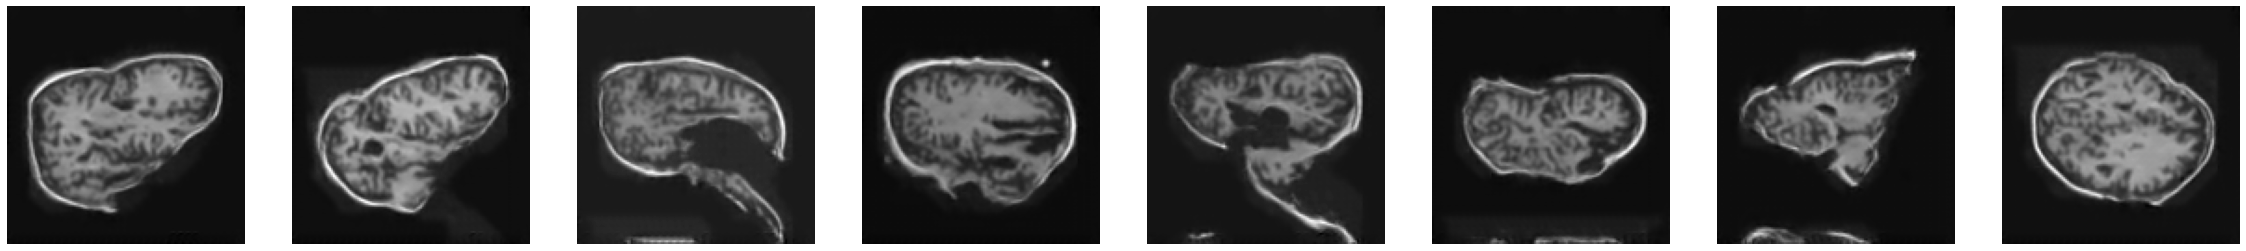

In [965]:
n = 8
plt.figure(figsize=(5*n,5))
generated = gen_images(pixel_cnn, vq, decoder, codebook_indices.shape[1:], n)
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(generated[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

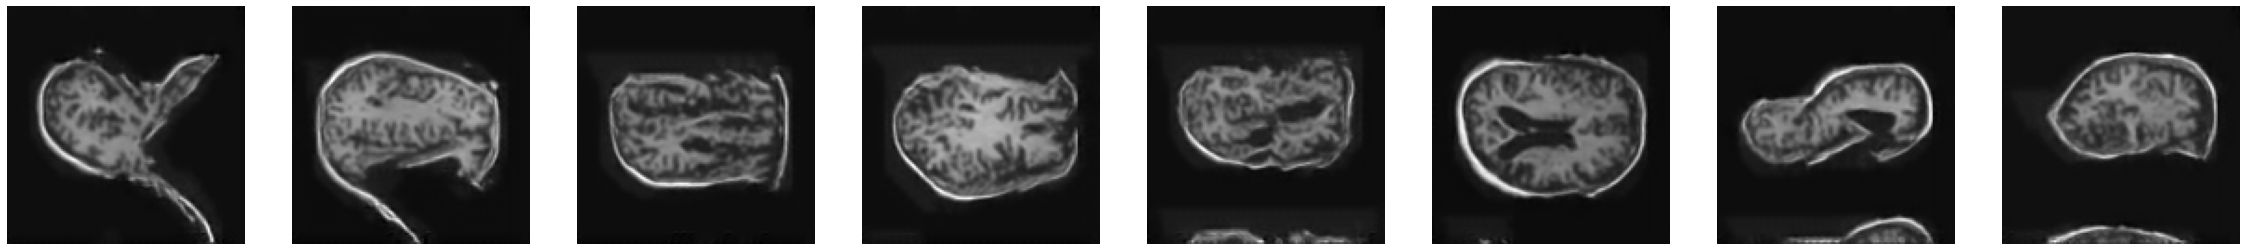

In [966]:
n = 8
plt.figure(figsize=(5*n,5))
generated = gen_images(pixel_cnn, vq, decoder, codebook_indices.shape[1:], n)
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(generated[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

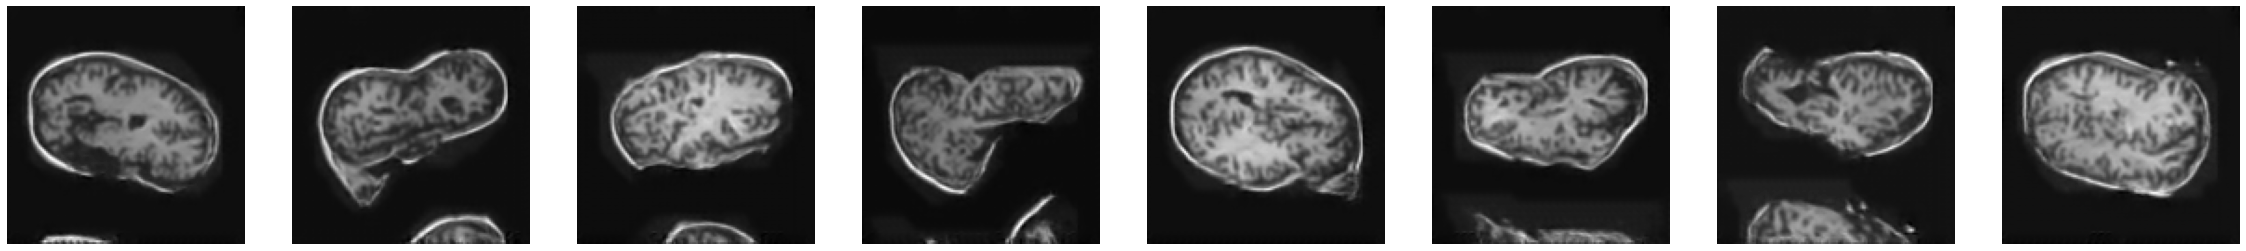

In [967]:
n = 8
plt.figure(figsize=(5*n,5))
generated = gen_images(pixel_cnn, vq, decoder, codebook_indices.shape[1:], n)
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(generated[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

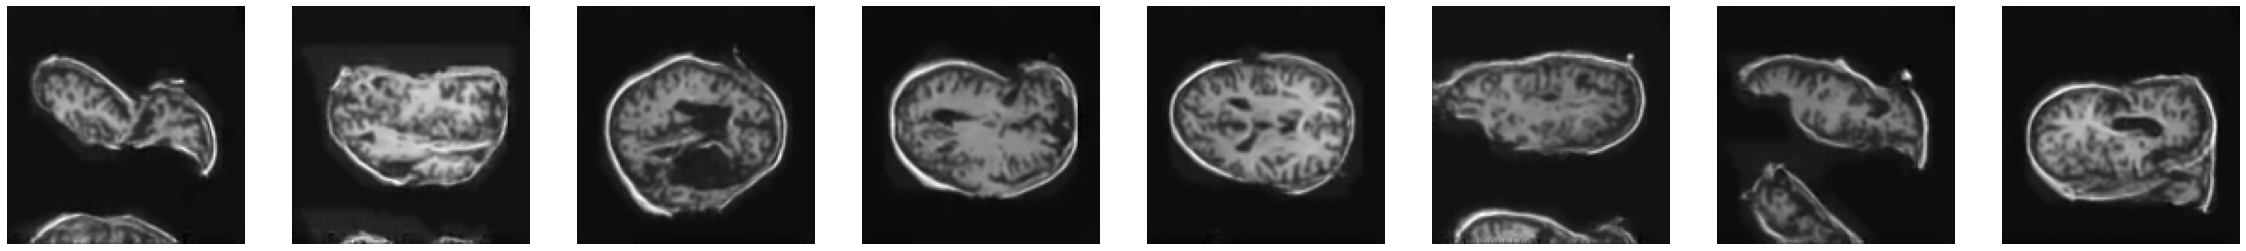

In [968]:
n = 8
plt.figure(figsize=(5*n,5))
generated = gen_images(pixel_cnn, vq, decoder, codebook_indices.shape[1:], n)
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(generated[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [283]:
codebook_indices.shape, pixel_cnn(codebook_indices).shape#.dtype, (batch,) + (pixel_cnn.input_shape)[1:], pixel_cnn.input_shape

<dtype: 'float32'>
<dtype: 'float32'>


(TensorShape([64, 32, 32]), TensorShape([64, 32, 32, 64]))

In [421]:
codebook_indices.numpy().astype(np.float64)-tf.random.uniform(codebook_indices.shape)

<tf.Tensor: shape=(64, 32, 32), dtype=float32, numpy=
array([[[17.29625 , 17.996803, 17.37132 , ..., 17.927952, 17.846695,
         35.438744],
        [17.917917, 17.027037, 17.781977, ..., 17.066841, 17.841125,
         35.087315],
        [17.981403, 17.64158 , 17.07157 , ..., 17.421564, 17.050518,
         35.89723 ],
        ...,
        [17.1552  , 17.943516, 17.011848, ..., 17.873522, 17.576681,
         35.448513],
        [17.917835, 17.142204, 17.695091, ..., 17.24419 , 17.389967,
         35.959854],
        [35.27007 , 35.443336, 35.95113 , ..., 35.58714 , 35.907227,
         35.523434]],

       [[17.670097, 17.590622, 17.699654, ..., 17.571903, 17.023033,
         35.15411 ],
        [17.471989, 17.083838, 17.099464, ..., 17.110313, 17.126068,
         35.503212],
        [17.03384 , 17.516361, 17.718372, ..., 17.203915, 17.01002 ,
         35.407715],
        ...,
        [17.080034, 17.662296, 17.859951, ..., 17.942463, 17.321508,
         35.79674 ],
        [17.342163

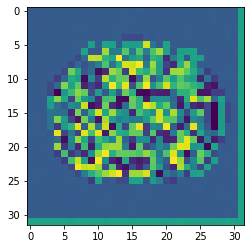

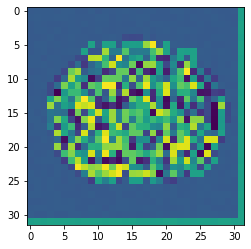

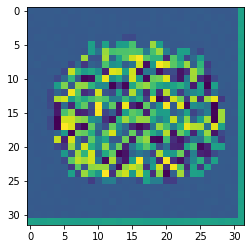

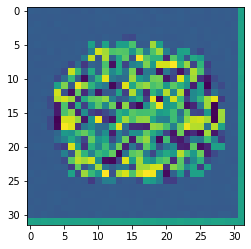

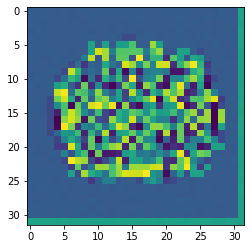

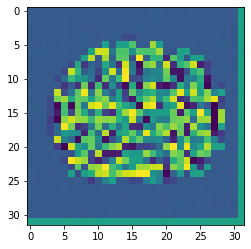

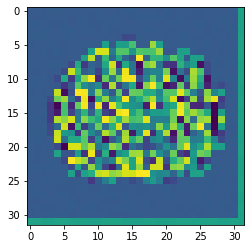

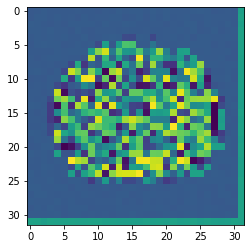

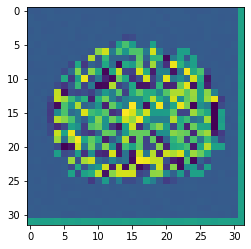

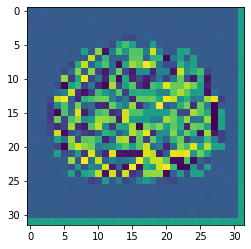

In [424]:
for i in range(10):
    plt.figure()
    plt.imshow((codebook_indices.numpy().astype(np.float64)-tf.random.uniform(codebook_indices.shape))[i])

In [334]:
tf.image.ssim(tf.reshape(codebook_indices[0], (32, 32, 1)),
              tf.reshape(codebook_indices[1], (32, 32, 1)), 3)


<tf.Tensor: shape=(), dtype=float32, numpy=0.61587155>